<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Accor/Accor_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AC.PA"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  25.07  25.56  24.65  25.56      18.45  1225724
2009-01-05  25.70  26.43  25.60  26.19      18.90  1660146
2009-01-06  26.22  26.24  24.88  24.91      17.98  2804791
2009-01-07  24.70  24.82  23.41  23.75      17.14  3964044
2009-01-08  23.63  24.03  23.25  23.41      16.90  3471459
...           ...    ...    ...    ...        ...      ...
2018-12-21  36.04  36.10  35.48  35.73      34.69  1468793
2018-12-24  35.46  36.20  35.30  36.20      35.14   441361
2018-12-27  36.12  36.20  35.36  35.62      34.58   972935
2018-12-28  35.75  36.53  35.70  36.44      35.38   608698
2018-12-31  36.73  37.11  36.60  37.11      36.03   220390

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     33.339992    33.705802    32.960489    33.329816    29.465149  1.117582e+06
std       8.022241     8.044637     8.010759     8.029058     8.877724  6.131032e+05
min      17.100000    17.840000    17.030000    17.030000    12.820000  0.000000e+00
25%      26.387500    26.710000    26.050000    26.377500    21.400000  7.270235e+05
50%      33.500000    33.820000    33.150000    33.495000    29.720000  9.665005e+05
75%      39.502500    40.002500    39.100000    39.445000    36.985000  1.332391e+06
max      51.630000    51.650000    50.690000    51.340000    47.220000  5.617396e+06

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  19.48  20.14  19.14  19.31      13.94  1340717   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  19.071752  19.412215  17.936000  18.879541  19.185912  19.545073      18.905      19.020  20.163236  18.90000  19.159398  18.7580  18.977222  18.90000  19.296667  20.078513               20.105570                 18.90000               17.694430               20.708356                 18.90000               17.091644               21.311141                 18.90000               16.488859               21.913926                 18.90000               15.886074  19.185912  19.193014  19.881672               20.391483                19.185912               17.980342               20.994268                19.185912               17.377557               21.597053                19.185912               16.774771               22.199838                19.185912   
2009-03-16  19.73  19.77  19.51  19.77      14.27  1282771   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  19.106664  19.404576  18.024160  19.178374  19.315709  19.546049      18.910      19.020  20.140000  18.90125  19.527514  18.9250  19.170556  18.90125  19.540000  19.939520               20.110400                 18.90125               17.692100               20.714975                 18.90125               17.087525               21.319550                 18.90125               16.482950               21.924125                 18.90125               15.878375  19.315709  19.596104  19.754863               20.524859                19.315709               18.106559               21.129434                19.315709               17.501984               21.734009                19.315709               16.897409               22.338584                19.315709   
2009-03-17  19.59  19.71  19.10  19.31      1

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     33.570415    33.935878    33.194489    33.562634    29.741097  1.093932e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    33.545237    33.472591     1.050774    33.562470    33.538282    33.553751    33.518057    33.510090    33.417044    33.538258    33.562661    33.538287    33.546373    33.538258    33.555998    33.490095               34.704279                33.538258               32.372236               35.287290                33.538258               31.789225               35.870301                33.538258               31.206214               36.453312                33.538258               30.623203    33.538282    33.557289    33.497238               34.704303                33.538282               32.372260               35.287314                33.538282               31.789249               35.870325   
std       7.928186     7.951774     7.911154     7.931692     8.743973  5.822819e+05     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     7.932570     7.911121    34.415939     7.939901     7.908828     7.981080     7.912212     7.899586     7.968628     7.921355     7.936052     7.927256     7.919461     7.921355     7.925661     7.907305                8.001712                 7.921355                7.897932                8.062755                 7.921355                7.907777                8.137316                 7.921355                7.931947                8.225025                 7.921355                7.970312     7.908828     7.922999     7.909829                7.989488                 7.908828                7.885189                8.050711                 7.908828                7.894961                8.125469   
min      17.100000    17.840000    17.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.068926  0.068027  0.062686  0.066453   0.032558  1340717   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.031125  0.017909  0.685441  0.034896  0.026056  0.037258    0.027267    0.025381  0.090504  0.023229  0.050362  0.024080  0.028761  0.023229  0.049522  0.038700                0.025280                 0.023229                0.035429                0.025967                 0.023229                0.047682                0.027900                 0.023229                0.060914                0.038001                 0.023229                0.074452  0.026056  0.042251  0.034360                0.022992                 0.026056                0.050989                0.023657                 0.026056                0.065391                0.033810                 0.026056                0.079096                0.043659                 0.026056   
2009-03-16  0.076166  0.057084  0.073678  0.079860   0.042151  1282771   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.032199  0.017666  0.686310  0.043875  0.030090  0.037289    0.027420    0.025381  0.089832  0.023267  0.061274  0.029189  0.034676  0.023267  0.056826  0.034249                0.025427                 0.023267                0.035359                0.026166                 0.023267                0.047562                0.028148                 0.023267                0.060747                0.038294                 0.023267                0.074239  0.030090  0.054421  0.030315                0.027071                 0.030090                0.054736                0.027717                 0.030090                0.068994                0.037814                 0.030090                0.082562                0.047608                 0.030090   
2009-03-17  0.072111  0.055309  0.061497  0.066453  

140490

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 19 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_qnz16l
H2O cluster total nodes:    1
H2O cluster free memory:    5.930 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.784299  0.621394              0.324568  0.461686  0.213154
1  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.774898  0.624194              0.302179  0.465038  0.216260
2  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.774644  0.617389              0.264482  0.461620  0.213093
3  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.771659  0.889331              0.256828  0.492548  0.242604
4  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.767848  0.695982              0.261052  0.464932  0.216161
5  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.758194  0.618845              0.289666  0.453386  0.205558
6  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.754287  0.637785              0.284966  0.467063  0.218148
7  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.716876  0.619483              0.344099  0.461560  0.213037
8  DeepLearning_grid_1_AutoML_20190826_163205_mod...  0.701188  2.425432              0.359407  0.605704  0.366877
9              DeepLearning_1_AutoML_20190826_163205  0.571011  1.648195              0.429624  0.664868  0.442050

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.008655
1           CDLCLOSINGMARUBOZU             0.626199           0.626199    0.005420
2                          SUB             0.522886           0.522886    0.004526
3                  CDLLONGLINE             0.515903           0.515903    0.004465
4                          DIV             0.452714           0.452714    0.003918
...                        ...                  ...                ...         ...
1038                    T3_8_2             0.080072           0.080072    0.000693
1039  BBANDS_middleband_30_1_4             0.079795           0.079795    0.000691
1040  BBANDS_middleband_12_1_3             0.079620           0.079620    0.000689
1041          CDLCOUNTERATTACK             0.075408           0.075408    0.000653
1042            CDL3LINESTRIKE             0.072110           0.072110    0.000624

[1043 rows x 4 columns]

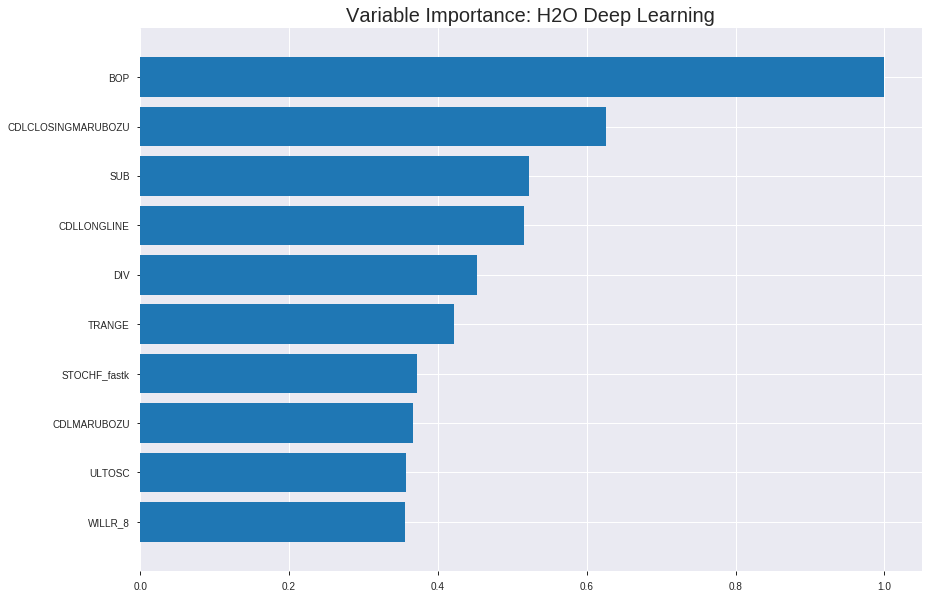

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_163205_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20008320292180246
RMSE: 0.4473066095217043
LogLoss: 0.5820703713388664
Mean Per-Class Error: 0.2994699071360658
AUC: 0.7658148712538585
pr_auc: 0.7633621409564005
Gini: 0.531629742507717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47148947979362493: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  466   0.545    (466.0/855.0)
1      88   810   0.098    (88.0/898.0)
Total  477  1276  0.316    (554.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471489     0.74517   227
max f2                       0.259014     0.858556  319
max f0point5                 0.523598     0.699961  193
max accuracy                 0.523598     0.702795  193
max precision                0.988336     1         0
max recall                   0.0944113    1         379
max specificity              0.988336     1         0
max absolute_mcc             0.523598     0.408747  193
max min_per_class_accuracy   0.543022     0.675947  173
max mean_per_class_accuracy  0.523598     0.70053   193

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 50.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.929408           1.95212   1.95212            1                0.954936  1                           0.954936            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.884567           1.84366   1.89789            0.944444         0.906482  0.972222                    0.930709            0.018931        0.0389755                  84.3665   89.789
    3        0.0302339                   0.841491           1.83729   1.87845            0.941176         0.859684  0.962264                    0.907928            0.0178174       0.0567929                  83.7285   87.8451
    4        0.040502                    0.814909           1.84366   1.86963            0.944444         0.825135  0.957746                    0.886938            0.018931        0.0757238                  84.3665   86.9632
    5        0.0501997                   0.790686           1.72246   1.8412             0.882353         0.801799  0.943182                    0.870491            0.0167038       0.0924276                  72.2455   84.12
    6        0.100399                    0.70941            1.575     1.7081             0.806818         0.752165  0.875                       0.811328            0.0790646       0.171492                   57.5003   70.8101
    7        0.150029                    0.646332           1.54823   1.65522            0.793103         0.675494  0.847909                    0.766394            0.0768374       0.24833                    54.823    65.5216
    8        0.200228                    0.603992           1.39754   1.59061            0.715909         0.62345   0.814815                    0.730556            0.0701559       0.318486                   39.7537   59.0613
    9        0.300057                    0.557161           1.33859   1.50677            0.685714         0.579017  0.771863                    0.680139            0.13363         0.452116                   33.8594   50.6766
    10       0.498574                    0.543025           1.1163    1.35129            0.571839         0.544523  0.69222                     0.626141            0.221604        0.673719                   11.6296   35.1293
    11       0.500285                    0.542965           0         1.34667            0                0.54297   0.689852                    0.625857            0               0.673719                   -100      34.6671
    12       0.600114                    0.522408           1.20473   1.32306            0.617143         0.534027  0.677757                    0.610581            0.120267        0.793987                   20.4734   32.3059
    13       0.699943                    0.48426            0.858931  1.25686            0.44             0.505201  0.643847                    0.595551            0.0857461       0.879733                   -14.1069  25.6863
    14       0.799772                    0.394665           0.624677  1.17795            0.32             0.448527  0.603424                    0.577199            0.0623608       0.942094                   -37.5323  17.7953
    15       0.899601                    0.243265           0.446198  1.09675            0.228571         0.325694  0.561826                    0.54929             0.0445434       0.986637                   -55.3802  9.67499
    16       1                           0.0232086          0.133099  1                  0.0681818        0.15617   0.512265                    0.509821            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2180753064289971
RMSE: 0.46698533855892854
LogLoss: 0.623064824055449
Mean Per-Class Error: 0.3435823754789271
AUC: 0.7136414431673052
pr_auc: 0.7103532117323433
Gini: 0.4272828863346103
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4940528072165035: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   161  0.6708   (161.0/240.0)
1      23   238  0.0881   (23.0/261.0)
Total  102  399  0.3673   (184.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494053     0.721212  297
max f2                       0.208711     0.858653  368
max f0point5                 0.569584     0.674208  208
max accuracy                 0.551324     0.656687  249
max precision                0.980359     1         0
max recall                   0.137784     1         381
max specificity              0.980359     1         0
max absolute_mcc             0.569584     0.316229  208
max min_per_class_accuracy   0.551757     0.65      247
max mean_per_class_accuracy  0.551324     0.656418  249

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 55.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.943987           1.59962   1.59962            0.833333         0.964136  0.833333                    0.964136            0.0191571       0.0191571                  59.9617   59.9617
    2        0.0219561                   0.915563           1.91954   1.74504            1                0.928885  0.909091                    0.948113            0.0191571       0.0383142                  91.954    74.5037
    3        0.0319361                   0.892234           1.53563   1.6796             0.8              0.902746  0.875                       0.933935            0.0153257       0.0536398                  53.5632   67.9598
    4        0.0419162                   0.869262           1.15172   1.55391            0.6              0.883364  0.809524                    0.921895            0.0114943       0.0651341                  15.1724   55.3914
    5        0.0518962                   0.839509           1.53563   1.5504             0.8              0.845319  0.807692                    0.907169            0.0153257       0.0804598                  53.5632   55.0398
    6        0.101796                    0.74059            1.53563   1.54316            0.8              0.782961  0.803922                    0.846283            0.0766284       0.157088                   53.5632   54.316
    7        0.151697                    0.683606           1.45885   1.51543            0.76             0.711291  0.789474                    0.801877            0.0727969       0.229885                   45.8851   51.5426
    8        0.201597                    0.659506           1.30529   1.46341            0.68             0.671922  0.762376                    0.76971             0.0651341       0.295019                   30.5287   46.3412
    9        0.301397                    0.608616           1.2669    1.39834            0.66             0.632868  0.728477                    0.724398            0.126437        0.421456                   26.6897   39.8341
    10       0.401198                    0.57504            1.22851   1.35609            0.64             0.589883  0.706468                    0.690937            0.122605        0.544061                   22.8506   35.6093
    11       0.500998                    0.552176           1.03655   1.29244            0.54             0.56284   0.673307                    0.665419            0.103448        0.64751                    3.65517   29.2439
    12       0.730539                    0.543025           0.918041  1.1748             0.478261         0.544057  0.612022                    0.627286            0.210728        0.858238                   -8.1959   17.4801
    13       0.800399                    0.493372           0.767816  1.13928            0.4              0.521234  0.593516                    0.61803             0.0536398       0.911877                   -23.2184  13.9278
    14       0.9002                      0.343092           0.575862  1.07682            0.3              0.414508  0.560976                    0.595466            0.0574713       0.969349                   -42.4138  7.68153
    15       1                           0.01386            0.307126  1                  0.16             0.173874  0.520958                    0.553391            0.0306513       1                          -69.2874  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:56:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 16:56:40  4 min 30.828 sec  244 obs/sec       0.315459  1             553        0.681548         2.58704             -0.859147      0.552083        0.568143           1.51831          0.487735                         0.697161           2.82355               -0.947556        0.527419          0.558959             1.59962            0.467066
    2019-08-26 16:57:15  5 min  6.024 sec  327 obs/sec       6.35254   20            11136      0.497578         0.688272            0.00906969     0.56083         0.588007           1.30141          0.464347                         0.499415           0.691975              0.000584208      0.517912          0.0160861            1.01812            0.461078
    2019-08-26 16:57:50  5 min 41.022 sec  357 obs/sec       13.3868   42            23467      0.467968         0.626844            0.123495       0.713324        0.701882           1.84366          0.382202                         0.474784           0.639729              0.0967333        0.672613          0.664397             1.91954            0.40519
    2019-08-26 16:58:25  6 min 16.117 sec  360 obs/sec       19.976    63            35018      0.458646         0.607223            0.158067       0.757862        0.751514           1.84366          0.321734                         0.469301           0.628351              0.117474         0.721544          0.712683             1.59962            0.333333
    2019-08-26 16:59:02  6 min 53.328 sec  354 obs/sec       26.4153   83            46306      0.45387          0.595742            0.175512       0.755866        0.757606           1.84366          0.326868                         0.472298           0.633108              0.106169         0.708621          0.707243             1.59962            0.337325
    2019-08-26 16:59:38  7 min 29.666 sec  358 obs/sec       33.3987   105           58548      0.447307         0.58207             0.199185       0.765815        0.763362           1.95212          0.31603                          0.466985           0.623065              0.126163         0.713641          0.710353             1.59962            0.367265
    2019-08-26 17:00:15  8 min  6.420 sec  357 obs/sec       40.0696   126           70242      0.441366         0.56825             0.220317       0.786756        0.789952           1.84366          0.313177                         0.472846           0.636507              0.104094         0.702171          0.690618             1.59962            0.331337
    2019-08-26 17:00:52  8 min 43.143 sec  362 obs/sec       47.5208   149           83304      0.44323          0.570476            0.213717       0.792572        0.799656           1.95212          0.297775                         0.469035           0.633721              0.118474         0.706274          0.705658             1.59962            0.335329
    2019-08-26 17:00:55 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.008655426198668355
CDLCLOSINGMARUBOZU        0.6261988878250122     0.6261988878250122   0.005420018259257597
SUB                       0.5228857398033142     0.5228857398033142   0.004525798931203691
CDLLONGLINE               0.5159034132957458     0.5159034132957458   0.004465363919422426
DIV                       0.4527140259742737     0.4527140259742737   0.003918432840922355
---                       ---                    ---                  ---
T3_8_2                    0.08007171750068665    0.08007171750068665  0.0006930548414278146
BBANDS_middleband_30_1_4  0.07979524880647659    0.07979524880647659  0.0006906618870488372
BBANDS_middleband_12_1_3  0.079619862139225      0.079619862139225    0.0006891438406942108
CDLCOUNTERATTACK          0.07540811598300934    0.07540811598300934  0.0006526893826715609
CDL3LINESTRIKE            0.07211018353700638    0.07211018353700638  0.0006241443717769885


See the whole table with table.as_data_frame()


('accuracy', 0.7091633466135459)

('F1', 0.7560975609756097)

('auc', 0.7842987804878049)

('logloss', 0.6213941934895785)

('mean_per_class_error', 0.28912601626016254)

('rmse', 0.46168555155771757)

('mse', 0.2131535485171539)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


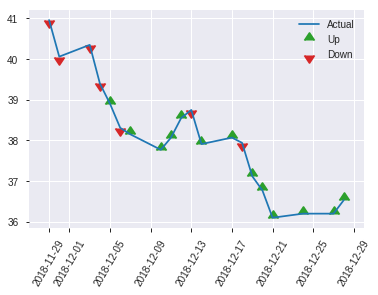


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2131535485171539
RMSE: 0.46168555155771757
LogLoss: 0.6213941934895785
Mean Per-Class Error: 0.28912601626016254
AUC: 0.7842987804878049
pr_auc: 0.7396709817869536
Gini: 0.5685975609756098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5430249109441887: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   76   0.6179   (76.0/123.0)
1      4    124  0.0312   (4.0/128.0)
Total  51   200  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.543025     0.756098  139
max f2                       0.504256     0.877072  151
max f0point5                 0.586196     0.732422  95
max accuracy                 0.573267     0.709163  104
max precision                0.653902     0.851064  46
max recall                   0.0706253    1         189
max specificity              0.953437     0.99187   0
max absolute_mcc             0.543025     0.435909  139
max min_per_class_accuracy   0.558012     0.699187  126
max mean_per_class_accuracy  0.573267     0.710874  104

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 56.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.880778           0.653646   0.653646           0.333333         0.917422  0.333333                    0.917422            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.866234           1.96094    1.30729            1                0.868299  0.666667                    0.89286             0.0234375       0.03125                    96.0938   30.7292
    3        0.0318725                   0.854009           0.980469   1.22559            0.5              0.861556  0.625                       0.885034            0.0078125       0.0390625                  -1.95312  22.5586
    4        0.0438247                   0.795799           1.96094    1.42614            1                0.820388  0.727273                    0.867404            0.0234375       0.0625                     96.0938   42.6136
    5        0.0517928                   0.767538           1.96094    1.50841            1                0.775845  0.769231                    0.853318            0.015625        0.078125                   96.0938   50.8413
    6        0.103586                    0.711524           1.50841    1.50841            0.769231         0.734278  0.769231                    0.793798            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.666612           1.79753    1.59971            0.916667         0.679839  0.815789                    0.757811            0.0859375       0.242188                   79.7526   59.9712
    8        0.203187                    0.637193           1.65925    1.61489            0.846154         0.655427  0.823529                    0.731713            0.0859375       0.328125                   65.9255   61.489
    9        0.302789                    0.612349           1.49031    1.57391            0.76             0.624202  0.802632                    0.696347            0.148438        0.476562                   49.0313   57.391
    10       0.40239                     0.576758           1.255      1.49497            0.64             0.595687  0.762376                    0.671431            0.125           0.601562                   25.5      49.4972
    11       0.501992                    0.559897           0.94125    1.38511            0.48             0.567504  0.706349                    0.650811            0.09375         0.695312                   -5.875    38.5107
    12       0.796813                    0.543025           0.92747    1.21578            0.472973         0.544093  0.62                        0.611325            0.273438        0.96875                    -7.25296  21.5781
    13       0.800797                    0.542781           0          1.20973            0                0.542781  0.616915                    0.610984            0               0.96875                    -100      20.9733
    14       0.900398                    0.399407           0.235313   1.10194            0.12             0.490173  0.561947                    0.59762             0.0234375       0.992188                   -76.4688  10.1943
    15       1                           0.0431693          0.0784375  1                  0.04             0.238741  0.50996                     0.561875            0.0078125       1                          -92.1562  0

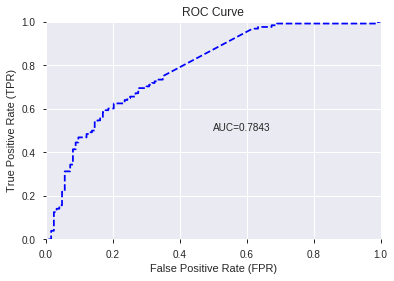

This function is available for GLM models only


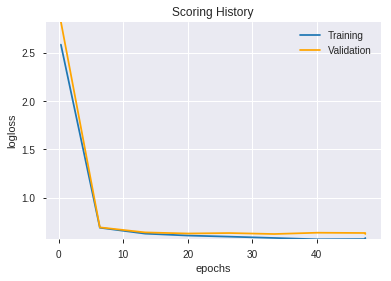

--2019-08-26 17:09:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


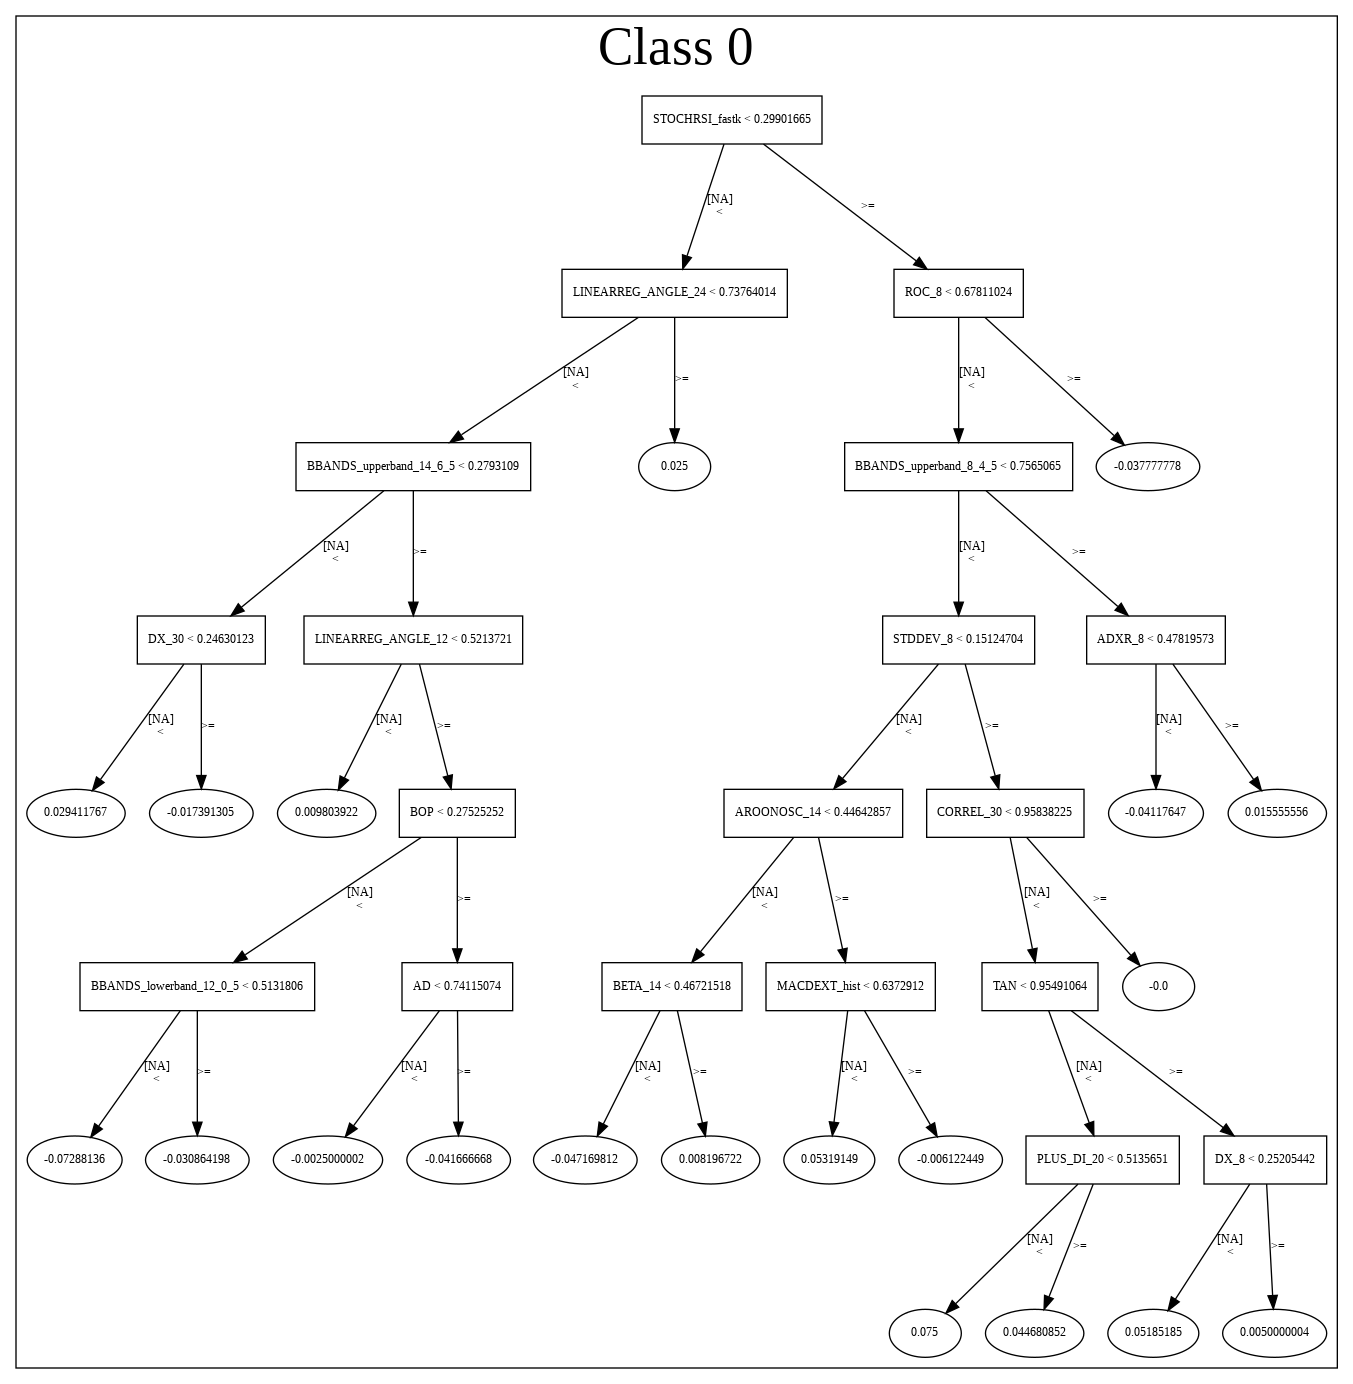

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_163205_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_163205_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_170944_model_9  0.789825  0.570124              0.286712  0.438556  0.192331
1  DeepLearning_grid_1_AutoML_20190826_170944_model_8  0.784680  0.565011              0.277630  0.437291  0.191224
2  DeepLearning_grid_1_AutoML_20190826_170944_model_5  0.781059  0.589703              0.307196  0.439526  0.193183
3  DeepLearning_grid_1_AutoML_20190826_170944_model_4  0.763974  0.737641              0.310626  0.478794  0.229244
4  DeepLearning_grid_1_AutoML_20190826_170944_model_6  0.757177  0.597922              0.307673  0.446971  0.199783
5               DeepLearning_1_AutoML_20190826_170944  0.748476  0.603884              0.314691  0.452259  0.204539
6  DeepLearning_grid_1_AutoML_20190826_170944_model_3  0.736217  0.662312              0.307355  0.463503  0.214835
7  DeepLearning_grid_1_AutoML_20190826_170944_model_7  0.733549  0.692261              0.352865  0.467497  0.218554
8  DeepLearning_grid_1_AutoML_20190826_170944_model_1  0.725483  0.806093              0.324251  0.498164  0.248167
9  DeepLearning_grid_1_AutoML_20190826_170944_model_2  0.717670  0.728418              0.332063  0.496758  0.246768

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.037310
1     CDLCLOSINGMARUBOZU             0.961623           0.961623    0.035878
2            CDLLONGLINE             0.814143           0.814143    0.030376
3                    SUB             0.623943           0.623943    0.023280
4       CDLDRAGONFLYDOJI             0.612215           0.612215    0.022842
5                 TRANGE             0.591864           0.591864    0.022083
6            CDLMARUBOZU             0.591762           0.591762    0.022079
7           CDLENGULFING             0.573340           0.573340    0.021392
8                    DIV             0.564310           0.564310    0.021055
9         STOCHRSI_fastd             0.562263           0.562263    0.020978
10          STOCHF_fastk             0.561622           0.561622    0.020954
11             CDLTAKURI             0.553906           0.553906    0.020666
12          CDLSHORTLINE             0.548277           0.548277    0.020456
13                 ADX_8             0.538519           0.538519    0.020092
14  HT_PHASOR_quadrature             0.537169           0.537169    0.020042
15             aroonup_8             0.536885           0.536885    0.020031
16              CORREL_8             0.531367           0.531367    0.019826
17              STDDEV_8             0.529619           0.529619    0.019760
18               WILLR_8             0.525827           0.525827    0.019619
19                Volume             0.525296           0.525296    0.019599
20          weekday_name             0.522323           0.522323    0.019488
21        is_month_start             0.513595           0.513595    0.019162
22             CORREL_20             0.511741           0.511741    0.019093
23        STOCHRSI_fastk             0.511386           0.511386    0.019080
24           HT_DCPERIOD             0.511159           0.511159    0.019072
25            CDL3INSIDE             0.504526           0.504526    0.018824
26                    AD             0.504434           0.504434    0.018821
27     CDLDARKCLOUDCOVER             0.502827           0.502827    0.018761
28             CORREL_30             0.499141           0.499141    0.018623
29                ULTOSC             0.495227           0.495227    0.018477
30                 DX_14             0.490113           0.490113    0.018286
31           STOCH_slowd             0.489220           0.489220    0.018253
32                   SIN             0.487336           0.487336    0.018183
33            AROONOSC_8             0.487097           0.487097    0.018174
34                   day             0.486349           0.486349    0.018146
35                BETA_8             0.485960           0.485960    0.018131
36               ROCP_20             0.479714           0.479714    0.017898
37               weekday             0.478362           0.478362    0.017848
38                   OBV             0.475724           0.475724    0.017749
39                MOM_20             0.474019           0.474019    0.017686
40             dayofweek             0.472185           0.472185    0.017617
41              WILLR_12             0.472047           0.472047    0.017612
42              WILLR_20             0.467285           0.467285    0.017435
43          STOCHF_fastd             0.466980           0.466980    0.017423
44                  DX_8             0.461876           0.461876    0.017233
45           STOCH_slowk             0.458792           0.458792    0.017118
46                 ADOSC             0.458001           0.458001    0.017088
47           CDLBELTHOLD             0.455657           0.455657    0.017001
48              WILLR_14             0.455333           0.455333    0.016989
49             CORREL_24             0.439858           0.439858    0.016411

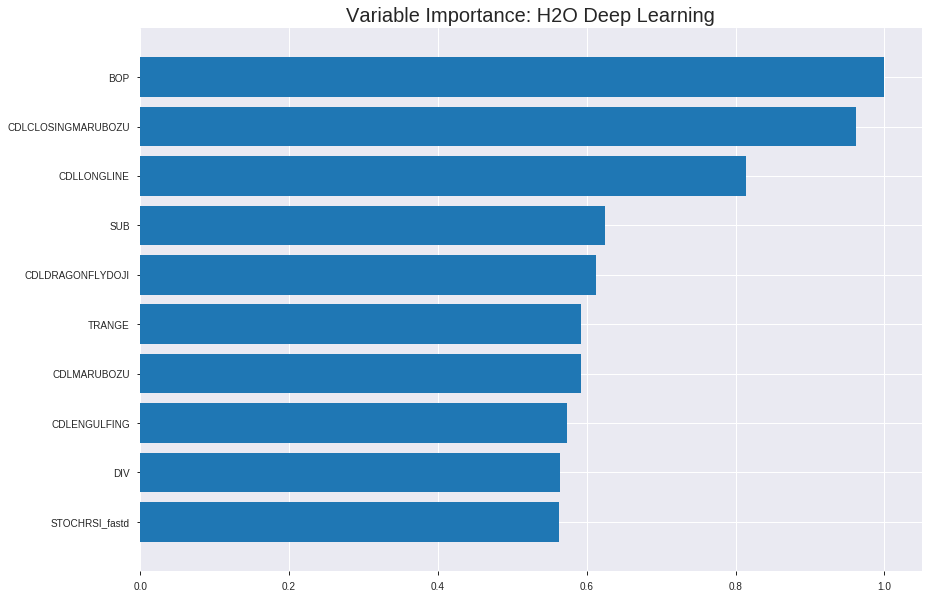

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_170944_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.196564730837993
RMSE: 0.44335621213420817
LogLoss: 0.5747851407352015
Mean Per-Class Error: 0.3050065773193191
AUC: 0.7683207647924563
pr_auc: 0.7680893285679626
Gini: 0.5366415295849125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4228769025009525: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      447  408   0.4772   (408.0/855.0)
1      137  761   0.1526   (137.0/898.0)
Total  584  1169  0.3109   (545.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422877     0.736333  241
max f2                       0.215549     0.857198  336
max f0point5                 0.526187     0.700057  167
max accuracy                 0.459851     0.69652   217
max precision                0.922551     1         0
max recall                   0.064303     1         395
max specificity              0.922551     1         0
max absolute_mcc             0.459851     0.393421  217
max min_per_class_accuracy   0.479467     0.683041  201
max mean_per_class_accuracy  0.459851     0.694993  217

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.898568           1.73521   1.73521            0.888889         0.90547   0.888889                    0.90547             0.0178174       0.0178174                  73.5214   73.5214
    2        0.0205362                   0.892046           1.95212   1.84366            1                0.895387  0.944444                    0.900429            0.0200445       0.0378619                  95.2116   84.3665
    3        0.0302339                   0.882325           1.72246   1.80479            0.882353         0.886365  0.924528                    0.895918            0.0167038       0.0545657                  72.2455   80.4786
    4        0.040502                    0.874537           1.84366   1.81464            0.944444         0.878365  0.929577                    0.891468            0.018931        0.0734967                  84.3665   81.4643
    5        0.0501997                   0.862827           1.83729   1.81902            0.941176         0.868969  0.931818                    0.887121            0.0178174       0.091314                   83.7285   81.9017
    6        0.100399                    0.787027           1.7081    1.76356            0.875            0.825646  0.903409                    0.856384            0.0857461       0.17706                    70.8101   76.3559
    7        0.150029                    0.723516           1.57067   1.69975            0.804598         0.752496  0.870722                    0.822018            0.077951        0.255011                   57.0668   69.9751
    8        0.200228                    0.672923           1.55282   1.66291            0.795455         0.700844  0.851852                    0.791638            0.077951        0.332962                   55.2819   66.2913
    9        0.300057                    0.569633           1.32744   1.5513             0.68             0.619225  0.794677                    0.734276            0.132517        0.465479                   32.7439   55.1301
    10       0.399886                    0.51417            1.02626   1.42023            0.525714         0.540071  0.727532                    0.685794            0.10245         0.567929                   2.62552   42.0227
    11       0.500285                    0.479771           1.10916   1.3578             0.568182         0.49562   0.695553                    0.647629            0.111359        0.679287                   10.9157   35.78
    12       0.600114                    0.44804            1.05972   1.30821            0.542857         0.463987  0.670152                    0.61708             0.105791        0.785078                   5.972     30.8214
    13       0.699943                    0.405058           0.836621  1.24095            0.428571         0.428031  0.635697                    0.590117            0.0835189       0.868597                   -16.3379  24.0954
    14       0.799772                    0.325759           0.658142  1.16821            0.337143         0.368375  0.598431                    0.562439            0.0657016       0.934298                   -34.1858  16.8206
    15       0.899601                    0.212856           0.524283  1.09675            0.268571         0.270492  0.561826                    0.530042            0.0523385       0.986637                   -47.5717  9.67499
    16       1                           0.0418613          0.133099  1                  0.0681818        0.146993  0.512265                    0.491584           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21177689858538043
RMSE: 0.46019224090088745
LogLoss: 0.6111456966983917
Mean Per-Class Error: 0.32365900383141755
AUC: 0.7227330779054917
pr_auc: 0.7160686643807771
Gini: 0.44546615581098337
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38288299822618294: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   159  0.6625   (159.0/240.0)
1      22   239  0.0843   (22.0/261.0)
Total  103  398  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382883     0.725341  306
max f2                       0.178291     0.853578  377
max f0point5                 0.524789     0.694836  169
max accuracy                 0.500741     0.674651  196
max precision                0.921948     1         0
max recall                   0.113676     1         390
max specificity              0.921948     1         0
max absolute_mcc             0.500741     0.353139  196
max min_per_class_accuracy   0.491128     0.659004  208
max mean_per_class_accuracy  0.500741     0.676341  196

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.888835           1.59962   1.59962            0.833333         0.902023  0.833333                    0.902023            0.0191571       0.0191571                  59.9617    59.9617
    2        0.0219561                   0.880588           1.15172   1.39603            0.6              0.883448  0.727273                    0.89358             0.0114943       0.0306513                  15.1724    39.6029
    3        0.0319361                   0.866531           1.91954   1.55963            1                0.873285  0.8125                      0.887238            0.0191571       0.0498084                  91.954     55.9626
    4        0.0419162                   0.856123           1.15172   1.46251            0.6              0.859193  0.761905                    0.88056             0.0114943       0.0613027                  15.1724    46.2507
    5        0.0518962                   0.84074            1.91954   1.5504             1                0.845023  0.807692                    0.873726            0.0191571       0.0804598                  91.954     55.0398
    6        0.101796                    0.777521           1.45885   1.50552            0.76             0.806191  0.784314                    0.840621            0.0727969       0.153257                   45.8851    50.5522
    7        0.151697                    0.7271             1.6892    1.56594            0.88             0.748798  0.815789                    0.810416            0.0842912       0.237548                   68.9195    56.5941
    8        0.201597                    0.670797           1.45885   1.53943            0.76             0.698139  0.80198                     0.782624            0.0727969       0.310345                   45.8851    53.9433
    9        0.301397                    0.587482           1.42046   1.50004            0.74             0.630599  0.781457                    0.732285            0.141762        0.452107                   42.046     50.0038
    10       0.401198                    0.524784           1.15172   1.41339            0.6              0.553724  0.736318                    0.687867            0.114943        0.56705                    15.1724    41.3393
    11       0.500998                    0.49217            0.882989  1.30773            0.46             0.50591   0.681275                    0.65162             0.0881226       0.655172                   -11.7011   30.7735
    12       0.600798                    0.463497           0.767816  1.21805            0.4              0.478727  0.634551                    0.622901            0.0766284       0.731801                   -23.2184   21.8047
    13       0.700599                    0.43224            0.844598  1.16485            0.44             0.448274  0.606838                    0.598025            0.0842912       0.816092                   -15.5402   16.4849
    14       0.800399                    0.376602           0.998161  1.14407            0.52             0.402384  0.59601                     0.573631            0.0996169       0.915709                   -0.183908  14.4065
    15       0.9002                      0.246343           0.575862  1.08107            0.3              0.311917  0.563193                    0.544616            0.0574713       0.97318                    -42.4138   8.10714
    16       1                           0.0305432          0.268736  1                  0.14             0.171014  0.520958                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:18:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:18:07  3 min 19.686 sec  484 obs/sec       0.717627  1             1258       0.494539         0.755866            0.0211341      0.726879        0.72384            1.95212          0.353109                         0.497419           0.773556              0.00855679       0.711175          0.702154             1.91954            0.329341
    2019-08-26 17:18:23  3 min 36.660 sec  451 obs/sec       4.37193   6             7664       0.465461         0.620509            0.132863       0.759198        0.761053           1.84366          0.323446                         0.477478           0.645066              0.0864521        0.716507          0.716401             1.91954            0.383234
    2019-08-26 17:18:51  4 min  4.110 sec  516 obs/sec       12.3868   17            21714      0.443356         0.574785            0.213268       0.768321        0.768089           1.73521          0.310896                         0.460192           0.611146              0.151401         0.722733          0.716069             1.59962            0.361277
    2019-08-26 17:19:17  4 min 29.816 sec  546 obs/sec       20.3126   28            35608      0.443179         0.57433             0.213897       0.772214        0.773047           1.84366          0.334284                         0.464011           0.62236               0.137259         0.72322           0.708328             0.95977            0.357285
    2019-08-26 17:19:43  4 min 56.053 sec  586 obs/sec       29.7496   41            52151      0.438767         0.565711            0.229471       0.783777        0.782638           1.95212          0.313748                         0.462863           0.61763               0.141524         0.710329          0.706887             1.91954            0.363273
    2019-08-26 17:20:08  5 min 21.115 sec  615 obs/sec       39.1974   54            68713      0.439242         0.566914            0.227803       0.792702        0.790147           1.84366          0.318882                         0.468262           0.630156              0.121381         0.717952          0.705185             1.27969            0.365269
    2019-08-26 17:20:34  5 min 46.647 sec  641 obs/sec       49.2864   68            86399      0.428577         0.546799            0.264844       0.80058         0.795395           1.95212          0.286366                         0.473441           0.652713              0.101835         0.710481          0.700924             1.91954            0.369261
    2019-08-26 17:20:36  5 min 49.161 sec  641 obs/sec       49.2864   68            86399      0.443356         0.574785            0.213268       0.768321        0.768089           1.73521          0.310896                         0.460192           0.611146              0.151401         0.722733          0.716069             1.59962            0.361277

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03731034616244496
CDLCLOSINGMARUBOZU  0.9616225957870483     0.9616225957870483   0.03587847192644366
CDLLONGLINE         0.8141432404518127     0.8141432404518127   0.030375966127071795
SUB                 0.6239426732063293     0.6239426732063293   0.02327951712284942
CDLDRAGONFLYDOJI    0.6122146844863892     0.6122146844863892   0.022841941803919203
---                 ---                    ---                  ---
STOCH_slowk         0.458791583776474      0.458791583776474    0.017117672807116614
ADOSC               0.45800092816352844    0.45800092816352844  0.017088173172502334
CDLBELTHOLD         0.4556571841239929     0.4556571841239929   0.017000727271071096
WILLR_14            0.4553334414958954     0.4553334414958954   0.016988648321549237
CORREL_24           0.4398578703403473     0.4398578703403473   0.01641124940467419


See the whole table with table.as_data_frame()


('accuracy', 0.7330677290836654)

('F1', 0.7656765676567656)

('auc', 0.7898246951219512)

('logloss', 0.5701243182508214)

('mean_per_class_error', 0.26743521341463417)

('rmse', 0.43855587084116876)

('mse', 0.1923312518492559)

deeplearning prediction progress: |███████████████████████████████████████| 100%


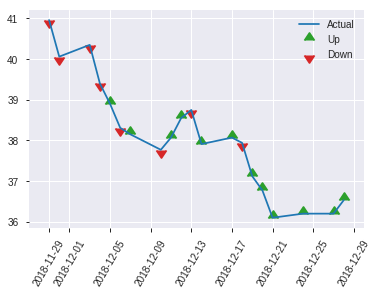


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1923312518492559
RMSE: 0.43855587084116876
LogLoss: 0.5701243182508214
Mean Per-Class Error: 0.26743521341463417
AUC: 0.7898246951219512
pr_auc: 0.7360673293642741
Gini: 0.5796493902439024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4222618176750603: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   59   0.4797   (59.0/123.0)
1      12   116  0.0938   (12.0/128.0)
Total  76   175  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422262     0.765677  174
max f2                       0.238514     0.866303  220
max f0point5                 0.485198     0.737179  123
max accuracy                 0.476094     0.733068  132
max precision                0.709313     0.854167  47
max recall                   0.0831111    1         245
max specificity              0.901557     0.99187   0
max absolute_mcc             0.459007     0.470825  148
max min_per_class_accuracy   0.484816     0.726562  125
max mean_per_class_accuracy  0.476094     0.732565  132

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.88784            0.653646   0.653646           0.333333         0.894029  0.333333                    0.894029            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.881082           1.30729    0.980469           0.666667         0.88459   0.5                         0.889309            0.015625        0.0234375                  30.7292   -1.95312
    3        0.0318725                   0.875415           1.96094    1.22559            1                0.879108  0.625                       0.886759            0.015625        0.0390625                  96.0938   22.5586
    4        0.0438247                   0.869754           1.96094    1.42614            1                0.871375  0.727273                    0.882563            0.0234375       0.0625                     96.0938   42.6136
    5        0.0517928                   0.855872           1.96094    1.50841            1                0.857308  0.769231                    0.878678            0.015625        0.078125                   96.0938   50.8413
    6        0.103586                    0.780785           1.50841    1.50841            0.769231         0.816611  0.769231                    0.847645            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.727532           1.96094    1.65132            1                0.746931  0.842105                    0.81584             0.09375         0.25                       96.0938   65.1316
    8        0.203187                    0.699434           1.65925    1.65334            0.846154         0.712988  0.843137                    0.789623            0.0859375       0.335938                   65.9255   65.3339
    9        0.302789                    0.608769           1.255      1.52231            0.64             0.657298  0.776316                    0.746095            0.125           0.460938                   25.5      52.2307
    10       0.40239                     0.53049            1.49031    1.51439            0.76             0.568999  0.772277                    0.70226             0.148438        0.609375                   49.0313   51.4387
    11       0.501992                    0.484816           1.17656    1.44736            0.6              0.502429  0.738095                    0.662611            0.117188        0.726562                   17.6562   44.7359
    12       0.601594                    0.458348           0.94125    1.36357            0.48             0.469565  0.695364                    0.630649            0.09375         0.820312                   -5.875    36.3566
    13       0.701195                    0.420404           0.862812   1.29244            0.44             0.440555  0.659091                    0.603647            0.0859375       0.90625                    -13.7188  29.2436
    14       0.800797                    0.332614           0.470625   1.19022            0.24             0.38007   0.606965                    0.575839            0.046875        0.953125                   -52.9375  19.0221
    15       0.900398                    0.207813           0.392188   1.10194            0.2              0.266521  0.561947                    0.541623            0.0390625       0.992188                   -60.7812  10.1943
    16       1                           0.0492538          0.0784375  1                  0.04             0.132556  0.50996                  

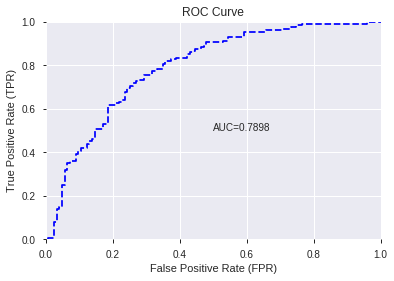

This function is available for GLM models only


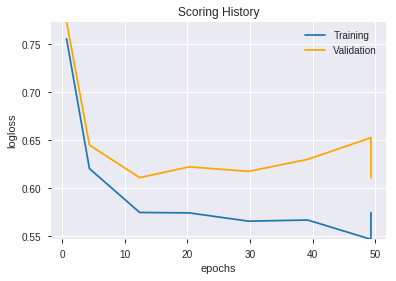

--2019-08-26 17:20:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


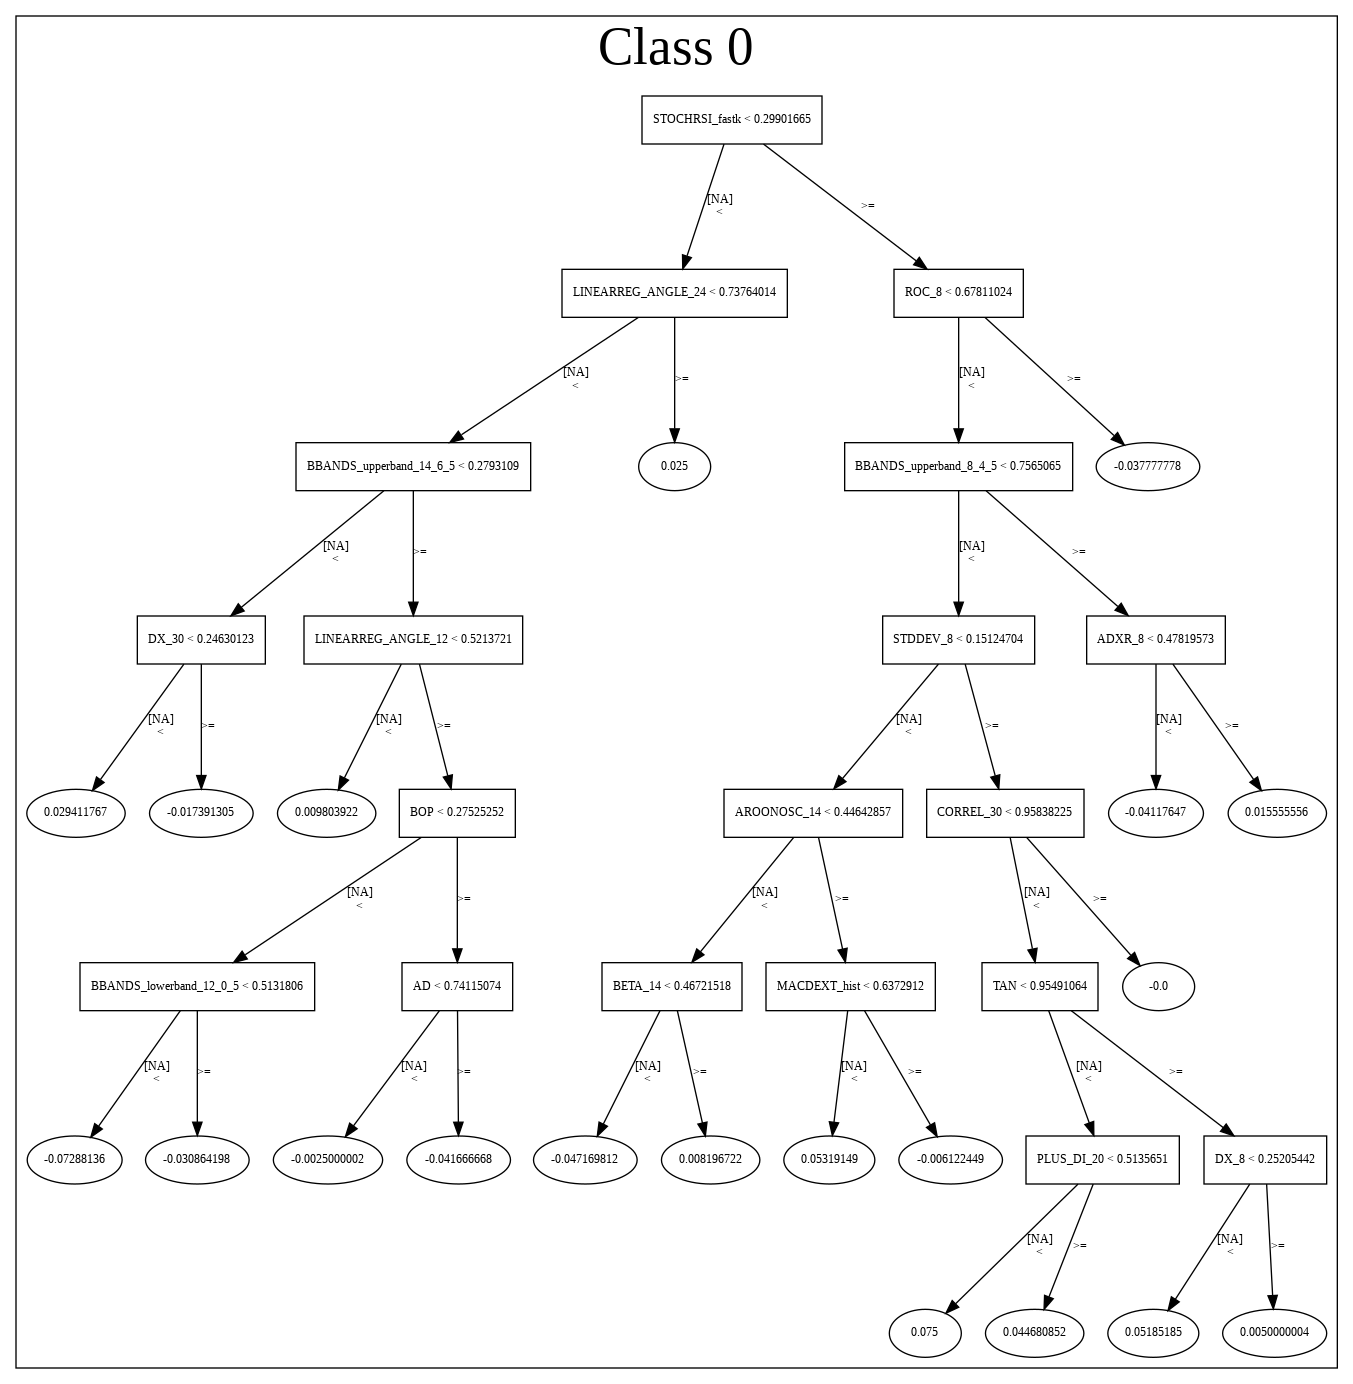

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_170944_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_170944_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'DIV',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'CDLTAKURI',
 'CDLSHORTLINE',
 'ADX_8',
 'HT_PHASOR_quadrature',
 'aroonup_8',
 'CORREL_8',
 'STDDEV_8',
 'WILLR_8',
 'Volume',
 'weekday_name',
 'is_month_start',
 'CORREL_20',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'CDL3INSIDE',
 'AD',
 'CDLDARKCLOUDCOVER',
 'CORREL_30',
 'ULTOSC',
 'DX_14',
 'STOCH_slowd',
 'SIN',
 'AROONOSC_8',
 'day',
 'BETA_8',
 'ROCP_20',
 'weekday',
 'OBV',
 'MOM_20',
 'dayofweek',
 'WILLR_12',
 'WILLR_20',
 'STOCHF_fastd',
 'DX_8',
 'STOCH_slowk',
 'ADOSC',
 'CDLBELTHOLD',
 'WILLR_14',
 'CORREL_24']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_172052_model_1  0.788554  0.571537              0.281536  0.438713  0.192469

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.323088           1.000000    0.100143
1     CDLCLOSINGMARUBOZU             0.182393           0.564530    0.056534
2            CDLLONGLINE             0.136427           0.422259    0.042286
3                    SUB             0.130009           0.402394    0.040297
4           STOCHF_fastk             0.117829           0.364696    0.036522
5                WILLR_8             0.108744           0.336575    0.033706
6         STOCHRSI_fastd             0.106618           0.329998    0.033047
7                    DIV             0.100365           0.310644    0.031109
8              aroonup_8             0.097887           0.302974    0.030341
9               STDDEV_8             0.092332           0.285779    0.028619
10                ULTOSC             0.089542           0.277143    0.027754
11                   OBV             0.080154           0.248087    0.024844
12           STOCH_slowd             0.079328           0.245530    0.024588
13                TRANGE             0.076122           0.235607    0.023594
14          CDLENGULFING             0.075736           0.234413    0.023475
15                 ADX_8             0.072018           0.222906    0.022323
16  HT_PHASOR_quadrature             0.071343           0.220816    0.022113
17            AROONOSC_8             0.068473           0.211934    0.021224
18      CDLDRAGONFLYDOJI             0.067502           0.208926    0.020923
19             CDLTAKURI             0.067441           0.208739    0.020904
20           STOCH_slowk             0.064177           0.198635    0.019892
21          STOCHF_fastd             0.063517           0.196594    0.019688
22            CDL3INSIDE             0.062760           0.194251    0.019453
23          weekday_name             0.062553           0.193611    0.019389
24        STOCHRSI_fastk             0.061388           0.190003    0.019028
25           CDLMARUBOZU             0.055063           0.170426    0.017067
26     CDLDARKCLOUDCOVER             0.050295           0.155670    0.015589
27             CORREL_30             0.050295           0.155670    0.015589
28          CDLSHORTLINE             0.050277           0.155614    0.015584
29                Volume             0.047003           0.145480    0.014569
30              WILLR_12             0.046126           0.142767    0.014297
31              CORREL_8             0.043218           0.133766    0.013396
32              WILLR_14             0.040927           0.126675    0.012686
33                 ADOSC             0.036261           0.112233    0.011239
34                 DX_14             0.035498           0.109871    0.011003
35              WILLR_20             0.035183           0.108895    0.010905
36        is_month_start             0.033180           0.102697    0.010284
37                BETA_8             0.033038           0.102258    0.010240
38                MOM_20             0.030102           0.093169    0.009330
39           HT_DCPERIOD             0.030032           0.092952    0.009309
40             CORREL_24             0.029768           0.092136    0.009227
41                   SIN             0.028524           0.088287    0.008841
42           CDLBELTHOLD             0.020017           0.061956    0.006204
43                   day             0.018110           0.056054    0.005613
44                  DX_8             0.014387           0.044528    0.004459
45             dayofweek             0.012295           0.038054    0.003811
46               weekday             0.012286           0.038027    0.003808
47               ROCP_20             0.008201           0.025383    0.002542
48                    AD             0.006779           0.020981    0.002101
49             CORREL_20             0.001646           0.005094    0.000510

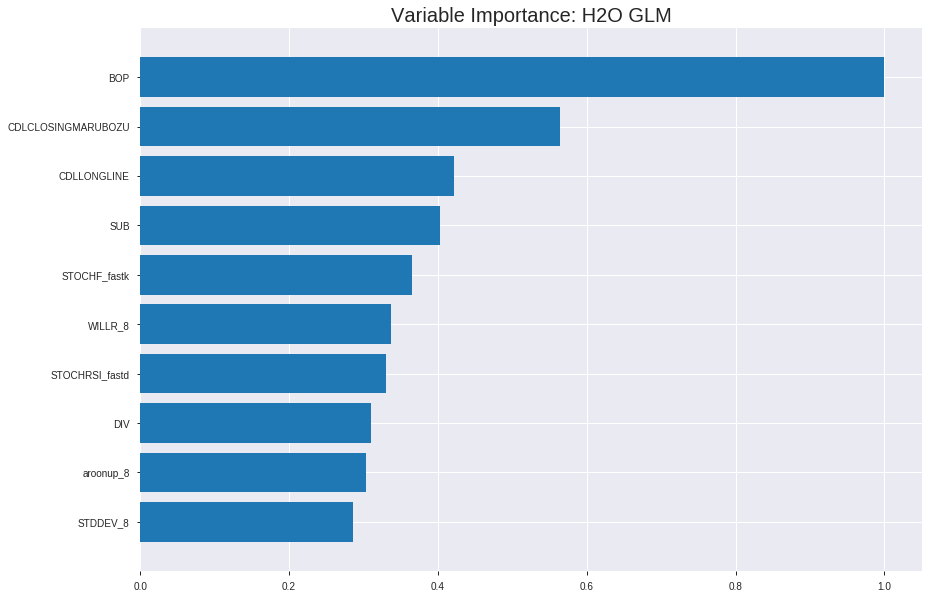

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_172052_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19774944142935666
RMSE: 0.4446902758430374
LogLoss: 0.5788020263014306
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.1191459812417
Residual deviance: 2029.2799042128158
AIC: 2131.279904212816
AUC: 0.7665227471053283
pr_auc: 0.7689296749357157
Gini: 0.5330454942106566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4491150934134585: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      466  389   0.455    (389.0/855.0)
1      149  749   0.1659   (149.0/898.0)
Total  615  1138  0.3069   (538.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449115     0.735756  237
max f2                       0.211606     0.850595  352
max f0point5                 0.527349     0.701536  189
max accuracy                 0.523217     0.693668  192
max precision                0.932737     1         0
max recall                   0.138312     1         380
max specificity              0.932737     1         0
max absolute_mcc             0.449115     0.397075  237
max min_per_class_accuracy   0.527349     0.691537  189
max mean_per_class_accuracy  0.523217     0.693414  192

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.88299            1.84366   1.84366            0.944444         0.89793   0.944444                    0.89793             0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.862987           1.84366   1.84366            0.944444         0.871401  0.944444                    0.884666            0.018931        0.0378619                  84.3665   84.3665
    3        0.0302339                   0.849384           1.83729   1.84162            0.941176         0.856436  0.943396                    0.875611            0.0178174       0.0556793                  83.7285   84.1619
    4        0.040502                    0.836389           1.62676   1.78715            0.833333         0.842252  0.915493                    0.867154            0.0167038       0.0723831                  62.6763   78.7148
    5        0.0501997                   0.816295           1.83729   1.79683            0.941176         0.823237  0.920455                    0.85867             0.0178174       0.0902004                  83.7285   79.6834
    6        0.100399                    0.757293           1.7081    1.75247            0.875            0.783682  0.897727                    0.821176            0.0857461       0.175947                   70.8101   75.2468
    7        0.150029                    0.715306           1.57067   1.69233            0.804598         0.735495  0.86692                     0.792833            0.077951        0.253898                   57.0668   69.2329
    8        0.200228                    0.679697           1.59719   1.66848            0.818182         0.697637  0.854701                    0.768966            0.0801782       0.334076                   59.7186   66.8475
    9        0.300057                    0.624408           1.26051   1.53274            0.645714         0.648097  0.785171                    0.728753            0.125835        0.459911                   26.0509   53.2745
    10       0.399886                    0.573537           1.16011   1.43972            0.594286         0.599149  0.737518                    0.696398            0.115813        0.575724                   16.0115   43.972
    11       0.500285                    0.528329           1.10916   1.37338            0.568182         0.550164  0.703535                    0.667051            0.111359        0.687082                   10.9157   37.3381
    12       0.600114                    0.474578           0.959325  1.3045             0.491429         0.502137  0.668251                    0.639618            0.0957684       0.782851                   -4.06745  30.4503
    13       0.699943                    0.41682            0.814311  1.23459            0.417143         0.446987  0.632437                    0.612144            0.0812918       0.864143                   -18.5689  23.459
    14       0.799772                    0.345089           0.725072  1.17099            0.371429         0.381227  0.599857                    0.58332             0.0723831       0.936526                   -27.4928  17.0991
    15       0.899601                    0.237898           0.379268  1.08313            0.194286         0.289293  0.554851                    0.550692            0.0378619       0.974388                   -62.0732  8.31334
    16       1                           0.0390107          0.255106  1                  0.130682         0.167947  0.512265                    0.512265           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21434995062827492
RMSE: 0.4629794278672379
LogLoss: 0.6157295174534535
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.804571947685
Residual deviance: 616.9609764883604
AIC: 718.9609764883604
AUC: 0.7162835249042145
pr_auc: 0.7197536171958914
Gini: 0.4325670498084291
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3748592176333652: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   165  0.6875   (165.0/240.0)
1      20   241  0.0766   (20.0/261.0)
Total  95   406  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374859     0.722639  318
max f2                       0.22089      0.852048  370
max f0point5                 0.564977     0.69386   184
max accuracy                 0.564977     0.674651  184
max precision                0.922109     1         0
max recall                   0.140222     1         388
max specificity              0.922109     1         0
max absolute_mcc             0.564977     0.353673  184
max min_per_class_accuracy   0.550155     0.659004  199
max mean_per_class_accuracy  0.564977     0.676509  184

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 53.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.880701           1.91954   1.91954            1                0.897594  1                           0.897594            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.851489           1.91954   1.91954            1                0.86575   1                           0.883119            0.0191571       0.0421456                  91.954    91.954
    3        0.0319361                   0.839473           1.53563   1.79957            0.8              0.842859  0.9375                      0.870538            0.0153257       0.0574713                  53.5632   79.9569
    4        0.0419162                   0.82345            0.767816  1.55391            0.4              0.833325  0.809524                    0.861678            0.00766284      0.0651341                  -23.2184  55.3914
    5        0.0518962                   0.800785           1.91954   1.62423            1                0.811236  0.846154                    0.851977            0.0191571       0.0842912                  91.954    62.4226
    6        0.101796                    0.748259           1.38207   1.50552            0.72             0.772541  0.784314                    0.813038            0.0689655       0.153257                   38.2069   50.5522
    7        0.151697                    0.711277           1.61241   1.54068            0.84             0.729204  0.802632                    0.785461            0.0804598       0.233716                   61.2414   54.0684
    8        0.201597                    0.677663           1.61241   1.55844            0.84             0.692078  0.811881                    0.762346            0.0804598       0.314176                   61.2414   55.8439
    9        0.301397                    0.628182           1.22851   1.44919            0.64             0.651211  0.754967                    0.725546            0.122605        0.436782                   22.8506   44.9189
    10       0.401198                    0.588077           1.15172   1.37519            0.6              0.60496   0.716418                    0.69555             0.114943        0.551724                   15.1724   37.5193
    11       0.500998                    0.550077           1.07494   1.31538            0.56             0.568971  0.685259                    0.670335            0.10728         0.659004                   7.49425   31.5382
    12       0.600798                    0.507498           0.767816  1.22442            0.4              0.529537  0.637874                    0.646946            0.0766284       0.735632                   -23.2184  22.4424
    13       0.700599                    0.463655           0.882989  1.17579            0.46             0.483831  0.612536                    0.623711            0.0881226       0.823755                   -11.7011  17.5787
    14       0.800399                    0.382404           0.882989  1.13928            0.46             0.42542   0.593516                    0.598986            0.0881226       0.911877                   -11.7011  13.9278
    15       0.9002                      0.305488           0.49908   1.0683             0.26             0.345342  0.556541                    0.570866            0.0498084       0.961686                   -50.092   6.83029
    16       1                           0.0523833          0.383908  1                  0.2              0.190448  0.520958                    0.5329             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:20:52  0.000 sec   2            20        51            1.3667            1.37059
    2019-08-26 17:20:52  0.012 sec   4            12        51            1.35712           1.36333
    2019-08-26 17:20:52  0.025 sec   6            7.7       51            1.34395           1.3533
    2019-08-26 17:20:52  0.041 sec   8            4.8       51            1.32684           1.34014
    2019-08-26 17:20:52  0.055 sec   10           3         51            1.30599           1.32399
    2019-08-26 17:20:52  0.067 sec   12           1.8       51            1.28214           1.30551
    2019-08-26 17:20:52  0.081 sec   14           1.1       51            1.25671           1.28613
    2019-08-26 17:20:52  0.092 sec   16           0.71      51            1.23141           1.26772
    2019-08-26 17:20:52  0.104 sec   18           0.44      51            1.20798           1.25223
    2019-08-26 17:20:52  0.115 sec   20           0.27      51            1.18761           1.24092
    2019-08-26 17:20:52  0.126 sec   22           0.17      51            1.17081           1.23415
    2019-08-26 17:20:52  0.137 sec   24           0.11      51            1.1576            1.23146
    2019-08-26 17:20:52  0.150 sec   26           0.066     51            1.14768           1.23191
    2019-08-26 17:20:52  0.160 sec   28           0.041     51            1.14056           1.23432
    2019-08-26 17:20:52  0.174 sec   30           0.025     51            1.13565           1.23757
    2019-08-26 17:20:52  0.186 sec   32           0.016     51            1.13235           1.24064
    2019-08-26 17:20:52  0.197 sec   34           0.0098    51            1.13015           1.24299

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7569444444444445)

('auc', 0.7885543699186992)

('logloss', 0.5715374284362961)

('mean_per_class_error', 0.2677527947154472)

('rmse', 0.4387128707773512)

('mse', 0.19246898298570486)

glm prediction progress: |████████████████████████████████████████████████| 100%


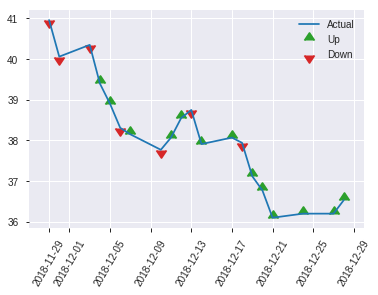


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19246898298570486
RMSE: 0.4387128707773512
LogLoss: 0.5715374284362961
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.8656113866541
Residual deviance: 286.9117890750206
AIC: 388.9117890750206
AUC: 0.7885543699186992
pr_auc: 0.7418710717274966
Gini: 0.5771087398373984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726479005737328: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   51   0.4146   (51.0/123.0)
1      19   109  0.1484   (19.0/128.0)
Total  91   160  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472648     0.756944  159
max f2                       0.291406     0.872253  215
max f0point5                 0.588233     0.744485  103
max accuracy                 0.520013     0.733068  136
max precision                0.671738     0.847458  58
max recall                   0.108924     1         247
max specificity              0.91092      0.99187   0
max absolute_mcc             0.520013     0.466364  136
max min_per_class_accuracy   0.539836     0.715447  126
max mean_per_class_accuracy  0.520013     0.732247  136

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.873002           1.30729    1.30729            0.666667         0.893782  0.666667                    0.893782            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.857667           1.30729    1.30729            0.666667         0.866292  0.666667                    0.880037            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.844181           1.96094    1.4707             1                0.845353  0.75                        0.871366            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.839154           1.96094    1.6044             1                0.840502  0.818182                    0.862948            0.0234375       0.0703125                  96.0938   60.4403
    5        0.0517928                   0.830658           0.980469   1.50841            0.5              0.832519  0.769231                    0.858267            0.0078125       0.078125                   -1.95312  50.8413
    6        0.103586                    0.767996           1.50841    1.50841            0.769231         0.789951  0.769231                    0.824109            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.725411           1.79753    1.59971            0.916667         0.739451  0.815789                    0.797375            0.0859375       0.242188                   79.7526   59.9712
    8        0.203187                    0.692064           1.65925    1.61489            0.846154         0.706473  0.823529                    0.774204            0.0859375       0.328125                   65.9255   61.489
    9        0.302789                    0.639082           1.33344    1.52231            0.68             0.662643  0.776316                    0.737506            0.132812        0.460938                   33.3438   52.2307
    10       0.40239                     0.594304           1.56875    1.5338             0.8              0.617918  0.782178                    0.707905            0.15625         0.617188                   56.875    53.3803
    11       0.501992                    0.543026           0.94125    1.41623            0.48             0.56723   0.722222                    0.679993            0.09375         0.710938                   -5.875    41.6233
    12       0.601594                    0.487956           1.01969    1.35058            0.52             0.514112  0.688742                    0.652529            0.101562        0.8125                     1.96875   35.0579
    13       0.701195                    0.441779           0.705937   1.25901            0.36             0.463572  0.642045                    0.625689            0.0703125       0.882812                   -29.4062  25.9011
    14       0.800797                    0.371834           0.6275     1.18046            0.32             0.409325  0.60199                     0.598778            0.0625          0.945312                   -37.25    18.0465
    15       0.900398                    0.247277           0.470625   1.10194            0.24             0.307063  0.561947                    0.566509            0.046875        0.992188                   -52.9375  10.1943
    16       1                           0.0584346          0.0784375  1                  0.04             0.173148  0.50996                     

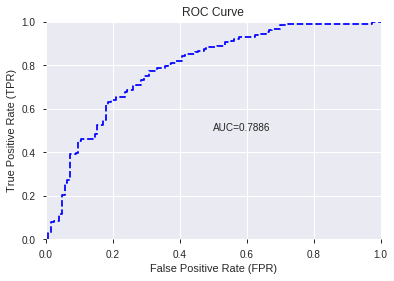

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


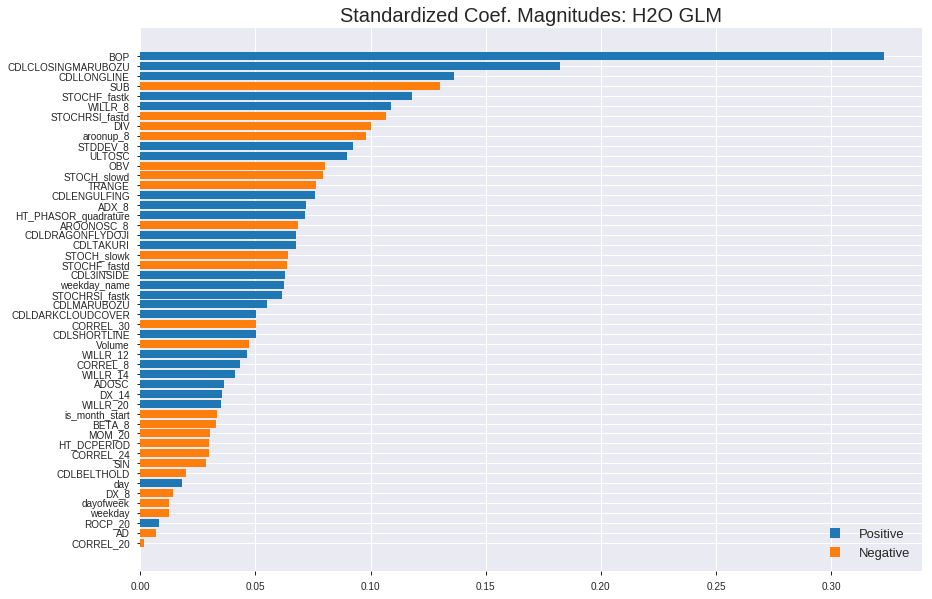

'log_likelihood'
--2019-08-26 17:20:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


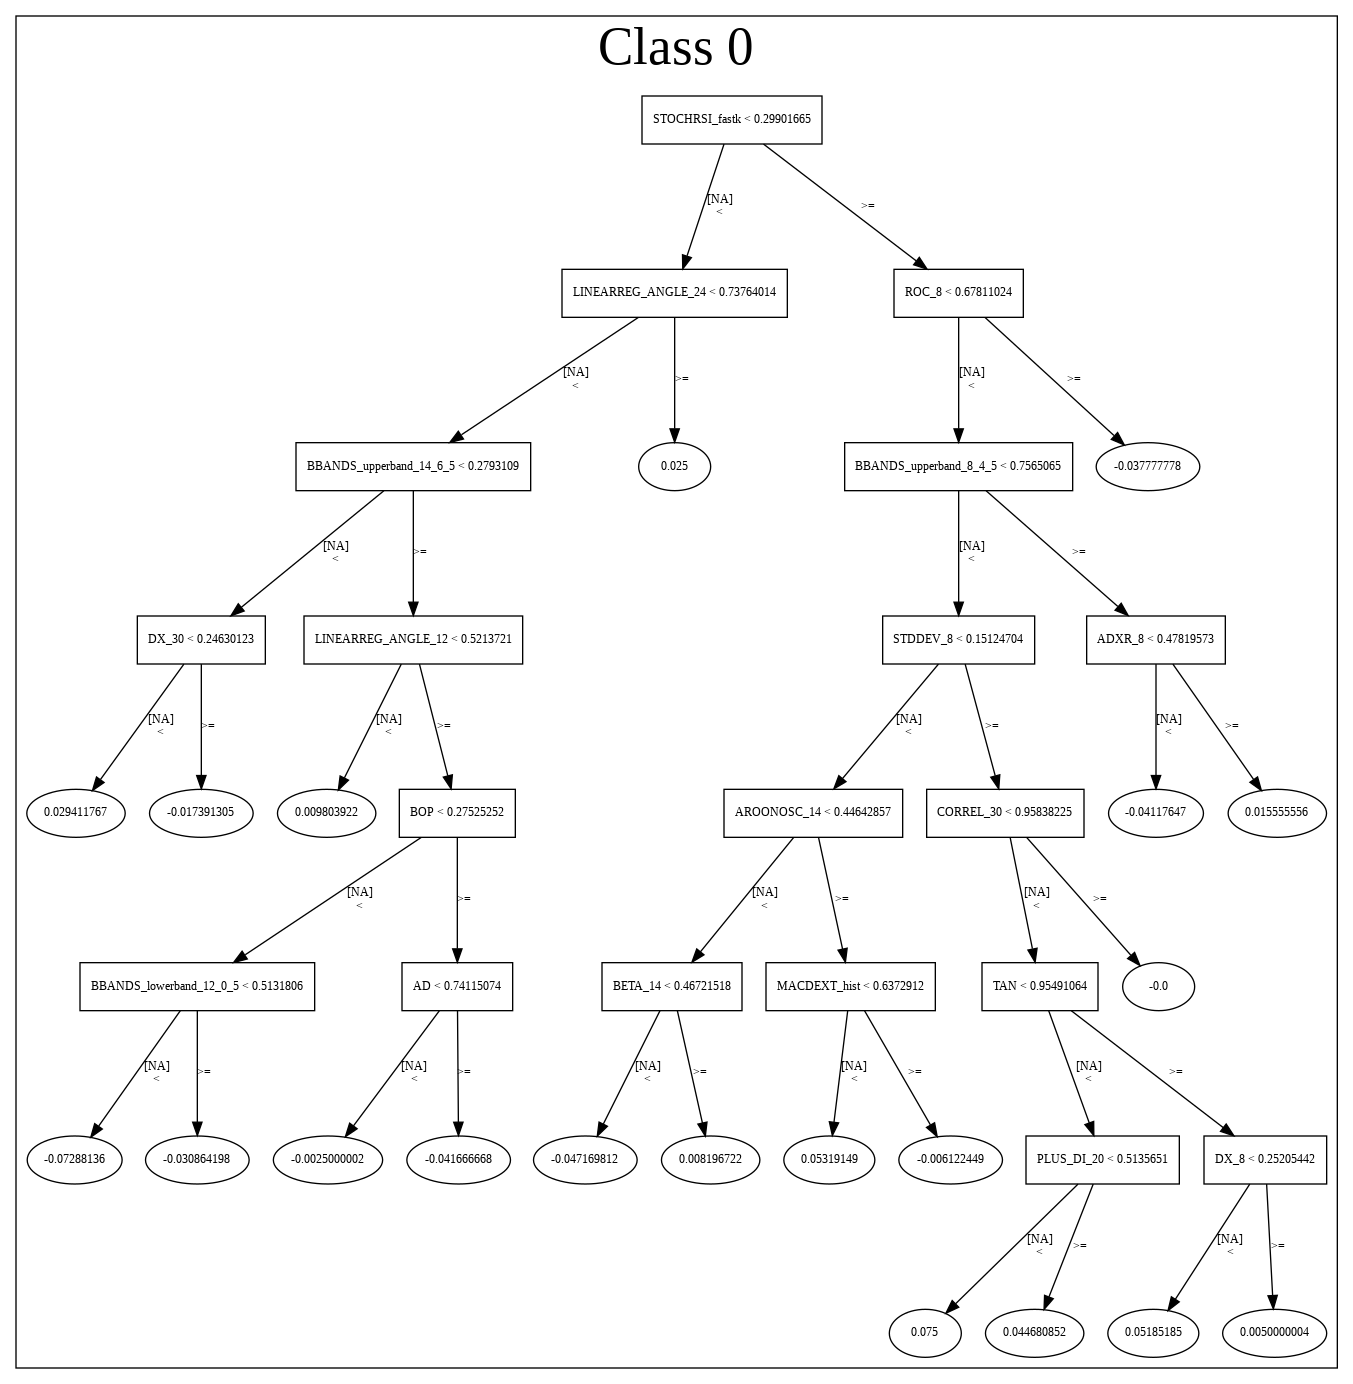

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_172052_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_172052_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCHRSI_fastd',
 'DIV',
 'aroonup_8',
 'STDDEV_8',
 'ULTOSC',
 'OBV',
 'STOCH_slowd',
 'TRANGE',
 'CDLENGULFING',
 'ADX_8',
 'HT_PHASOR_quadrature',
 'AROONOSC_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDL3INSIDE',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CORREL_30',
 'CDLSHORTLINE',
 'Volume',
 'WILLR_12',
 'CORREL_8',
 'WILLR_14',
 'ADOSC',
 'DX_14',
 'WILLR_20',
 'is_month_start',
 'BETA_8',
 'MOM_20',
 'HT_DCPERIOD',
 'CORREL_24',
 'SIN',
 'CDLBELTHOLD',
 'day',
 'DX_8',
 'dayofweek',
 'weekday',
 'ROCP_20',
 'AD',
 'CORREL_20']

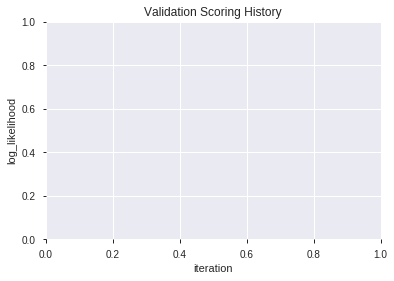

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_172102_model_6  0.792175  0.559356              0.257940  0.432992  0.187482
1  XGBoost_grid_1_AutoML_20190826_172102_model_1  0.787157  0.564369              0.278582  0.436156  0.190232
2  XGBoost_grid_1_AutoML_20190826_172102_model_7  0.781885  0.564330              0.282647  0.436070  0.190157
3  XGBoost_grid_1_AutoML_20190826_172102_model_2  0.780297  0.567828              0.295795  0.437650  0.191538
4               XGBoost_2_AutoML_20190826_172102  0.773310  0.571263              0.274200  0.440125  0.193710
5  XGBoost_grid_1_AutoML_20190826_172102_model_4  0.769245  0.575997              0.282806  0.442376  0.195697
6               XGBoost_1_AutoML_20190826_172102  0.768547  0.572958              0.282171  0.440958  0.194444
7               XGBoost_3_AutoML_20190826_172102  0.767467  0.577598              0.303608  0.442719  0.196000
8  XGBoost_grid_1_AutoML_20190826_172102_model_3  0.757304  0.580994              0.311420  0.444921  0.197955
9  XGBoost_grid_1_AutoML_20190826_172102_model_5  0.747459  0.592299              0.324092  0.449459  0.202013

variable  relative_importance  scaled_importance  percentage
0                    BOP          1999.769897           1.000000    0.197908
1                  DX_14           414.232880           0.207140    0.040995
2           STOCHF_fastk           392.865845           0.196456    0.038880
3                    DIV           376.294556           0.188169    0.037240
4                    SUB           366.686615           0.183364    0.036289
5                 Volume           356.194855           0.178118    0.035251
6                    OBV           312.712524           0.156374    0.030948
7                     AD           267.145782           0.133588    0.026438
8                  ADOSC           265.976379           0.133003    0.026322
9               CORREL_8           263.059723           0.131545    0.026034
10           STOCH_slowk           251.897507           0.125963    0.024929
11  HT_PHASOR_quadrature           250.186615           0.125108    0.024760
12               WILLR_8           249.665710           0.124847    0.024708
13        STOCHRSI_fastd           248.030731           0.124030    0.024546
14              STDDEV_8           238.873795           0.119451    0.023640
15                 ADX_8           238.445099           0.119236    0.023598
16                   SIN           225.675461           0.112851    0.022334
17                  DX_8           219.377167           0.109701    0.021711
18             CORREL_30           210.196579           0.105110    0.020802
19           HT_DCPERIOD           205.909927           0.102967    0.020378
20                TRANGE           202.566010           0.101295    0.020047
21             aroonup_8           199.029221           0.099526    0.019697
22           STOCH_slowd           185.127670           0.092574    0.018321
23                BETA_8           170.703583           0.085362    0.016894
24    CDLCLOSINGMARUBOZU           169.999603           0.085010    0.016824
25                   day           169.928833           0.084974    0.016817
26                ULTOSC           165.134933           0.082577    0.016343
27             CORREL_20           157.032715           0.078525    0.015541
28              WILLR_12           152.346222           0.076182    0.015077
29               ROCP_20           151.182327           0.075600    0.014962
30             CORREL_24           135.797501           0.067907    0.013439
31                MOM_20           122.724640           0.061369    0.012145
32              WILLR_20           101.005791           0.050509    0.009996
33             dayofweek            97.432762           0.048722    0.009642
34        STOCHRSI_fastk            95.273918           0.047642    0.009429
35              WILLR_14            94.116287           0.047064    0.009314
36            AROONOSC_8            88.044044           0.044027    0.008713
37           CDLLONGLINE            77.330711           0.038670    0.007653
38          weekday_name            70.167542           0.035088    0.006944
39          STOCHF_fastd            55.485577           0.027746    0.005491
40           CDLBELTHOLD            46.437943           0.023222    0.004596
41               weekday            16.210056           0.008106    0.001604
42      CDLDRAGONFLYDOJI            13.044633           0.006523    0.001291
43           CDLMARUBOZU             7.650581           0.003826    0.000757
44          CDLSHORTLINE             7.572556           0.003787    0.000749

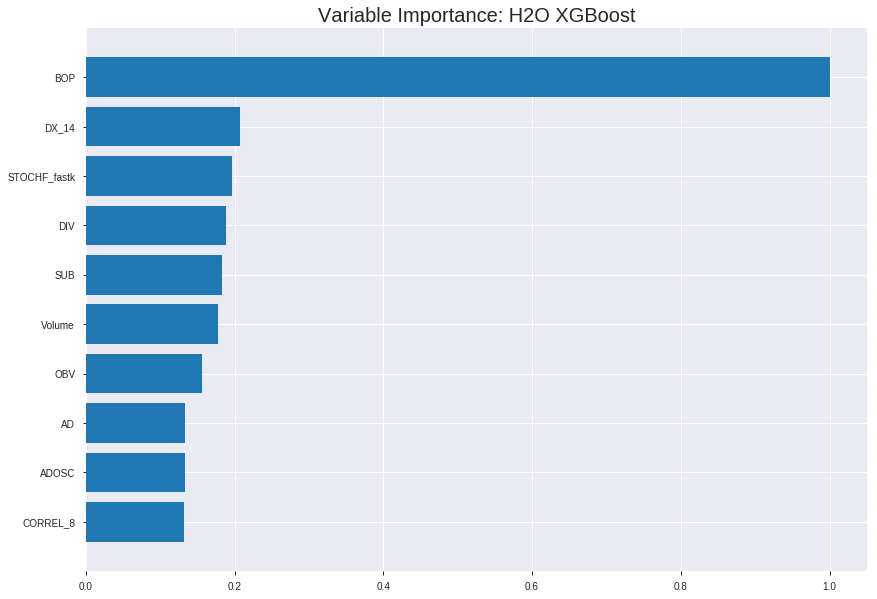

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_172102_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13759520632430886
RMSE: 0.37093827832175646
LogLoss: 0.442433493675455
Mean Per-Class Error: 0.16769819872621428
AUC: 0.9240951301788249
pr_auc: 0.9315298467098645
Gini: 0.8481902603576499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44844146569569904: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      603  252   0.2947   (252.0/855.0)
1      62   836   0.069    (62.0/898.0)
Total  665  1088  0.1791   (314.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448441     0.841893  231
max f2                       0.359941     0.902835  272
max f0point5                 0.625918     0.866235  142
max accuracy                 0.545836     0.831717  183
max precision                0.932064     1         0
max recall                   0.213022     1         340
max specificity              0.932064     1         0
max absolute_mcc             0.57185      0.666871  169
max min_per_class_accuracy   0.530681     0.826281  191
max mean_per_class_accuracy  0.545836     0.832302  183

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.903646           1.95212    1.95212            1                0.916403  1                           0.916403            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.884687           1.95212    1.95212            1                0.893368  1                           0.904886            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.870684           1.95212    1.95212            1                0.878658  1                           0.896473            0.018931        0.05902                    95.2116   95.2116
    4        0.040502                    0.858319           1.95212    1.95212            1                0.864124  1                           0.888272            0.0200445       0.0790646                  95.2116   95.2116
    5        0.0501997                   0.845233           1.95212    1.95212            1                0.851146  1                           0.8811              0.018931        0.0979955                  95.2116   95.2116
    6        0.100399                    0.795161           1.95212    1.95212            1                0.820641  1                           0.85087             0.0979955       0.195991                   95.2116   95.2116
    7        0.150029                    0.756963           1.92968    1.94469            0.988506         0.775571  0.996198                    0.825961            0.0957684       0.291759                   92.9678   94.4693
    8        0.200228                    0.728541           1.95212    1.94655            1                0.742068  0.997151                    0.804928            0.0979955       0.389755                   95.2116   94.6554
    9        0.300057                    0.665572           1.77364    1.88902            0.908571         0.695223  0.967681                    0.76843             0.17706         0.566815                   77.3637   88.9025
    10       0.399886                    0.593476           1.4613     1.78225            0.748571         0.62863   0.912981                    0.733529            0.14588         0.712695                   46.1298   78.2246
    11       0.500285                    0.534283           1.08697    1.64272            0.556818         0.564354  0.841505                    0.699579            0.109131        0.821826                   8.69736   64.2715
    12       0.600114                    0.4636             0.903551   1.51976            0.462857         0.501355  0.778517                    0.666604            0.0902004       0.912027                   -9.64493  51.9756
    13       0.699943                    0.381245           0.524283   1.37778            0.268571         0.422393  0.705786                    0.631774            0.0523385       0.964365                   -47.5717  37.7777
    14       0.799772                    0.283911           0.301184   1.24339            0.154286         0.334159  0.636947                    0.594625            0.0300668       0.994432                   -69.8816  24.3395
    15       0.899601                    0.180039           0.0557747  1.1116             0.0285714        0.233644  0.569436                    0.554567            0.00556793      1                          -94.4225  11.1604
    16       1                           0.0673345          0          1                  0                0.125802  0.512265                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2099589173853301
RMSE: 0.45821274249559024
LogLoss: 0.6046907348734996
Mean Per-Class Error: 0.31714559386973185
AUC: 0.7335967432950191
pr_auc: 0.7503980163704818
Gini: 0.46719348659003823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28919626772403717: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      50   190  0.7917   (190.0/240.0)
1      9    252  0.0345   (9.0/261.0)
Total  59   442  0.3972   (199.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289196     0.716927  345
max f2                       0.22327      0.856574  362
max f0point5                 0.610956     0.705664  158
max accuracy                 0.564756     0.680639  194
max precision                0.920327     1         0
max recall                   0.119664     1         391
max specificity              0.920327     1         0
max absolute_mcc             0.610956     0.37185   158
max min_per_class_accuracy   0.561589     0.679167  196
max mean_per_class_accuracy  0.610956     0.682854  158

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 54.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.881154           1.91954   1.91954            1                0.901758  1                           0.901758            0.0229885       0.0229885                  91.954     91.954
    2        0.0219561                   0.855717           1.91954   1.91954            1                0.867338  1                           0.886113            0.0191571       0.0421456                  91.954     91.954
    3        0.0319361                   0.837495           1.91954   1.91954            1                0.84414   1                           0.872996            0.0191571       0.0613027                  91.954     91.954
    4        0.0419162                   0.823169           1.53563   1.82813            0.8              0.826491  0.952381                    0.861924            0.0153257       0.0766284                  53.5632    82.8134
    5        0.0518962                   0.800889           1.15172   1.69805            0.6              0.809707  0.884615                    0.851882            0.0114943       0.0881226                  15.1724    69.8055
    6        0.101796                    0.764142           1.76598   1.73135            0.92             0.778932  0.901961                    0.816122            0.0881226       0.176245                   76.5977    73.135
    7        0.151697                    0.744212           1.45885   1.64171            0.76             0.753027  0.855263                    0.795367            0.0727969       0.249042                   45.8851    64.1712
    8        0.201597                    0.721544           1.45885   1.59645            0.76             0.733098  0.831683                    0.779954            0.0727969       0.321839                   45.8851    59.6449
    9        0.301397                    0.662562           1.19011   1.4619             0.62             0.690052  0.761589                    0.750185            0.118774        0.440613                   19.0115    46.1901
    10       0.401198                    0.612424           1.30529   1.42294            0.68             0.636849  0.741294                    0.721992            0.130268        0.570881                   30.5287    42.2943
    11       0.500998                    0.570043           0.998161  1.33832            0.52             0.592113  0.697211                    0.69612             0.0996169       0.670498                   -0.183908  33.8325
    12       0.600798                    0.513996           0.882989  1.26269            0.46             0.537589  0.657807                    0.669786            0.0881226       0.758621                   -11.7011   26.2688
    13       0.700599                    0.459447           0.575862  1.16485            0.3              0.48925   0.606838                    0.644068            0.0574713       0.816092                   -42.4138   16.4849
    14       0.800399                    0.375797           0.767816  1.11534            0.4              0.418819  0.581047                    0.615982            0.0766284       0.89272                    -23.2184   11.5344
    15       0.9002                      0.257618           0.806207  1.08107            0.42             0.324396  0.563193                    0.583656            0.0804598       0.97318                    -19.3793   8.10714
    16       1                           0.0680646          0.268736  1                  0.14             0.175106  0.520958                    0.54


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:21:12  6.001 sec   0                  0.5              0.693147            0.5             0                  1                0.487735                         0.5                0.693147              0.5               0                    1                  0.479042
    2019-08-26 17:21:12  6.060 sec   5                  0.47416          0.642456            0.826781        0.831152           1.95212          0.264119                         0.487102           0.667529              0.691475          0.702012             1.91954            0.381238
    2019-08-26 17:21:12  6.117 sec   10                 0.454368         0.604321            0.84746         0.853638           1.95212          0.243582                         0.4778             0.648879              0.704877          0.720393             1.91954            0.371257
    2019-08-26 17:21:12  6.171 sec   15                 0.439053         0.574668            0.855108        0.864072           1.95212          0.244153                         0.470067           0.63331               0.724505          0.743495             1.91954            0.371257
    2019-08-26 17:21:12  6.213 sec   20                 0.426665         0.550454            0.864653        0.875506           1.95212          0.239589                         0.466039           0.624681              0.728512          0.751068             1.91954            0.381238
    2019-08-26 17:21:12  6.255 sec   25                 0.417506         0.532156            0.870841        0.880926           1.95212          0.236167                         0.462943           0.617671              0.728624          0.750345             1.91954            0.393214
    2019-08-26 17:21:12  6.298 sec   30                 0.409382         0.515959            0.87942         0.887819           1.95212          0.222476                         0.460469           0.612103              0.730995          0.747643             1.91954            0.387226
    2019-08-26 17:21:12  6.341 sec   35                 0.401836         0.500823            0.888074        0.897097           1.95212          0.21563                          0.459453           0.609372              0.73299           0.752091             1.91954            0.399202
    2019-08-26 17:21:12  6.387 sec   40                 0.394434         0.486455            0.897846        0.906347           1.95212          0.20194                          0.459223           0.608455              0.731458          0.74985              1.91954            0.397206
    2019-08-26 17:21:12  6.431 sec   45                 0.388186         0.47467             0.905386        0.913611           1.95212          0.196235                         0.459151           0.607839              0.730452          0.749275             1.91954            0.397206
    2019-08-26 17:21:12  6.485 sec   50                 0.382281         0.463305            0.911463        0.919556           1.95212          0.188819                         0.45919            0.607496              0.731122          0.750925             1.91954            0.399202
    2019-08-26 17:21:12  6.531 sec   55                 0.376575         0.452674            0.91826         0.926267           1.95212          0.180833                         0.458758           0.606271              0.732008          0

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ---------------------
BOP               1999.7698974609375     1.0                    0.1979079941587089
DX_14             414.2328796386719      0.20714027157055118    0.040994715656018026
STOCHF_fastk      392.8658447265625      0.19645552482081832    0.03888011885868461
DIV               376.2945556640625      0.1881689269059581     0.037240134886954886
SUB               366.6866149902344      0.18336440380256153    0.03628928135667249
---               ---                    ---                    ---
CDLBELTHOLD       46.43794250488281      0.023221642931941327   0.004595748773730268
weekday           16.21005630493164      0.008105960753541286   0.0016042344334625726
CDLDRAGONFLYDOJI  13.044632911682129     0.006523066942974091   0.0012909670944469837
CDLMARUBOZU       7.650581359863281      0.0038257308351211062  0.0007571427157699405
CDLSHORTLINE      7.5725555419921875     0.003786713437184393   0.0007494208608069934


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7450199203187251)

('F1', 0.7808219178082191)

('auc', 0.7921747967479674)

('logloss', 0.5593561418431721)

('mean_per_class_error', 0.2579395325203252)

('rmse', 0.4329920661909672)

('mse', 0.18748212938432293)

xgboost prediction progress: |████████████████████████████████████████████| 100%


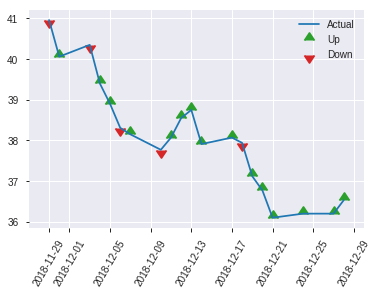


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18748212938432293
RMSE: 0.4329920661909672
LogLoss: 0.5593561418431721
Mean Per-Class Error: 0.2579395325203252
AUC: 0.7921747967479674
pr_auc: 0.7321768577867775
Gini: 0.5843495934959348
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47330212593078613: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   50   0.4065   (50.0/123.0)
1      14   114  0.1094   (14.0/128.0)
Total  87   164  0.255    (64.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473302     0.780822  163
max f2                       0.320309     0.870787  199
max f0point5                 0.580785     0.751689  115
max accuracy                 0.473302     0.74502   163
max precision                0.751856     0.863636  43
max recall                   0.179861     1         234
max specificity              0.902343     0.99187   0
max absolute_mcc             0.473302     0.508546  163
max min_per_class_accuracy   0.567005     0.715447  126
max mean_per_class_accuracy  0.473302     0.74206   163

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 53.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.884174           1.30729    1.30729            0.666667         0.894275  0.666667                    0.894275            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.874584           1.30729    1.30729            0.666667         0.878389  0.666667                    0.886332            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.863259           0.980469   1.22559            0.5              0.868897  0.625                       0.881974            0.0078125       0.0390625                  -1.95312  22.5586
    4        0.0438247                   0.850116           0.653646   1.0696             0.333333         0.854215  0.545455                    0.874403            0.0078125       0.046875                   -34.6354  6.96023
    5        0.0517928                   0.845695           1.96094    1.20673            1                0.847514  0.615385                    0.870266            0.015625        0.0625                     96.0938   20.6731
    6        0.103586                    0.812407           1.8101     1.50841            0.923077         0.827012  0.769231                    0.848639            0.09375         0.15625                    81.0096   50.8413
    7        0.151394                    0.765689           1.96094    1.65132            1                0.791077  0.842105                    0.830462            0.09375         0.25                       96.0938   65.1316
    8        0.203187                    0.730062           1.35757    1.57644            0.692308         0.747964  0.803922                    0.809433            0.0703125       0.320312                   35.7572   57.644
    9        0.302789                    0.658721           1.33344    1.4965             0.68             0.696606  0.763158                    0.772319            0.132812        0.453125                   33.3438   49.6505
    10       0.40239                     0.606943           1.41187    1.47556            0.72             0.628249  0.752475                    0.736658            0.140625        0.59375                    41.1875   47.5557
    11       0.501992                    0.569848           1.17656    1.41623            0.6              0.586168  0.722222                    0.706799            0.117188        0.710938                   17.6562   41.6233
    12       0.601594                    0.504546           1.09813    1.36357            0.56             0.533646  0.695364                    0.678131            0.109375        0.820312                   9.8125    36.3566
    13       0.701195                    0.433863           0.862812   1.29244            0.44             0.468743  0.659091                    0.648388            0.0859375       0.90625                    -13.7188  29.2436
    14       0.800797                    0.320095           0.6275     1.20973            0.32             0.366145  0.616915                    0.613283            0.0625          0.96875                    -37.25    20.9733
    15       0.900398                    0.208725           0.235313   1.10194            0.12             0.272395  0.561947                    0.575575            0.0234375       0.992188                   -76.4688  10.1943
    16       1                           0.0865577          0.0784375  1                  0.04             0.154312  0.50996                     

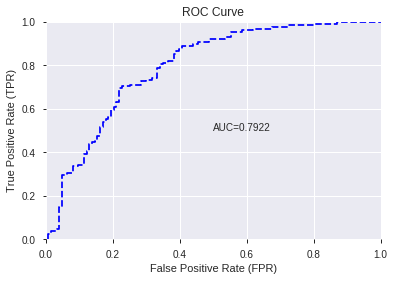

This function is available for GLM models only


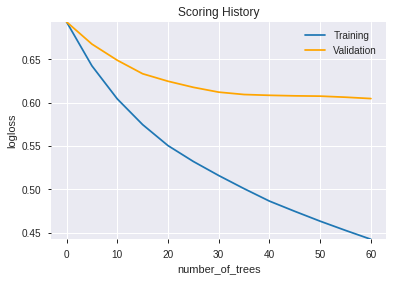

--2019-08-26 17:21:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

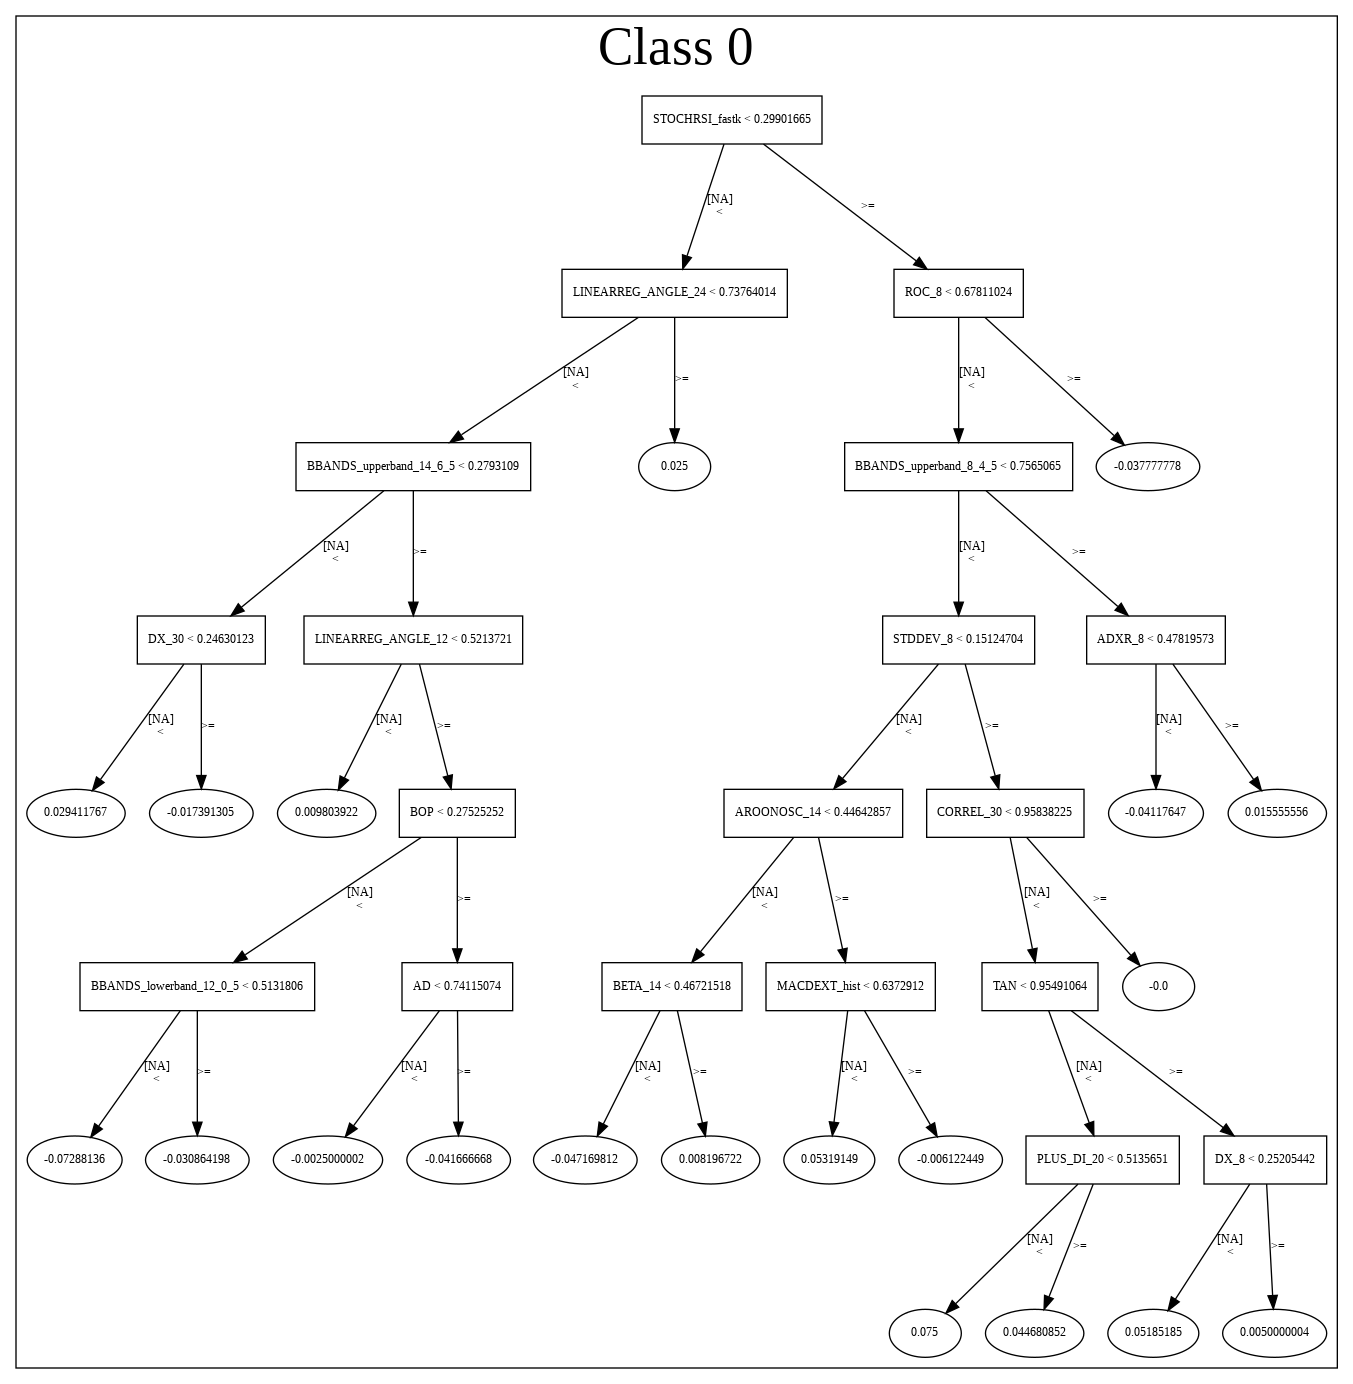

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_172102_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_172102_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DX_14',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'Volume',
 'OBV',
 'AD',
 'ADOSC',
 'CORREL_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'ADX_8',
 'SIN',
 'DX_8',
 'CORREL_30',
 'HT_DCPERIOD',
 'TRANGE',
 'aroonup_8',
 'STOCH_slowd',
 'BETA_8',
 'CDLCLOSINGMARUBOZU',
 'day',
 'ULTOSC',
 'CORREL_20',
 'WILLR_12',
 'ROCP_20',
 'CORREL_24',
 'MOM_20',
 'WILLR_20',
 'dayofweek',
 'STOCHRSI_fastk',
 'WILLR_14',
 'AROONOSC_8',
 'CDLLONGLINE',
 'weekday_name',
 'STOCHF_fastd',
 'CDLBELTHOLD',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLMARUBOZU',
 'CDLSHORTLINE']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_172124_model_1  0.788046  0.581589              0.281536  0.442637  0.195928

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.213918           1.000000  3.483731e-02
1           CDLCLOSINGMARUBOZU             0.134266           0.627651  2.186568e-02
2                  CDLLONGLINE             0.113220           0.529266  1.843822e-02
3                          SUB             0.098109           0.458630  1.597742e-02
4                 STOCHF_fastk             0.078013           0.364685  1.270463e-02
...                        ...                  ...                ...           ...
1038                    EMA_20             0.000006           0.000028  9.858054e-07
1039                   MA_14_1             0.000004           0.000021  7.289064e-07
1040  BBANDS_middleband_12_1_4             0.000004           0.000019  6.569571e-07
1041  BBANDS_middleband_14_1_2             0.000003           0.000014  4.934468e-07
1042  BBANDS_middleband_24_1_2             0.000003           0.000012  4.217490e-07

[1043 rows x 4 columns]

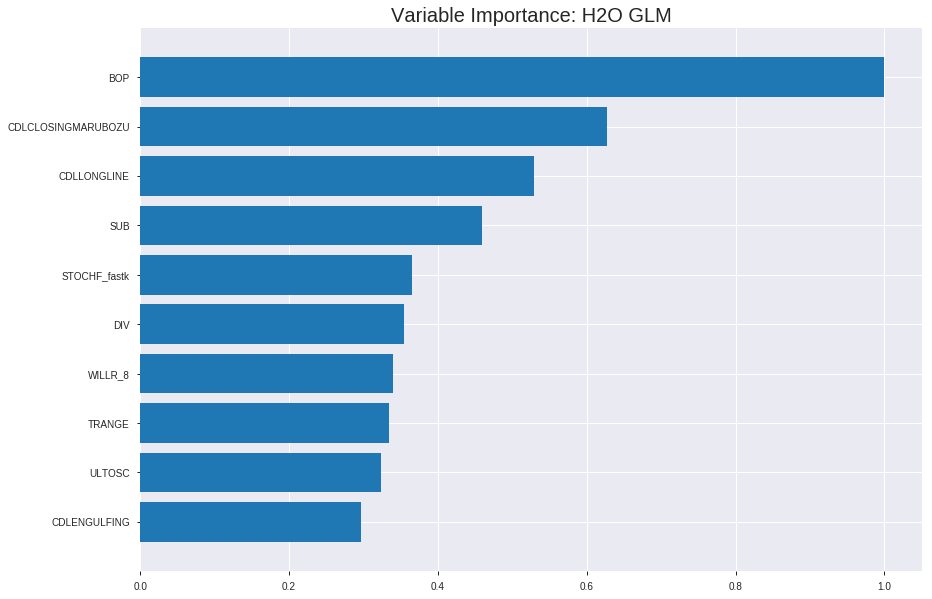

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_172124_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19502457719182745
RMSE: 0.441615870629473
LogLoss: 0.5738706417957395
Null degrees of freedom: 1752
Residual degrees of freedom: 709
Null deviance: 2429.1191459812417
Residual deviance: 2011.9904701358628
AIC: 4099.990470135863
AUC: 0.7805402518917933
pr_auc: 0.7832801251066642
Gini: 0.5610805037835866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4161151042767003: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      406  449   0.5251   (449.0/855.0)
1      98   800   0.1091   (98.0/898.0)
Total  504  1249  0.312    (547.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416115     0.745226  258
max f2                       0.206319     0.85078   360
max f0point5                 0.534488     0.721085  184
max accuracy                 0.534488     0.707929  184
max precision                0.914406     1         0
max recall                   0.175259     1         370
max specificity              0.914406     1         0
max absolute_mcc             0.534488     0.418092  184
max min_per_class_accuracy   0.518749     0.706013  194
max mean_per_class_accuracy  0.534488     0.708762  184

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.858048           1.95212   1.95212            1                0.881514  1                           0.881514            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.837843           1.84366   1.89789            0.944444         0.845825  0.972222                    0.863669            0.018931        0.0389755                  84.3665   89.789
    3        0.0302339                   0.821044           1.95212   1.91528            1                0.828816  0.981132                    0.85249             0.018931        0.0579065                  95.2116   91.5283
    4        0.040502                    0.807831           1.84366   1.89713            0.944444         0.813445  0.971831                    0.842591            0.018931        0.0768374                  84.3665   89.7127
    5        0.0501997                   0.791693           1.72246   1.86338            0.882353         0.8003    0.954545                    0.834421            0.0167038       0.0935412                  72.2455   86.3383
    6        0.100399                    0.735331           1.77465   1.81902            0.909091         0.761269  0.931818                    0.797845            0.0890869       0.182628                   77.4651   81.9017
    7        0.150029                    0.704312           1.36872   1.67006            0.701149         0.718013  0.855513                    0.771437            0.0679287       0.250557                   36.8725   67.0061
    8        0.200228                    0.669819           1.53064   1.63511            0.784091         0.686603  0.837607                    0.750168            0.0768374       0.327394                   53.0636   63.5106
    9        0.300057                    0.622147           1.41668   1.56243            0.725714         0.646408  0.80038                     0.715647            0.141425        0.46882                    41.6678   56.2435
    10       0.399886                    0.570742           1.19358   1.47035            0.611429         0.596091  0.75321                     0.685801            0.119154        0.587973                   19.3579   47.0353
    11       0.500285                    0.520552           1.14243   1.40454            0.585227         0.544736  0.719498                    0.657491            0.114699        0.702673                   14.2431   40.4544
    12       0.600114                    0.474948           0.937016  1.32677            0.48             0.498193  0.679658                    0.630992            0.0935412       0.796214                   -6.29844  32.6771
    13       0.699943                    0.421148           0.803156  1.25209            0.411429         0.448737  0.641402                    0.604998            0.0801782       0.876392                   -19.6844  25.2091
    14       0.799772                    0.350224           0.613522  1.17238            0.314286         0.388793  0.600571                    0.578011            0.0612472       0.937639                   -38.6478  17.2383
    15       0.899601                    0.258675           0.368113  1.08313            0.188571         0.305997  0.554851                    0.547826            0.0367483       0.974388                   -63.1887  8.31334
    16       1                           0.0496249          0.255106  1                  0.130682         0.193632  0.512265                    0.512265          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21447086668651041
RMSE: 0.4631099941552875
LogLoss: 0.6172966299666808
Null degrees of freedom: 500
Residual degrees of freedom: -543
Null deviance: 693.804571947685
Residual deviance: 618.5312232266141
AIC: 2706.531223226614
AUC: 0.7172892720306513
pr_auc: 0.7102360949203104
Gini: 0.4345785440613026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2933264737482718: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      45   195  0.8125   (195.0/240.0)
1      5    256  0.0192   (5.0/261.0)
Total  50   451  0.3992   (200.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293326     0.719101  355
max f2                       0.293326     0.856187  355
max f0point5                 0.553722     0.680794  171
max accuracy                 0.476994     0.668663  238
max precision                0.890059     1         0
max recall                   0.175116     1         385
max specificity              0.890059     1         0
max absolute_mcc             0.476994     0.336064  238
max min_per_class_accuracy   0.527647     0.658333  196
max mean_per_class_accuracy  0.476994     0.664727  238

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.860087           1.59962   1.59962            0.833333         0.873577  0.833333                    0.873577            0.0191571       0.0191571                  59.9617   59.9617
    2        0.0219561                   0.82927            1.53563   1.57053            0.8              0.836257  0.818182                    0.856613            0.0153257       0.0344828                  53.5632   57.0533
    3        0.0319361                   0.818127           1.53563   1.55963            0.8              0.824771  0.8125                      0.846663            0.0153257       0.0498084                  53.5632   55.9626
    4        0.0419162                   0.798163           0.767816  1.3711             0.4              0.806016  0.714286                    0.836985            0.00766284      0.0574713                  -23.2184  37.11
    5        0.0518962                   0.779555           1.91954   1.47657            1                0.78627   0.769231                    0.827232            0.0191571       0.0766284                  91.954    47.6569
    6        0.101796                    0.713621           1.53563   1.50552            0.8              0.743954  0.784314                    0.78641             0.0766284       0.153257                   53.5632   50.5522
    7        0.151697                    0.686437           1.76598   1.5912             0.92             0.699459  0.828947                    0.757807            0.0881226       0.241379                   76.5977   59.1198
    8        0.201597                    0.656823           1.45885   1.55844            0.76             0.672633  0.811881                    0.736725            0.0727969       0.314176                   45.8851   55.8439
    9        0.301397                    0.610766           1.19011   1.43648            0.62             0.633033  0.748344                    0.70239             0.118774        0.43295                    19.0115   43.6477
    10       0.401198                    0.559488           1.03655   1.33699            0.54             0.581861  0.696517                    0.672408            0.103448        0.536398                   3.65517   33.6993
    11       0.500998                    0.529475           1.15172   1.30009            0.6              0.542501  0.677291                    0.64653             0.114943        0.651341                   15.1724   30.0087
    12       0.600798                    0.476994           1.07494   1.26269            0.56             0.505973  0.657807                    0.623181            0.10728         0.758621                   7.49425   26.2688
    13       0.700599                    0.423501           0.691034  1.18126            0.36             0.447152  0.615385                    0.598106            0.0689655       0.827586                   -30.8966  18.1256
    14       0.800399                    0.371681           0.691034  1.12013            0.36             0.396234  0.583541                    0.572935            0.0689655       0.896552                   -30.8966  12.0131
    15       0.9002                      0.293326           0.844598  1.08958            0.44             0.338938  0.567627                    0.546993            0.0842912       0.980843                   -15.5402  8.95838
    16       1                           0.0649771          0.191954  1                  0.1              0.203983  0.520958                    0.51276            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:21:27  0.000 sec   2            20        1028          1.35985           1.36979
    2019-08-26 17:21:29  2.032 sec   4            15        1030          1.35288           1.36471
    2019-08-26 17:21:31  4.054 sec   6            11        1034          1.34426           1.35817
    2019-08-26 17:21:33  6.089 sec   8            7.7       1044          1.33379           1.35003
    2019-08-26 17:21:35  8.088 sec   10           5.6       1044          1.32133           1.34024
    2019-08-26 17:21:37  10.123 sec  12           4.1       1044          1.30685           1.32882
    2019-08-26 17:21:39  12.138 sec  14           3         1044          1.29055           1.31603
    2019-08-26 17:21:41  14.197 sec  16           2.2       1044          1.27275           1.30226
    2019-08-26 17:21:43  16.206 sec  18           1.6       1044          1.25395           1.28815
    2019-08-26 17:21:45  18.212 sec  20           1.1       1044          1.23467           1.27436
    2019-08-26 17:21:47  20.227 sec  22           0.83      1044          1.2155            1.26166
    2019-08-26 17:21:49  22.252 sec  24           0.61      1044          1.19689           1.25077
    2019-08-26 17:21:51  24.260 sec  26           0.44      1044          1.17923           1.24233
    2019-08-26 17:21:53  26.278 sec  28           0.32      1044          1.16281           1.23683
    2019-08-26 17:21:55  28.337 sec  30           0.23      1044          1.14774           1.23459
    2019-08-26 17:21:57  30.398 sec  32           0.17      1044          1.13405           1.23571
    2019-08-26 17:21:59  32.443 sec  34           0.12      1044          1.12171           1.24017
    2019-08-26 17:22:01  34.479 sec  36           0.09      1044          1.11058           1.24786
    2019-08-26 17:22:04  36.555 sec  38           0.066     1044          1.10055           1.25861
    2019-08-26 17:22:06  38.599 sec  40           0.048     1044          1.09146           1.2722

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7370517928286853)

('F1', 0.7569444444444445)

('auc', 0.7880462398373984)

('logloss', 0.5815894734106988)

('mean_per_class_error', 0.26305259146341464)

('rmse', 0.442637206512658)

('mse', 0.19592769658932943)

glm prediction progress: |████████████████████████████████████████████████| 100%


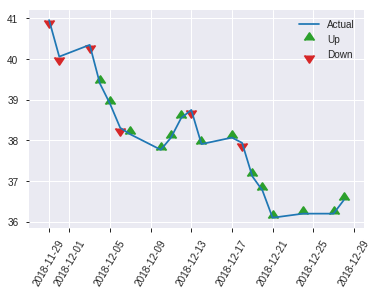


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19592769658932943
RMSE: 0.442637206512658
LogLoss: 0.5815894734106988
Null degrees of freedom: 250
Residual degrees of freedom: -793
Null deviance: 347.8656113866541
Residual deviance: 291.95791565217075
AIC: 2379.957915652171
AUC: 0.7880462398373984
pr_auc: 0.7421204722638983
Gini: 0.5760924796747968
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48057918970619884: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   51   0.4146   (51.0/123.0)
1      19   109  0.1484   (19.0/128.0)
Total  91   160  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480579     0.756944  159
max f2                       0.315217     0.869863  217
max f0point5                 0.529577     0.742188  127
max accuracy                 0.529577     0.737052  127
max precision                0.675898     0.84      49
max recall                   0.145977     1         246
max specificity              0.945435     0.99187   0
max absolute_mcc             0.529577     0.473895  127
max min_per_class_accuracy   0.532994     0.731707  126
max mean_per_class_accuracy  0.529577     0.736947  127

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.865614           0.653646   0.653646           0.333333         0.898869  0.333333                    0.898869            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.837751           1.96094    1.30729            1                0.845957  0.666667                    0.872413            0.0234375       0.03125                    96.0938   30.7292
    3        0.0318725                   0.829644           1.96094    1.4707             1                0.831319  0.75                        0.862139            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.812472           1.96094    1.6044             1                0.823475  0.818182                    0.851594            0.0234375       0.0703125                  96.0938   60.4403
    5        0.0517928                   0.797016           0.980469   1.50841            0.5              0.805353  0.769231                    0.84448             0.0078125       0.078125                   -1.95312  50.8413
    6        0.103586                    0.728748           1.50841    1.50841            0.769231         0.764193  0.769231                    0.804337            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.699906           1.79753    1.59971            0.916667         0.712874  0.815789                    0.775454            0.0859375       0.242188                   79.7526   59.9712
    8        0.203187                    0.675843           1.65925    1.61489            0.846154         0.68434   0.823529                    0.752229            0.0859375       0.328125                   65.9255   61.489
    9        0.302789                    0.631216           1.56875    1.59971            0.8              0.651855  0.815789                    0.719211            0.15625         0.484375                   56.875    59.9712
    10       0.40239                     0.589731           1.09813    1.47556            0.56             0.610812  0.752475                    0.69238             0.109375        0.59375                    9.8125    47.5557
    11       0.501992                    0.535595           1.33344    1.44736            0.68             0.565646  0.738095                    0.667234            0.132812        0.726562                   33.3438   44.7359
    12       0.601594                    0.495756           0.784375   1.33759            0.4              0.513457  0.682119                    0.641774            0.078125        0.804688                   -21.5625  33.7593
    13       0.701195                    0.434523           0.6275     1.23673            0.32             0.46839   0.630682                    0.617146            0.0625          0.867188                   -37.25    23.6728
    14       0.800797                    0.379733           0.862812   1.19022            0.44             0.406571  0.606965                    0.590955            0.0859375       0.953125                   -13.7188  19.0221
    15       0.900398                    0.286073           0.392188   1.10194            0.2              0.335876  0.561947                    0.562738            0.0390625       0.992188                   -60.7812  10.1943
    16       1                           0.081477           0.0784375  1                  0.04             0.205954  0.50996                    

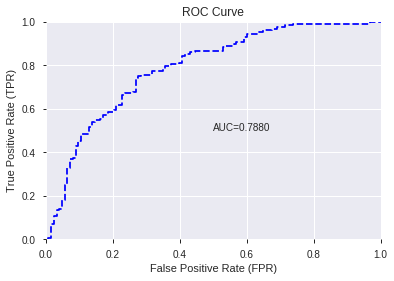

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


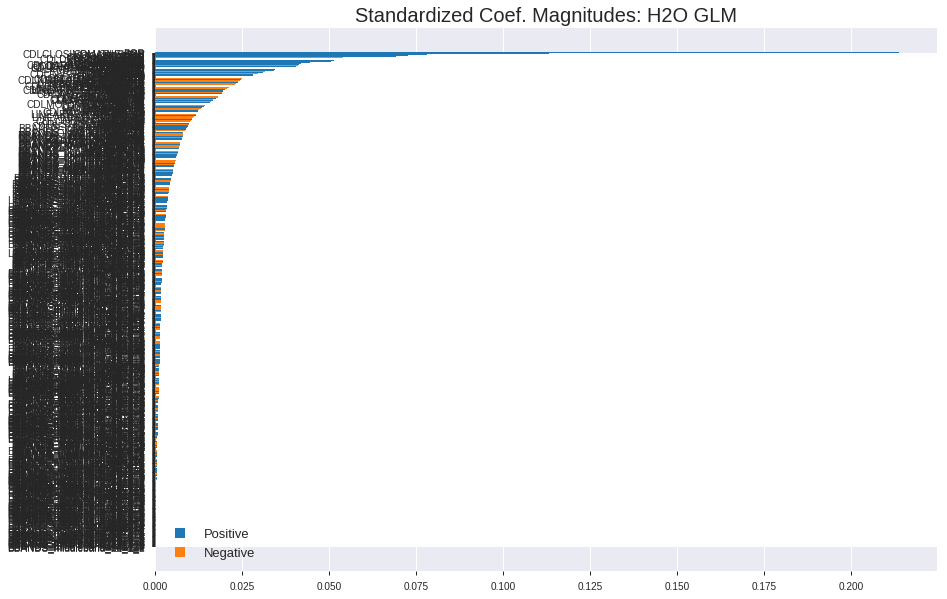

'log_likelihood'
--2019-08-26 17:22:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


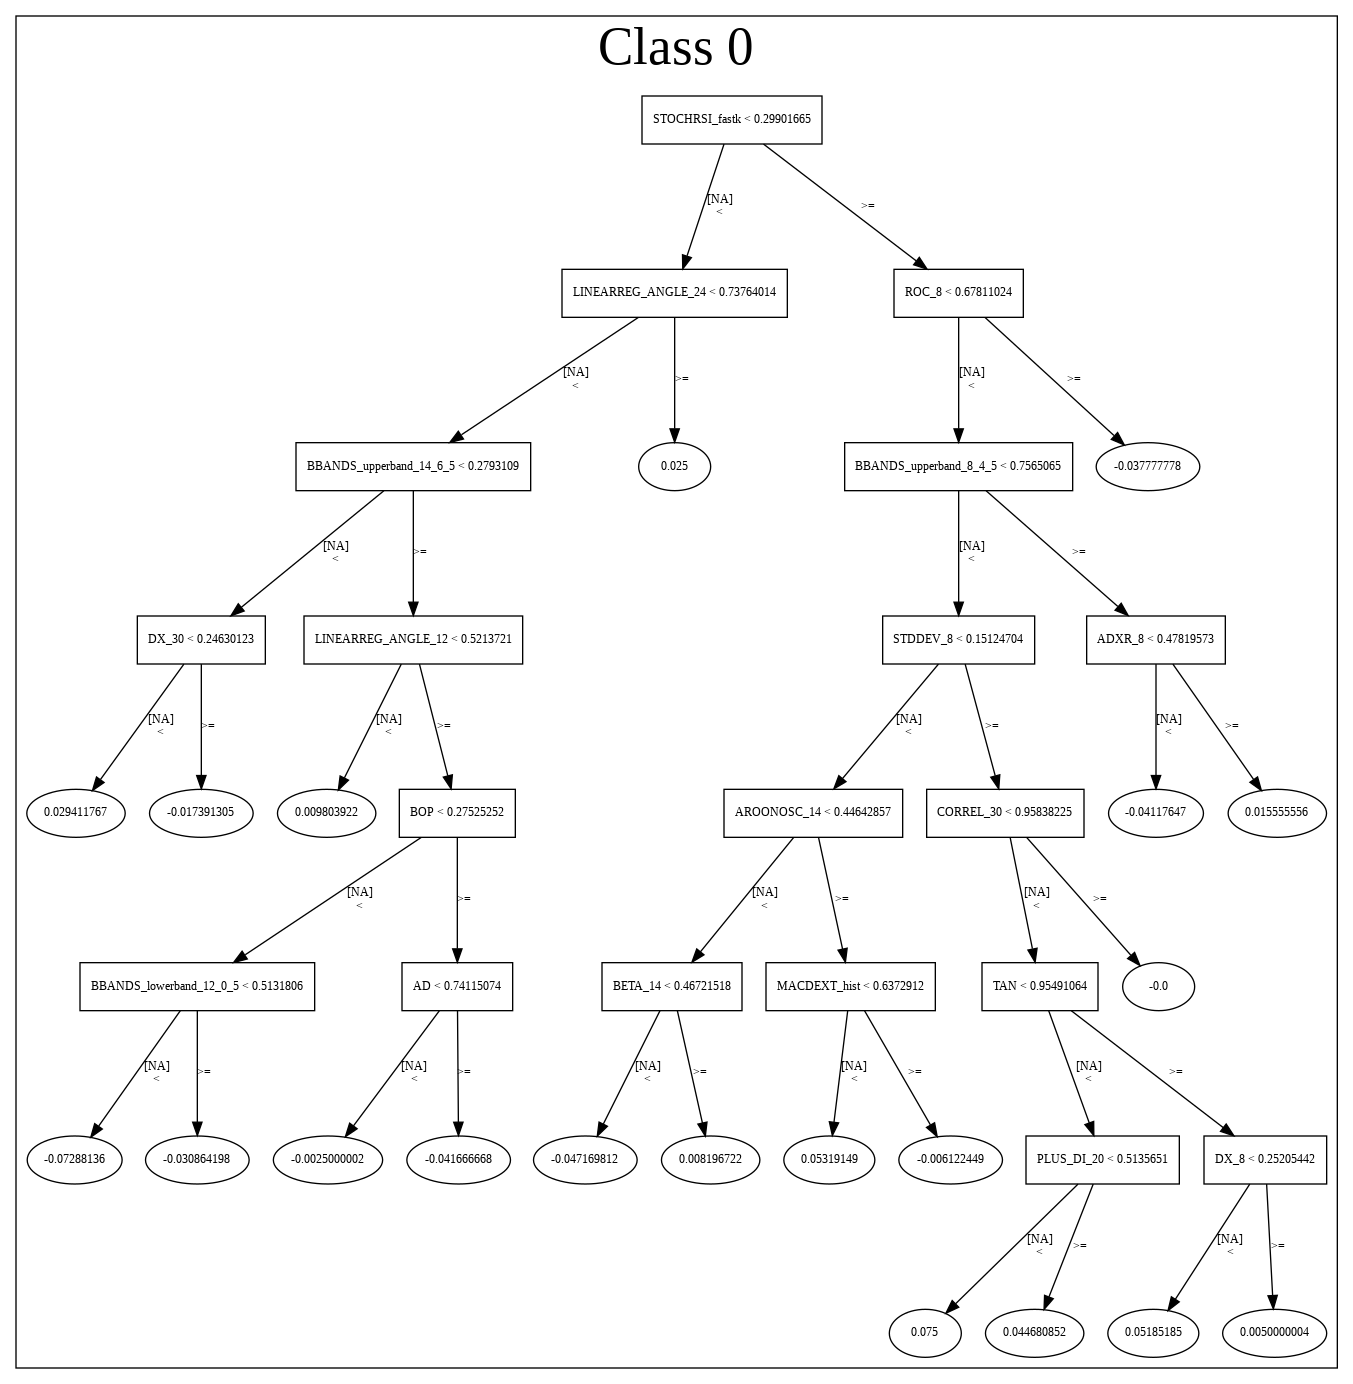

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_172124_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_172124_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

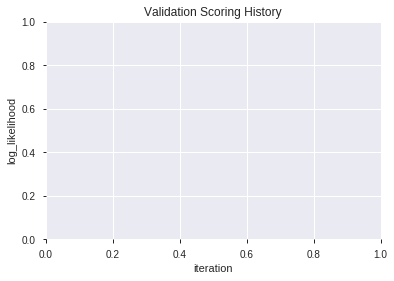

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_172231_model_2  0.783410  0.570587              0.265117  0.438890  0.192625
1  XGBoost_grid_1_AutoML_20190826_172231_model_4  0.778328  0.572075              0.290936  0.439625  0.193270
2               XGBoost_3_AutoML_20190826_172231  0.778201  0.569064              0.269341  0.438435  0.192225
3  XGBoost_grid_1_AutoML_20190826_172231_model_3  0.774390  0.576188              0.269499  0.441504  0.194926
4  XGBoost_grid_1_AutoML_20190826_172231_model_7  0.771214  0.579389              0.303608  0.442756  0.196033
5               XGBoost_2_AutoML_20190826_172231  0.767912  0.575824              0.307673  0.442546  0.195847
6  XGBoost_grid_1_AutoML_20190826_172231_model_1  0.764355  0.576809              0.269976  0.442849  0.196116
7  XGBoost_grid_1_AutoML_20190826_172231_model_6  0.764037  0.576526              0.274200  0.442420  0.195736
8  XGBoost_grid_1_AutoML_20190826_172231_model_5  0.755462  0.583526              0.261211  0.444977  0.198005
9               XGBoost_1_AutoML_20190826_172231  0.755018  0.586500              0.310944  0.447796  0.200521

variable  relative_importance  scaled_importance  percentage
0                        BOP          2280.028320           1.000000    0.246919
1                        SUB           315.960907           0.138578    0.034218
2                        DIV           298.401367           0.130876    0.032316
3               STOCHF_fastk           272.266418           0.119414    0.029486
4                    WILLR_8           163.125488           0.071545    0.017666
..                       ...                  ...                ...         ...
304  BBANDS_upperband_20_5_4             0.233879           0.000103    0.000025
305           is_quarter_end             0.184121           0.000081    0.000020
306  BBANDS_lowerband_14_0_5             0.177132           0.000078    0.000019
307   BBANDS_upperband_8_0_3             0.143868           0.000063    0.000016
308                      Low             0.136367           0.000060    0.000015

[309 rows x 4 columns]

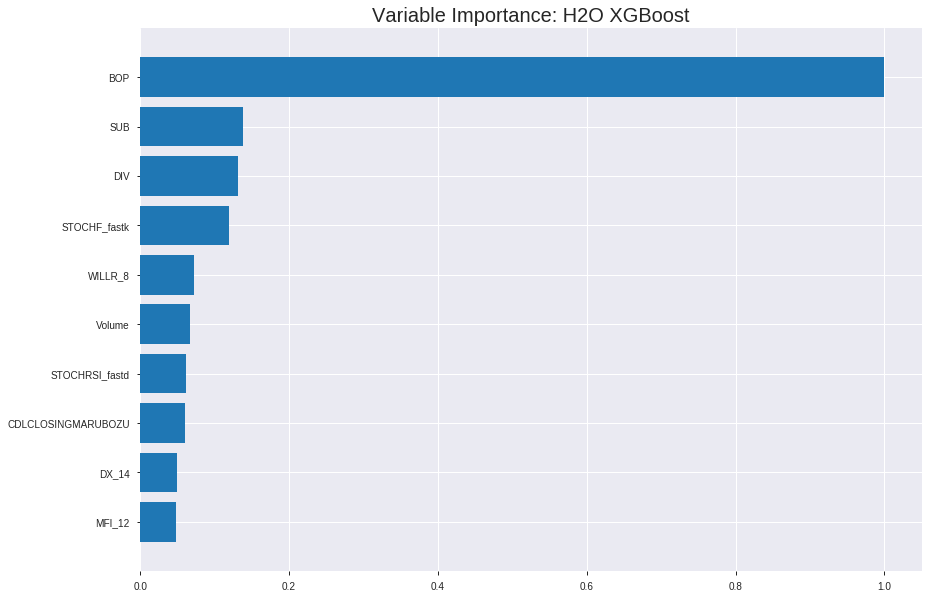

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_172231_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14354296470982866
RMSE: 0.3788706437688577
LogLoss: 0.4590781093611679
Mean Per-Class Error: 0.1750797744174839
AUC: 0.9165299105224084
pr_auc: 0.9251292522791335
Gini: 0.8330598210448168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023983816305796: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      661  194  0.2269   (194.0/855.0)
1      117  781  0.1303   (117.0/898.0)
Total  778  975  0.1774   (311.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502398     0.833956  205
max f2                       0.340041     0.897017  285
max f0point5                 0.612934     0.861875  141
max accuracy                 0.53563      0.824872  186
max precision                0.89737      1         0
max recall                   0.198916     1         355
max specificity              0.89737      1         0
max absolute_mcc             0.53563      0.649692  186
max min_per_class_accuracy   0.533132     0.824561  187
max mean_per_class_accuracy  0.53563      0.82492   186

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.864104           1.95212    1.95212            1                0.87608   1                           0.87608             0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.852735           1.95212    1.95212            1                0.857167  1                           0.866623            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.843015           1.95212    1.95212            1                0.848592  1                           0.86084             0.018931        0.05902                    95.2116   95.2116
    4        0.040502                    0.8325             1.95212    1.95212            1                0.837682  1                           0.854969            0.0200445       0.0790646                  95.2116   95.2116
    5        0.0501997                   0.8209             1.95212    1.95212            1                0.82529   1                           0.849236            0.018931        0.0979955                  95.2116   95.2116
    6        0.100399                    0.780446           1.95212    1.95212            1                0.800197  1                           0.824716            0.0979955       0.195991                   95.2116   95.2116
    7        0.150029                    0.746363           1.90724    1.93727            0.977011         0.76195   0.992395                    0.803953            0.0946548       0.290646                   90.724    93.7271
    8        0.200228                    0.714495           1.92993    1.93543            0.988636         0.729679  0.991453                    0.785332            0.096882        0.387528                   92.9933   93.5431
    9        0.300057                    0.660674           1.78479    1.88531            0.914286         0.686754  0.965779                    0.752535            0.178174        0.565702                   78.4792   88.5313
    10       0.399886                    0.598568           1.41668    1.76832            0.725714         0.630195  0.905849                    0.721993            0.141425        0.707127                   41.6678   76.8322
    11       0.500285                    0.538072           1.06479    1.62713            0.545455         0.569623  0.833523                    0.691415            0.106904        0.814031                   6.47904   62.7134
    12       0.600114                    0.468666           0.858931   1.49934            0.44             0.504715  0.768061                    0.660358            0.0857461       0.899777                   -14.1069  49.9344
    13       0.699943                    0.381458           0.568902   1.36664            0.291429         0.424162  0.700081                    0.62667             0.0567929       0.95657                    -43.1098  36.664
    14       0.799772                    0.287401           0.334648   1.23783            0.171429         0.333195  0.634094                    0.590038            0.0334076       0.989978                   -66.5352  23.7825
    15       0.899601                    0.200039           0.0892396  1.11037            0.0457143        0.24337   0.568802                    0.551568            0.00890869      0.998886                   -91.076   11.0366
    16       1                           0.102266           0.0110916  1                  0.00568182       0.156951  0.512265                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20954804851291134
RMSE: 0.4577641843929157
LogLoss: 0.6065544127241516
Mean Per-Class Error: 0.31800766283524906
AUC: 0.7329901021711367
pr_auc: 0.7408184033610242
Gini: 0.4659802043422734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2939278781414032: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      60   180  0.75     (180.0/240.0)
1      12   249  0.046    (12.0/261.0)
Total  72   429  0.3832   (192.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293928     0.721739  333
max f2                       0.17518      0.849673  385
max f0point5                 0.557949     0.695187  197
max accuracy                 0.557949     0.682635  197
max precision                0.865997     1         0
max recall                   0.163934     1         393
max specificity              0.865997     1         0
max absolute_mcc             0.557949     0.364049  197
max min_per_class_accuracy   0.563352     0.675     192
max mean_per_class_accuracy  0.557949     0.681992  197

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.826704           1.91954   1.91954            1                0.839332  1                           0.839332            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.820568           1.91954   1.91954            1                0.823323  1                           0.832055            0.0191571       0.0421456                  91.954    91.954
    3        0.0319361                   0.793005           1.91954   1.91954            1                0.801874  1                           0.822624            0.0191571       0.0613027                  91.954    91.954
    4        0.0419162                   0.787553           1.15172   1.73673            0.6              0.78876   0.904762                    0.814561            0.0114943       0.0727969                  15.1724   73.6727
    5        0.0518962                   0.778626           1.91954   1.77188            1                0.78073   0.923077                    0.808055            0.0191571       0.091954                   91.954    77.1883
    6        0.101796                    0.747631           1.45885   1.61844            0.76             0.757348  0.843137                    0.783199            0.0727969       0.164751                   45.8851   61.8436
    7        0.151697                    0.72371            1.45885   1.56594            0.76             0.735328  0.815789                    0.767452            0.0727969       0.237548                   45.8851   56.5941
    8        0.201597                    0.703252           1.38207   1.52043            0.72             0.711516  0.792079                    0.753606            0.0689655       0.306513                   38.2069   52.0428
    9        0.301397                    0.654914           1.42046   1.48733            0.74             0.677409  0.774834                    0.728375            0.141762        0.448276                   42.046    48.7326
    10       0.401198                    0.610123           1.15172   1.40384            0.6              0.632837  0.731343                    0.704609            0.114943        0.563218                   15.1724   40.3843
    11       0.500998                    0.566735           1.07494   1.33832            0.56             0.588772  0.697211                    0.681534            0.10728         0.670498                   7.49425   33.8325
    12       0.600798                    0.502651           0.806207  1.24993            0.42             0.53561   0.651163                    0.657294            0.0804598       0.750958                   -19.3793  24.9933
    13       0.700599                    0.427915           0.882989  1.19766            0.46             0.469479  0.623932                    0.63054             0.0881226       0.83908                    -11.7011  19.7662
    14       0.800399                    0.346258           0.652644  1.1297             0.34             0.385853  0.588529                    0.60003             0.0651341       0.904215                   -34.7356  12.9704
    15       0.9002                      0.249227           0.614253  1.07256            0.32             0.299294  0.558758                    0.566689            0.0613027       0.965517                   -38.5747  7.25591
    16       1                           0.113551           0.345517  1                  0.18             0.194052  0.520958                    0.5295              


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:22:51  3.106 sec   0                  0.5              0.693147            0.5             0                  1                0.487735                         0.5                0.693147              0.5               0                    1                  0.479042
    2019-08-26 17:22:51  3.766 sec   5                  0.478667         0.65124             0.824048        0.745519           1.84057          0.248716                         0.486474           0.666365              0.723044          0.678673             1.50821            0.367265
    2019-08-26 17:22:51  3.970 sec   10                 0.462072         0.619323            0.839082        0.818261           1.95212          0.249857                         0.47871            0.651025              0.721823          0.721991             1.59962            0.369261
    2019-08-26 17:22:52  4.184 sec   15                 0.447573         0.591588            0.848939        0.848783           1.95212          0.248716                         0.472264           0.638123              0.723108          0.728433             1.91954            0.373253
    2019-08-26 17:22:52  4.383 sec   20                 0.436023         0.569358            0.859157        0.862425           1.95212          0.245864                         0.468402           0.630234              0.725567          0.732051             1.91954            0.369261
    2019-08-26 17:22:52  4.589 sec   25                 0.426283         0.550523            0.867989        0.873706           1.95212          0.236167                         0.465186           0.623494              0.728464          0.733894             1.91954            0.347305
    2019-08-26 17:22:52  4.794 sec   30                 0.417805         0.533921            0.875026        0.88349            1.95212          0.232173                         0.46274            0.618248              0.730021          0.734315             1.91954            0.349301
    2019-08-26 17:22:52  5.000 sec   35                 0.410312         0.519232            0.882444        0.892338           1.95212          0.227039                         0.461436           0.61516               0.728345          0.734108             1.91954            0.349301
    2019-08-26 17:22:53  5.205 sec   40                 0.403247         0.505492            0.88902         0.898399           1.95212          0.219053                         0.460422           0.612928              0.729749          0.735938             1.91954            0.353293
    2019-08-26 17:22:53  5.446 sec   45                 0.39687          0.493116            0.896182        0.905229           1.95212          0.199658                         0.459658           0.610913              0.728959          0.734413             1.91954            0.335329
    2019-08-26 17:22:53  5.660 sec   50                 0.39053          0.481061            0.903776        0.913599           1.95212          0.192242                         0.459846           0.611069              0.728352          0.731856             1.91954            0.38523
    2019-08-26 17:22:53  5.874 sec   55                 0.384036         0.469012            0.911398        0.920132           1.95212          0.191101                         0.45929            0.609863              0.729861          0.

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2280.0283203125        1.0                     0.24691940832825107
SUB                      315.9609069824219      0.13857762386877562     0.034217504893213
DIV                      298.4013671875         0.13087616698840004     0.032315865717045124
STOCHF_fastk             272.26641845703125     0.11941361255535392     0.029485538558507003
WILLR_8                  163.12548828125        0.07154537811130875     0.017665942431865363
---                      ---                    ---                     ---
BBANDS_upperband_20_5_4  0.2338791787624359     0.00010257731304424346  2.5328329444786388e-05
is_quarter_end           0.18412068486213684    8.075368328622397e-05   1.99396516973614e-05
BBANDS_lowerband_14_0_5  0.17713181674480438    7.768842832641953e-05   1.9182780756311254e-05
BBANDS_upperband_8_0_3   0.14386823773384094    6.309932050059904e-05   1.55804468839226e-05
Low                      0.1363670527935028     5.980936797083835e-05   1.4768093751846057e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7370517928286853)

('F1', 0.7659574468085106)

('auc', 0.7834095528455285)

('logloss', 0.5705868122384103)

('mean_per_class_error', 0.2651168699186992)

('rmse', 0.4388901895997518)

('mse', 0.19262459852690608)

xgboost prediction progress: |████████████████████████████████████████████| 100%


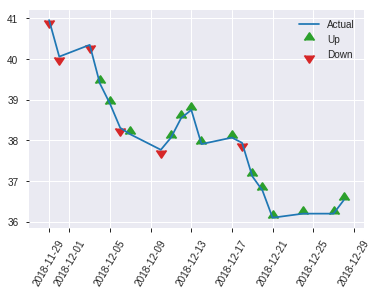


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19262459852690608
RMSE: 0.4388901895997518
LogLoss: 0.5705868122384103
Mean Per-Class Error: 0.2651168699186992
AUC: 0.7834095528455285
pr_auc: 0.7433698964736059
Gini: 0.566819105691057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.513973593711853: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   46   0.374    (46.0/123.0)
1      20   108  0.1562   (20.0/128.0)
Total  97   154  0.2629   (66.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513974     0.765957  153
max f2                       0.301072     0.861111  207
max f0point5                 0.576112     0.734375  127
max accuracy                 0.513974     0.737052  153
max precision                0.864446     1         0
max recall                   0.175704     1         242
max specificity              0.864446     1         0
max absolute_mcc             0.513974     0.482273  153
max min_per_class_accuracy   0.577138     0.723577  126
max mean_per_class_accuracy  0.513974     0.734883  153

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.840186           1.30729   1.30729            0.666667         0.850428  0.666667                    0.850428            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.820602           1.30729   1.30729            0.666667         0.82716   0.666667                    0.838794            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.816866           1.96094   1.4707             1                0.818089  0.75                        0.833618            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.804983           1.30729   1.42614            0.666667         0.809564  0.727273                    0.827058            0.015625        0.0625                     30.7292   42.6136
    5        0.0517928                   0.796739           0.980469  1.35757            0.5              0.798936  0.692308                    0.822731            0.0078125       0.0703125                  -1.95312  35.7572
    6        0.103586                    0.762931           1.96094   1.65925            1                0.777942  0.846154                    0.800337            0.101562        0.171875                   96.0938   65.9255
    7        0.151394                    0.734017           1.96094   1.75452            1                0.749347  0.894737                    0.784235            0.09375         0.265625                   96.0938   75.4523
    8        0.203187                    0.715824           1.50841   1.69179            0.769231         0.726591  0.862745                    0.769541            0.078125        0.34375                    50.8413   69.1789
    9        0.302789                    0.672099           1.09813   1.4965             0.56             0.691691  0.763158                    0.743932            0.109375        0.453125                   9.8125    49.6505
    10       0.40239                     0.617016           1.09813   1.3979             0.56             0.641606  0.712871                    0.718604            0.109375        0.5625                     9.8125    39.7896
    11       0.501992                    0.578463           1.56875   1.4318             0.8              0.600024  0.730159                    0.695076            0.15625         0.71875                    56.875    43.1796
    12       0.601594                    0.521517           1.01969   1.36357            0.52             0.551636  0.695364                    0.671328            0.101562        0.820312                   1.96875   36.3566
    13       0.701195                    0.437265           0.784375  1.28129            0.4              0.479017  0.653409                    0.644011            0.078125        0.898438                   -21.5625  28.1294
    14       0.800797                    0.329849           0.470625  1.18046            0.24             0.38884   0.60199                     0.612273            0.046875        0.945312                   -52.9375  18.0465
    15       0.900398                    0.242515           0.392188  1.09327            0.2              0.281262  0.557522                    0.575657            0.0390625       0.984375                   -60.7812  9.3266
    16       1                           0.139054           0.156875  1                  0.08             0.19464   0.50996                     0.537707          

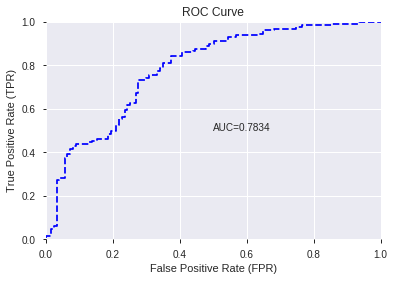

This function is available for GLM models only


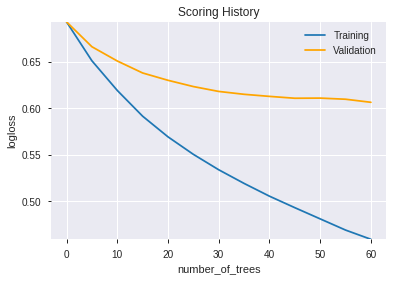

--2019-08-26 17:23:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

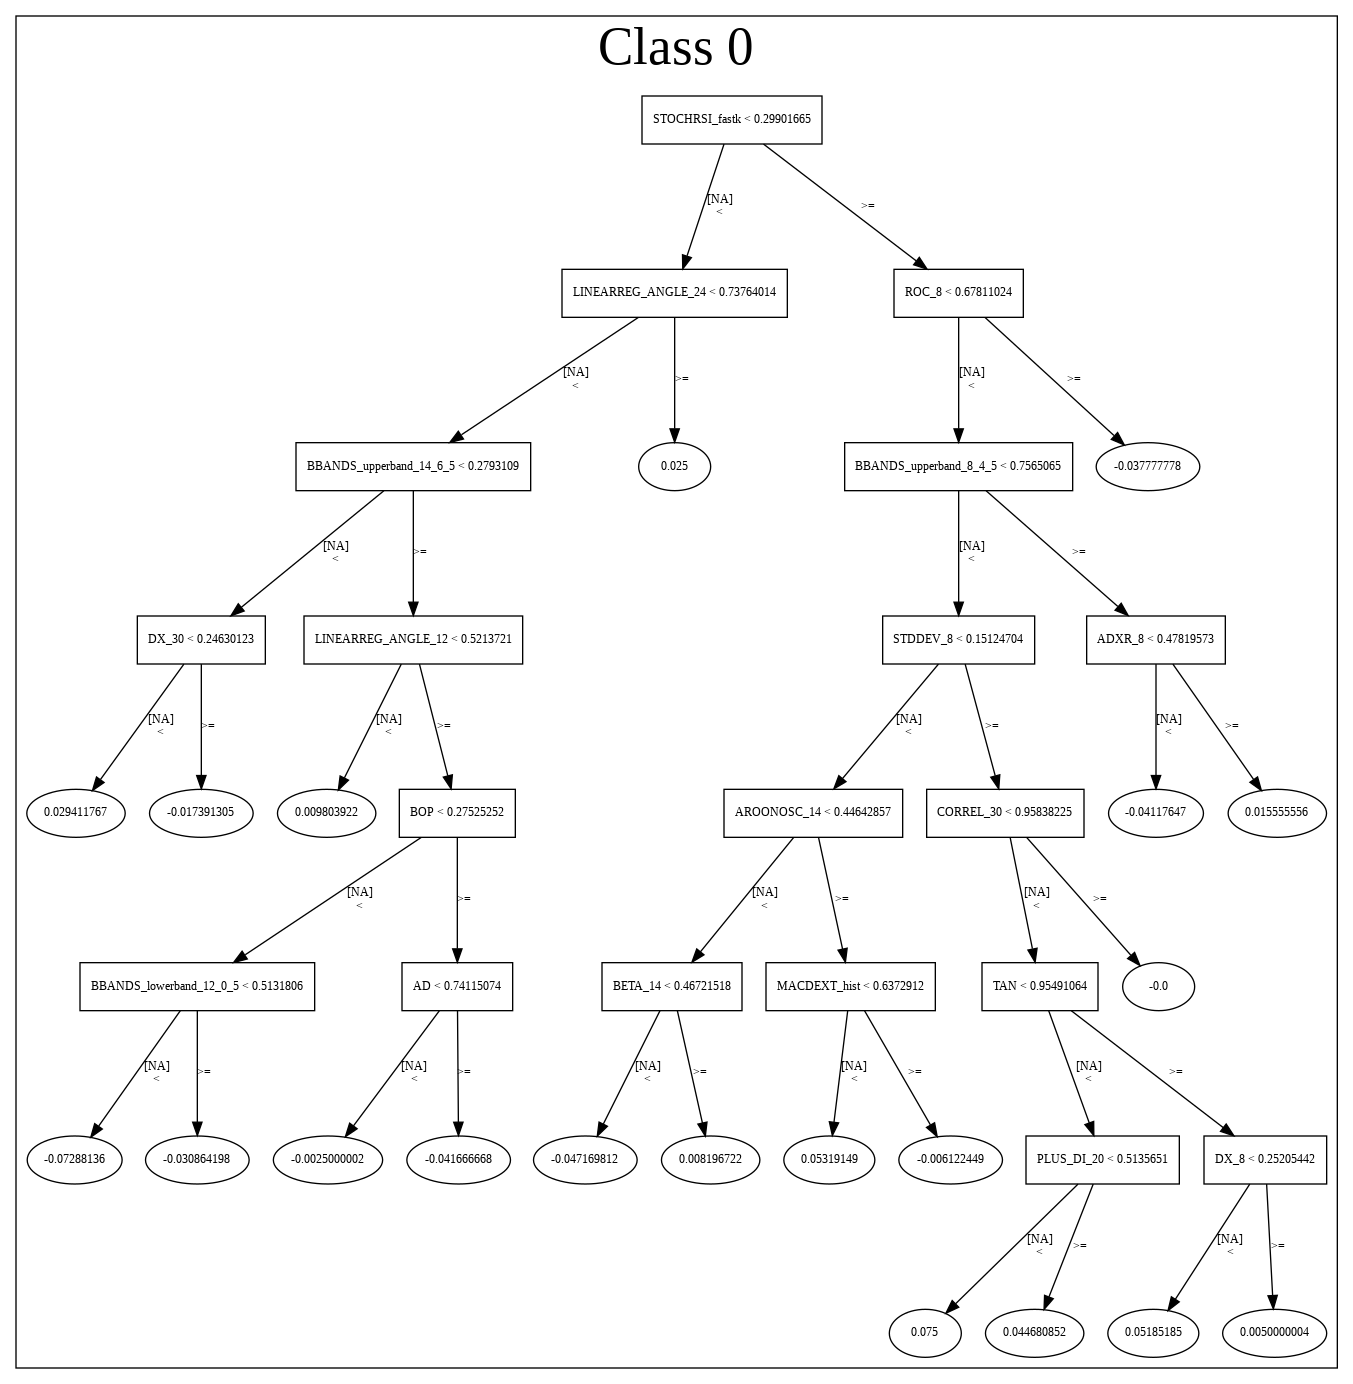

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_172231_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_172231_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_172335_model_5  0.792556  0.557456              0.282965  0.429378  0.184366
1  DeepLearning_grid_1_AutoML_20190826_172335_model_6  0.790904  0.571469              0.295319  0.437644  0.191532
2  DeepLearning_grid_1_AutoML_20190826_172335_model_9  0.784299  0.576884              0.282489  0.442632  0.195923
3  DeepLearning_grid_1_AutoML_20190826_172335_model_8  0.781186  0.576500              0.261211  0.442661  0.195949
4  DeepLearning_grid_1_AutoML_20190826_172335_model_7  0.763465  0.626370              0.285918  0.448283  0.200958
5               DeepLearning_1_AutoML_20190826_172335  0.756479  0.594642              0.327680  0.451285  0.203658
6  DeepLearning_grid_1_AutoML_20190826_172335_model_3  0.752096  0.659464              0.291413  0.456880  0.208739
7  DeepLearning_grid_1_AutoML_20190826_172335_model_1  0.718305  0.752021              0.363948  0.487013  0.237182
8  DeepLearning_grid_1_AutoML_20190826_172335_model_4  0.715638  0.829617              0.328157  0.523467  0.274018
9  DeepLearning_grid_1_AutoML_20190826_172335_model_2  0.712589  0.749292              0.306085  0.507689  0.257749

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.034032
1     CDLCLOSINGMARUBOZU             0.746755           0.746755    0.025414
2                     AD             0.712403           0.712403    0.024245
3           weekday_name             0.682154           0.682154    0.023215
4                    OBV             0.680758           0.680758    0.023168
5                    DIV             0.661284           0.661284    0.022505
6            HT_DCPERIOD             0.658406           0.658406    0.022407
7                    SIN             0.652997           0.652997    0.022223
8                    SUB             0.646293           0.646293    0.021995
9              aroonup_8             0.643089           0.643089    0.021886
10        STOCHRSI_fastk             0.640390           0.640390    0.021794
11                 ADX_8             0.634102           0.634102    0.021580
12                ULTOSC             0.632516           0.632516    0.021526
13           CDLLONGLINE             0.619608           0.619608    0.021087
14                   day             0.612475           0.612475    0.020844
15                 DX_14             0.604425           0.604425    0.020570
16              CORREL_8             0.602073           0.602073    0.020490
17                  DX_8             0.597968           0.597968    0.020350
18        STOCHRSI_fastd             0.589145           0.589145    0.020050
19             CORREL_30             0.585857           0.585857    0.019938
20          STOCHF_fastk             0.584783           0.584783    0.019901
21             CDLTAKURI             0.583724           0.583724    0.019865
22               weekday             0.578248           0.578248    0.019679
23          CDLSHORTLINE             0.571387           0.571387    0.019446
24      CDLDRAGONFLYDOJI             0.571301           0.571301    0.019443
25             CORREL_20             0.571275           0.571275    0.019442
26             dayofweek             0.570894           0.570894    0.019429
27  HT_PHASOR_quadrature             0.561916           0.561916    0.019123
28            AROONOSC_8             0.561481           0.561481    0.019108
29               WILLR_8             0.559264           0.559264    0.019033
30                Volume             0.558871           0.558871    0.019020
31           CDLMARUBOZU             0.550317           0.550317    0.018729
32                TRANGE             0.544879           0.544879    0.018543
33             CORREL_24             0.540498           0.540498    0.018394
34                BETA_8             0.538938           0.538938    0.018341
35     CDLDARKCLOUDCOVER             0.538222           0.538222    0.018317
36              WILLR_20             0.538071           0.538071    0.018312
37           STOCH_slowd             0.538061           0.538061    0.018311
38              STDDEV_8             0.537406           0.537406    0.018289
39          CDLENGULFING             0.533618           0.533618    0.018160
40                 ADOSC             0.526000           0.526000    0.017901
41               ROCP_20             0.522800           0.522800    0.017792
42           STOCH_slowk             0.522340           0.522340    0.017776
43                MOM_20             0.509497           0.509497    0.017339
44          STOCHF_fastd             0.509163           0.509163    0.017328
45        is_month_start             0.507216           0.507216    0.017262
46            CDL3INSIDE             0.501013           0.501013    0.017051
47              WILLR_14             0.490436           0.490436    0.016691
48           CDLBELTHOLD             0.481570           0.481570    0.016389
49              WILLR_12             0.477992           0.477992    0.016267

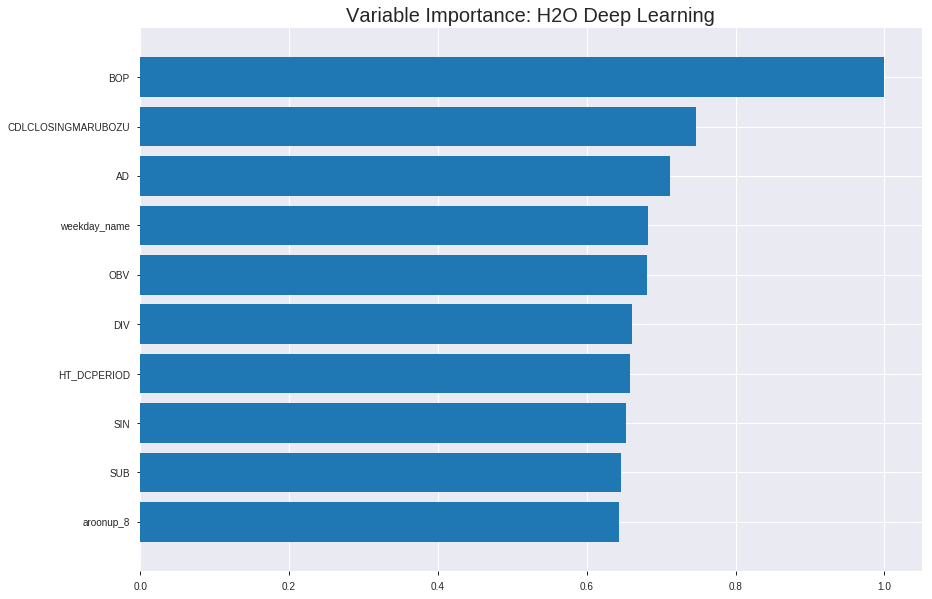

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_172335_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18450785775880324
RMSE: 0.4295437786289114
LogLoss: 0.5377003074943095
Mean Per-Class Error: 0.29043293087953737
AUC: 0.7939964052670653
pr_auc: 0.7950053703642905
Gini: 0.5879928105341305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26420992123290765: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      360  495   0.5789   (495.0/855.0)
1      50   848   0.0557   (50.0/898.0)
Total  410  1343  0.3109   (545.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26421      0.756805  298
max f2                       0.186735     0.872277  326
max f0point5                 0.510109     0.72038   190
max accuracy                 0.492658     0.70907   199
max precision                0.988936     1         0
max recall                   0.00624722   1         396
max specificity              0.988936     1         0
max absolute_mcc             0.26421      0.431448  298
max min_per_class_accuracy   0.479234     0.706433  205
max mean_per_class_accuracy  0.492658     0.709567  199

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 47.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.969745           1.95212    1.95212            1                0.980278   1                           0.980278            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.956278           1.95212    1.95212            1                0.961589   1                           0.970934            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.936807           1.95212    1.95212            1                0.945292   1                           0.962709            0.018931        0.05902                    95.2116   95.2116
    4        0.040502                    0.92472            1.95212    1.95212            1                0.931461   1                           0.954787            0.0200445       0.0790646                  95.2116   95.2116
    5        0.0501997                   0.913247           1.49279    1.86338            0.764706         0.918873   0.954545                    0.947849            0.0144766       0.0935412                  49.2794   86.3383
    6        0.100399                    0.834757           1.77465    1.81902            0.909091         0.876636   0.931818                    0.912243            0.0890869       0.182628                   77.4651   81.9017
    7        0.150029                    0.765707           1.52579    1.72202            0.781609         0.795171   0.882129                    0.873516            0.0757238       0.258352                   52.5792   72.2019
    8        0.200228                    0.708583           1.68592    1.71297            0.863636         0.739135   0.877493                    0.839825            0.0846325       0.342984                   68.5918   71.2968
    9        0.300057                    0.613879           1.28282    1.56986            0.657143         0.658591   0.804183                    0.779528            0.128062        0.471047                   28.2819   56.9857
    10       0.399886                    0.545014           1.11549    1.45643            0.571429         0.577702   0.746077                    0.729144            0.111359        0.582405                   11.5495   45.6429
    11       0.500285                    0.482119           1.15352    1.39564            0.590909         0.513628   0.714937                    0.685893            0.115813        0.698218                   15.3523   39.564
    12       0.600114                    0.414229           0.97048    1.32492            0.497143         0.447004   0.678707                    0.646154            0.096882        0.7951                     -2.95196  32.4915
    13       0.699943                    0.323415           0.903551   1.26482            0.462857         0.369533   0.647922                    0.606701            0.0902004       0.885301                   -9.64493  26.4818
    14       0.799772                    0.222677           0.758536   1.20162            0.388571         0.277077   0.615549                    0.565557            0.0757238       0.961024                   -24.1464  20.1623
    15       0.899601                    0.086235           0.345803   1.10665            0.177143         0.157977   0.566899                    0.520328            0.0345212       0.995546                   -65.4197  10.6653
    16       1                           0.000449713        0.0443663  1                  0.0227273        0.0396248  0.512265  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21201428070177805
RMSE: 0.46045008491885203
LogLoss: 0.6183408012580724
Mean Per-Class Error: 0.3276340996168583
AUC: 0.7274904214559387
pr_auc: 0.7214216854295531
Gini: 0.45498084291187735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2150897898573672: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      61   179  0.7458   (179.0/240.0)
1      11   250  0.0421   (11.0/261.0)
Total  72   429  0.3792   (190.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.21509      0.724638  337
max f2                       0.104376     0.853175  370
max f0point5                 0.594651     0.696517  153
max accuracy                 0.540177     0.668663  175
max precision                0.99307      1         0
max recall                   0.00619502   1         395
max specificity              0.99307      1         0
max absolute_mcc             0.594651     0.356447  153
max min_per_class_accuracy   0.504665     0.659004  200
max mean_per_class_accuracy  0.594651     0.672366  153

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.962758           1.59962   1.59962            0.833333         0.979473   0.833333                    0.979473            0.0191571       0.0191571                  59.9617   59.9617
    2        0.0219561                   0.945718           1.91954   1.74504            1                0.956372   0.909091                    0.968973            0.0191571       0.0383142                  91.954    74.5037
    3        0.0319361                   0.915187           1.15172   1.55963            0.6              0.930138   0.8125                      0.956837            0.0114943       0.0498084                  15.1724   55.9626
    4        0.0419162                   0.899414           1.53563   1.55391            0.8              0.906054   0.809524                    0.944746            0.0153257       0.0651341                  53.5632   55.3914
    5        0.0518962                   0.881765           1.91954   1.62423            1                0.886281   0.846154                    0.933502            0.0191571       0.0842912                  91.954    62.4226
    6        0.101796                    0.829258           1.30529   1.46788            0.68             0.857164   0.764706                    0.896082            0.0651341       0.149425                   30.5287   46.7884
    7        0.151697                    0.773104           1.45885   1.46491            0.76             0.79622    0.763158                    0.863232            0.0727969       0.222222                   45.8851   46.4912
    8        0.201597                    0.730379           1.38207   1.44441            0.72             0.754436   0.752475                    0.836303            0.0689655       0.291188                   38.2069   44.4407
    9        0.301397                    0.645652           1.53563   1.47461            0.8              0.68864    0.768212                    0.787408            0.153257        0.444444                   53.5632   47.4614
    10       0.401198                    0.561876           1.19011   1.40384            0.62             0.60695    0.731343                    0.742518            0.118774        0.563218                   19.0115   40.3843
    11       0.500998                    0.506315           0.921379  1.30773            0.48             0.531167   0.681275                    0.700416            0.091954        0.655172                   -7.86207  30.7735
    12       0.600798                    0.451597           0.921379  1.24356            0.48             0.479035   0.647841                    0.663642            0.091954        0.747126                   -7.86207  24.3556
    13       0.700599                    0.391053           0.921379  1.19766            0.48             0.42113    0.623932                    0.629096            0.091954        0.83908                    -7.86207  19.7662
    14       0.800399                    0.291057           0.691034  1.13449            0.36             0.350353   0.591022                    0.59434             0.0689655       0.908046                   -30.8966  13.4491
    15       0.9002                      0.14638            0.652644  1.08107            0.34             0.222784   0.563193                    0.553147            0.0651341       0.97318                    -34.7356  8.10714
    16       1                           0.000782237        0.268736  1                  0.14             0.0725835  0.520958                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:27:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:27:33  2 min  4.421 sec  1097 obs/sec      1.23046   1             2157       0.469934         0.632093            0.116115       0.764269        0.768527           1.95212          0.341129                         0.481296           0.659689              0.0717869        0.720259          0.717811             1.59962            0.377246
    2019-08-26 17:27:43  2 min 14.521 sec  1741 obs/sec      11.0844   9             19431      0.429544         0.5377              0.261524       0.793996        0.795005           1.95212          0.310896                         0.46045            0.618341              0.15045          0.72749           0.721422             1.59962            0.379242
    2019-08-26 17:27:53  2 min 24.600 sec  1907 obs/sec      22.1021   18            38745      0.406126         0.486712            0.339848       0.834116        0.826378           1.95212          0.273246                         0.464132           0.640367              0.136808         0.72413           0.722753             1.91954            0.379242
    2019-08-26 17:28:03  2 min 34.348 sec  1995 obs/sec      33.1346   27            58085      0.388874         0.451899            0.394745       0.869856        0.868876           1.95212          0.234455                         0.466206           0.63692               0.129078         0.726117          0.721234             1.91954            0.359281
    2019-08-26 17:28:12  2 min 44.082 sec  2041 obs/sec      44.1415   36            77380      0.354293         0.383771            0.497604       0.912417        0.902397           1.95212          0.185396                         0.478843           0.686469              0.0812245        0.702658          0.70351              1.91954            0.361277
    2019-08-26 17:28:22  2 min 53.630 sec  2077 obs/sec      55.1455   45            96670      0.342969         0.357897            0.529206       0.921702        0.908678           1.95212          0.175128                         0.487379           0.742017              0.0481747        0.692776          0.683973             1.91954            0.391218
    2019-08-26 17:28:23  2 min 54.628 sec  2076 obs/sec      55.1455   45            96670      0.429544         0.5377              0.261524       0.793996        0.795005           1.95212          0.310896                         0.46045            0.618341              0.15045          0.72749           0.721422             1.59962            0.379242

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03403226718630161
CDLCLOSINGMARUBOZU  0.7467547655105591     0.7467547655105591   0.025413757702499356
AD                  0.7124029397964478     0.7124029397964478   0.024244687191459453
weekday_name        0.6821539998054504     0.6821539998054504   0.023215247183583428
OBV                 0.6807577610015869     0.6807577610015869   0.023167730011554463
---                 ---                    ---                  ---
is_month_start      0.5072157382965088     0.5072157382965088   0.01726170152680402
CDL3INSIDE          0.501013457775116      0.501013457775116    0.017050623858935587
WILLR_14            0.4904364347457886     0.4904364347457886   0.016690663785165854
CDLBELTHOLD         0.48156994581222534    0.48156994581222534  0.016388917064774442
WILLR_12            0.47799208760261536    0.47799208760261536  0.01626715443823029


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7712418300653595)

('auc', 0.7925558943089431)

('logloss', 0.5574558463965711)

('mean_per_class_error', 0.2666412601626016)

('rmse', 0.42937816044586635)

('mse', 0.18436560466787616)

deeplearning prediction progress: |███████████████████████████████████████| 100%


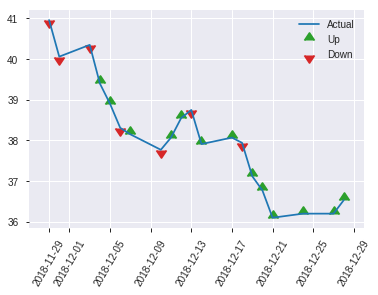


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18436560466787616
RMSE: 0.42937816044586635
LogLoss: 0.5574558463965711
Mean Per-Class Error: 0.2666412601626016
AUC: 0.7925558943089431
pr_auc: 0.7409805557992989
Gini: 0.5851117886178863
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38139447530308224: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   60   0.4878   (60.0/123.0)
1      10   118  0.0781   (10.0/128.0)
Total  73   178  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381394     0.771242  177
max f2                       0.289819     0.872905  203
max f0point5                 0.55066      0.746528  111
max accuracy                 0.522654     0.733068  122
max precision                0.778987     0.860465  42
max recall                   0.0412463    1         236
max specificity              0.986931     0.99187   0
max absolute_mcc             0.381394     0.4778    177
max min_per_class_accuracy   0.50338      0.723577  126
max mean_per_class_accuracy  0.522654     0.733359  122

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.963133           0.653646   0.653646           0.333333         0.976751   0.333333                    0.976751            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.925407           1.96094    1.30729            1                0.937204   0.666667                    0.956978            0.0234375       0.03125                    96.0938   30.7292
    3        0.0318725                   0.922235           1.96094    1.4707             1                0.924857   0.75                        0.948947            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.914545           1.30729    1.42614            0.666667         0.916734   0.727273                    0.940162            0.015625        0.0625                     30.7292   42.6136
    5        0.0517928                   0.903974           1.96094    1.50841            1                0.909179   0.769231                    0.935395            0.015625        0.078125                   96.0938   50.8413
    6        0.103586                    0.836432           1.65925    1.58383            0.846154         0.870701   0.807692                    0.903048            0.0859375       0.164062                   65.9255   58.3834
    7        0.151394                    0.79768            1.79753    1.65132            0.916667         0.818266   0.842105                    0.876275            0.0859375       0.25                       79.7526   65.1316
    8        0.203187                    0.748552           1.50841    1.61489            0.769231         0.774286   0.823529                    0.850278            0.078125        0.328125                   50.8413   61.489
    9        0.302789                    0.658954           1.49031    1.57391            0.76             0.701481   0.802632                    0.801332            0.148438        0.476562                   49.0313   57.391
    10       0.40239                     0.602251           1.33344    1.51439            0.68             0.629119   0.772277                    0.758705            0.132812        0.609375                   33.3438   51.4387
    11       0.501992                    0.504499           1.09813    1.4318             0.56             0.550246   0.730159                    0.717344            0.109375        0.71875                    9.8125    43.1796
    12       0.601594                    0.438915           0.784375   1.32461            0.4              0.467292   0.675497                    0.675945            0.078125        0.796875                   -21.5625  32.4607
    13       0.701195                    0.38689            1.09813    1.29244            0.56             0.414801   0.659091                    0.63885             0.109375        0.90625                    9.8125    29.2436
    14       0.800797                    0.297336           0.6275     1.20973            0.32             0.340482   0.616915                    0.60174             0.0625          0.96875                    -37.25    20.9733
    15       0.900398                    0.125982           0.235313   1.10194            0.12             0.192049   0.561947                    0.55642             0.0234375       0.992188                   -76.4688  10.1943
    16       1                           0.00271717         0.0784375  1                  0.04             0.0450739  0.50996   

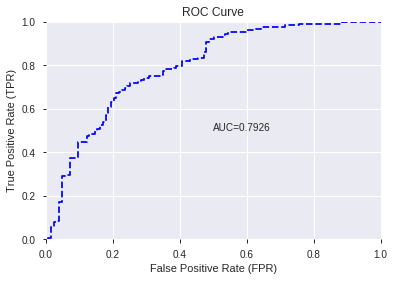

This function is available for GLM models only


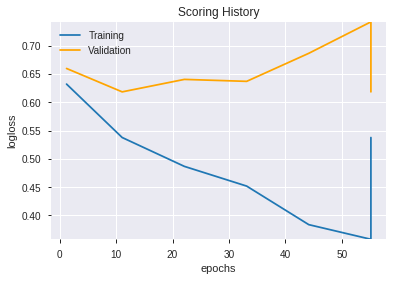

--2019-08-26 17:35:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


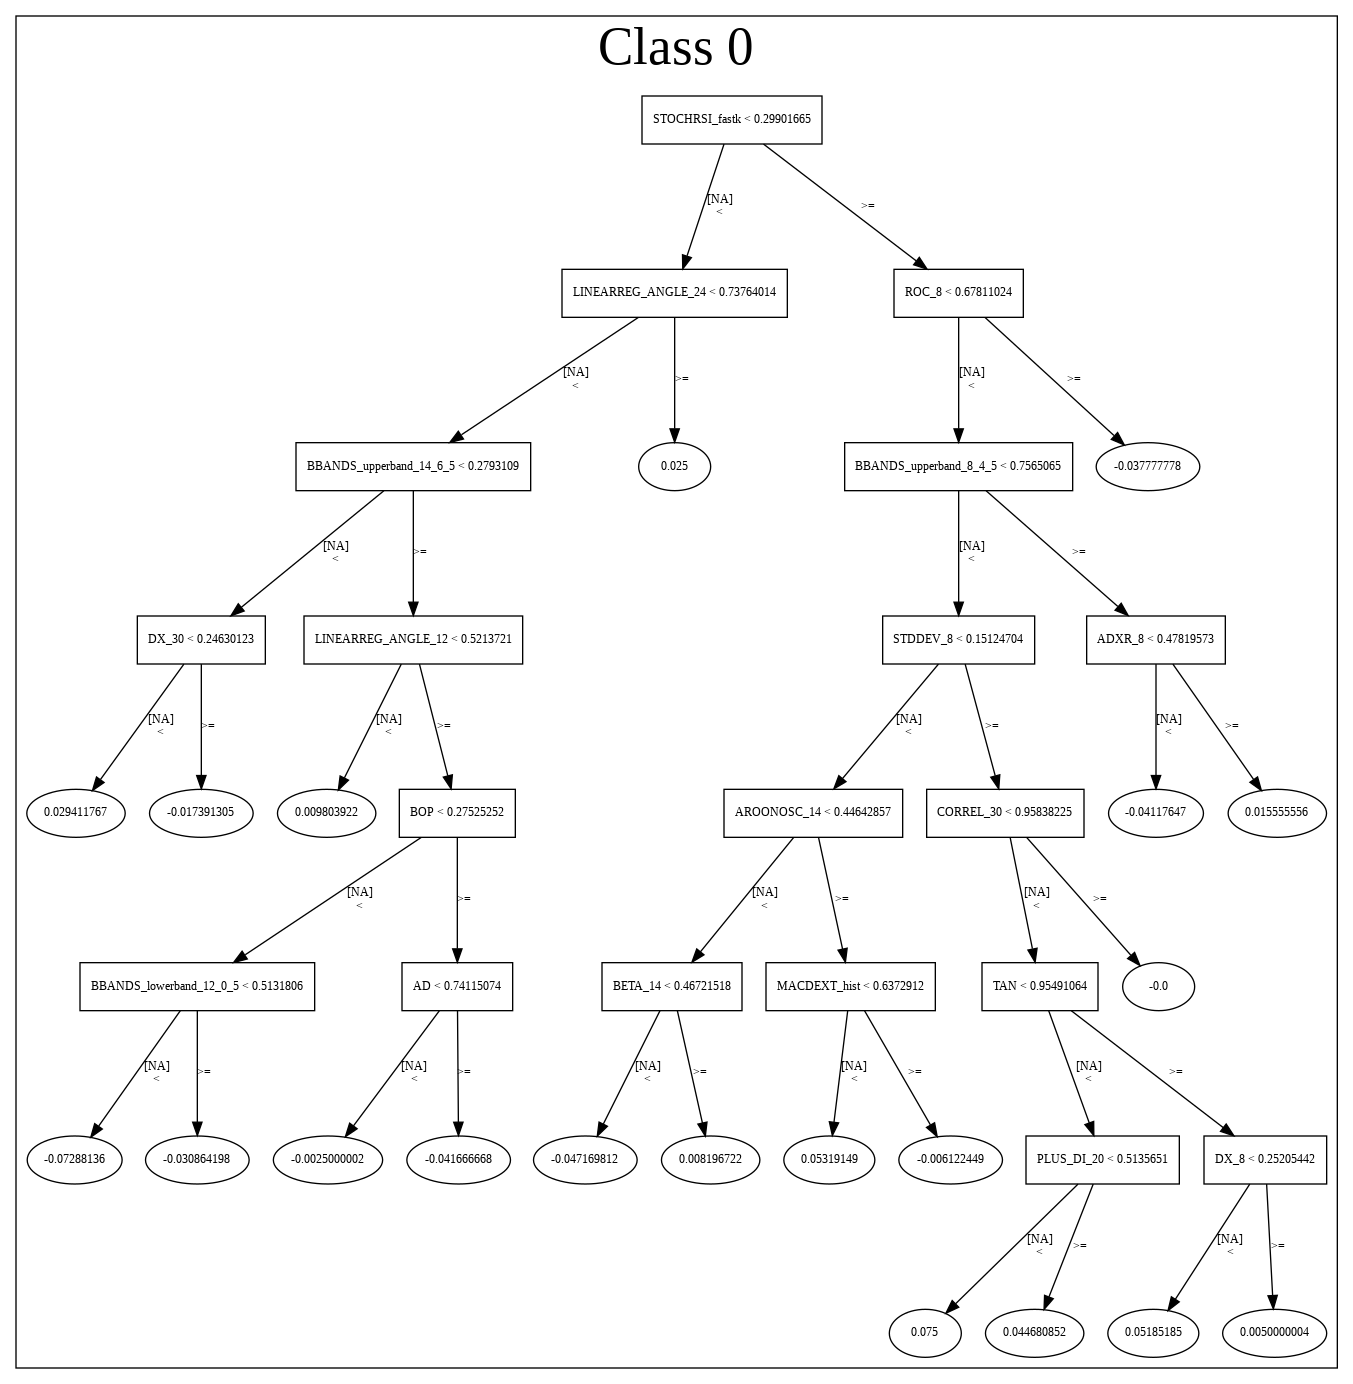

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_172335_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_172335_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'AD',
 'weekday_name',
 'OBV',
 'DIV',
 'HT_DCPERIOD',
 'SIN',
 'SUB',
 'aroonup_8',
 'STOCHRSI_fastk',
 'ADX_8',
 'ULTOSC',
 'CDLLONGLINE',
 'day',
 'DX_14',
 'CORREL_8',
 'DX_8',
 'STOCHRSI_fastd',
 'CORREL_30',
 'STOCHF_fastk',
 'CDLTAKURI',
 'weekday',
 'CDLSHORTLINE',
 'CDLDRAGONFLYDOJI',
 'CORREL_20',
 'dayofweek',
 'HT_PHASOR_quadrature',
 'AROONOSC_8',
 'WILLR_8',
 'Volume',
 'CDLMARUBOZU',
 'TRANGE',
 'CORREL_24',
 'BETA_8',
 'CDLDARKCLOUDCOVER',
 'WILLR_20',
 'STOCH_slowd',
 'STDDEV_8',
 'CDLENGULFING',
 'ADOSC',
 'ROCP_20',
 'STOCH_slowk',
 'MOM_20',
 'STOCHF_fastd',
 'is_month_start',
 'CDL3INSIDE',
 'WILLR_14',
 'CDLBELTHOLD',
 'WILLR_12']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_173527_model_1  0.788554  0.571537              0.281536  0.438713  0.192469

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.323088           1.000000    0.100143
1     CDLCLOSINGMARUBOZU             0.182393           0.564530    0.056534
2            CDLLONGLINE             0.136427           0.422259    0.042286
3                    SUB             0.130009           0.402394    0.040297
4           STOCHF_fastk             0.117829           0.364696    0.036522
5                WILLR_8             0.108744           0.336575    0.033706
6         STOCHRSI_fastd             0.106618           0.329998    0.033047
7                    DIV             0.100365           0.310644    0.031109
8              aroonup_8             0.097887           0.302974    0.030341
9               STDDEV_8             0.092332           0.285779    0.028619
10                ULTOSC             0.089542           0.277143    0.027754
11                   OBV             0.080154           0.248087    0.024844
12           STOCH_slowd             0.079328           0.245530    0.024588
13                TRANGE             0.076122           0.235607    0.023594
14          CDLENGULFING             0.075736           0.234413    0.023475
15                 ADX_8             0.072018           0.222906    0.022323
16  HT_PHASOR_quadrature             0.071343           0.220816    0.022113
17            AROONOSC_8             0.068473           0.211934    0.021224
18      CDLDRAGONFLYDOJI             0.067502           0.208926    0.020923
19             CDLTAKURI             0.067441           0.208739    0.020904
20           STOCH_slowk             0.064177           0.198635    0.019892
21          STOCHF_fastd             0.063517           0.196594    0.019688
22            CDL3INSIDE             0.062760           0.194251    0.019453
23          weekday_name             0.062553           0.193611    0.019389
24        STOCHRSI_fastk             0.061388           0.190003    0.019028
25           CDLMARUBOZU             0.055063           0.170426    0.017067
26     CDLDARKCLOUDCOVER             0.050295           0.155670    0.015589
27             CORREL_30             0.050295           0.155670    0.015589
28          CDLSHORTLINE             0.050277           0.155614    0.015584
29                Volume             0.047003           0.145480    0.014569
30              WILLR_12             0.046126           0.142767    0.014297
31              CORREL_8             0.043218           0.133766    0.013396
32              WILLR_14             0.040927           0.126675    0.012686
33                 ADOSC             0.036261           0.112233    0.011239
34                 DX_14             0.035498           0.109871    0.011003
35              WILLR_20             0.035183           0.108895    0.010905
36        is_month_start             0.033180           0.102697    0.010284
37                BETA_8             0.033038           0.102258    0.010240
38                MOM_20             0.030102           0.093169    0.009330
39           HT_DCPERIOD             0.030032           0.092952    0.009309
40             CORREL_24             0.029768           0.092136    0.009227
41                   SIN             0.028524           0.088287    0.008841
42           CDLBELTHOLD             0.020017           0.061956    0.006204
43                   day             0.018110           0.056054    0.005613
44                  DX_8             0.014387           0.044528    0.004459
45             dayofweek             0.012295           0.038054    0.003811
46               weekday             0.012286           0.038027    0.003808
47               ROCP_20             0.008201           0.025383    0.002542
48                    AD             0.006779           0.020981    0.002101
49             CORREL_20             0.001646           0.005094    0.000510

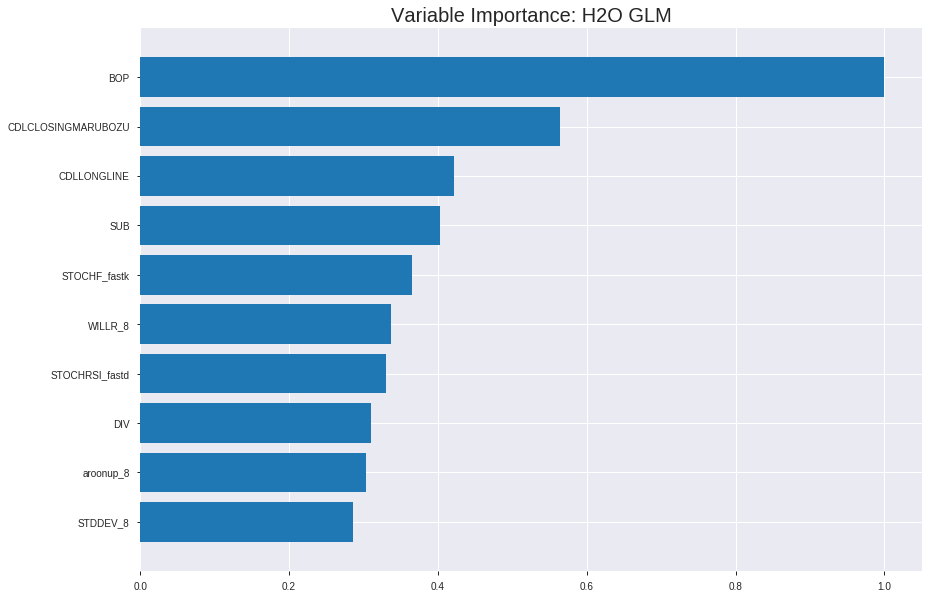

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_173527_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19774944142935666
RMSE: 0.4446902758430374
LogLoss: 0.5788020263014306
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.1191459812417
Residual deviance: 2029.2799042128158
AIC: 2131.279904212816
AUC: 0.7665227471053283
pr_auc: 0.7689296749357157
Gini: 0.5330454942106566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4491150934134585: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      466  389   0.455    (389.0/855.0)
1      149  749   0.1659   (149.0/898.0)
Total  615  1138  0.3069   (538.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449115     0.735756  237
max f2                       0.211606     0.850595  352
max f0point5                 0.527349     0.701536  189
max accuracy                 0.523217     0.693668  192
max precision                0.932737     1         0
max recall                   0.138312     1         380
max specificity              0.932737     1         0
max absolute_mcc             0.449115     0.397075  237
max min_per_class_accuracy   0.527349     0.691537  189
max mean_per_class_accuracy  0.523217     0.693414  192

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.88299            1.84366   1.84366            0.944444         0.89793   0.944444                    0.89793             0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.862987           1.84366   1.84366            0.944444         0.871401  0.944444                    0.884666            0.018931        0.0378619                  84.3665   84.3665
    3        0.0302339                   0.849384           1.83729   1.84162            0.941176         0.856436  0.943396                    0.875611            0.0178174       0.0556793                  83.7285   84.1619
    4        0.040502                    0.836389           1.62676   1.78715            0.833333         0.842252  0.915493                    0.867154            0.0167038       0.0723831                  62.6763   78.7148
    5        0.0501997                   0.816295           1.83729   1.79683            0.941176         0.823237  0.920455                    0.85867             0.0178174       0.0902004                  83.7285   79.6834
    6        0.100399                    0.757293           1.7081    1.75247            0.875            0.783682  0.897727                    0.821176            0.0857461       0.175947                   70.8101   75.2468
    7        0.150029                    0.715306           1.57067   1.69233            0.804598         0.735495  0.86692                     0.792833            0.077951        0.253898                   57.0668   69.2329
    8        0.200228                    0.679697           1.59719   1.66848            0.818182         0.697637  0.854701                    0.768966            0.0801782       0.334076                   59.7186   66.8475
    9        0.300057                    0.624408           1.26051   1.53274            0.645714         0.648097  0.785171                    0.728753            0.125835        0.459911                   26.0509   53.2745
    10       0.399886                    0.573537           1.16011   1.43972            0.594286         0.599149  0.737518                    0.696398            0.115813        0.575724                   16.0115   43.972
    11       0.500285                    0.528329           1.10916   1.37338            0.568182         0.550164  0.703535                    0.667051            0.111359        0.687082                   10.9157   37.3381
    12       0.600114                    0.474578           0.959325  1.3045             0.491429         0.502137  0.668251                    0.639618            0.0957684       0.782851                   -4.06745  30.4503
    13       0.699943                    0.41682            0.814311  1.23459            0.417143         0.446987  0.632437                    0.612144            0.0812918       0.864143                   -18.5689  23.459
    14       0.799772                    0.345089           0.725072  1.17099            0.371429         0.381227  0.599857                    0.58332             0.0723831       0.936526                   -27.4928  17.0991
    15       0.899601                    0.237898           0.379268  1.08313            0.194286         0.289293  0.554851                    0.550692            0.0378619       0.974388                   -62.0732  8.31334
    16       1                           0.0390107          0.255106  1                  0.130682         0.167947  0.512265                    0.512265           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21434995062827492
RMSE: 0.4629794278672379
LogLoss: 0.6157295174534535
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.804571947685
Residual deviance: 616.9609764883604
AIC: 718.9609764883604
AUC: 0.7162835249042145
pr_auc: 0.7197536171958914
Gini: 0.4325670498084291
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3748592176333652: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   165  0.6875   (165.0/240.0)
1      20   241  0.0766   (20.0/261.0)
Total  95   406  0.3693   (185.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374859     0.722639  318
max f2                       0.22089      0.852048  370
max f0point5                 0.564977     0.69386   184
max accuracy                 0.564977     0.674651  184
max precision                0.922109     1         0
max recall                   0.140222     1         388
max specificity              0.922109     1         0
max absolute_mcc             0.564977     0.353673  184
max min_per_class_accuracy   0.550155     0.659004  199
max mean_per_class_accuracy  0.564977     0.676509  184

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 53.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.880701           1.91954   1.91954            1                0.897594  1                           0.897594            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.851489           1.91954   1.91954            1                0.86575   1                           0.883119            0.0191571       0.0421456                  91.954    91.954
    3        0.0319361                   0.839473           1.53563   1.79957            0.8              0.842859  0.9375                      0.870538            0.0153257       0.0574713                  53.5632   79.9569
    4        0.0419162                   0.82345            0.767816  1.55391            0.4              0.833325  0.809524                    0.861678            0.00766284      0.0651341                  -23.2184  55.3914
    5        0.0518962                   0.800785           1.91954   1.62423            1                0.811236  0.846154                    0.851977            0.0191571       0.0842912                  91.954    62.4226
    6        0.101796                    0.748259           1.38207   1.50552            0.72             0.772541  0.784314                    0.813038            0.0689655       0.153257                   38.2069   50.5522
    7        0.151697                    0.711277           1.61241   1.54068            0.84             0.729204  0.802632                    0.785461            0.0804598       0.233716                   61.2414   54.0684
    8        0.201597                    0.677663           1.61241   1.55844            0.84             0.692078  0.811881                    0.762346            0.0804598       0.314176                   61.2414   55.8439
    9        0.301397                    0.628182           1.22851   1.44919            0.64             0.651211  0.754967                    0.725546            0.122605        0.436782                   22.8506   44.9189
    10       0.401198                    0.588077           1.15172   1.37519            0.6              0.60496   0.716418                    0.69555             0.114943        0.551724                   15.1724   37.5193
    11       0.500998                    0.550077           1.07494   1.31538            0.56             0.568971  0.685259                    0.670335            0.10728         0.659004                   7.49425   31.5382
    12       0.600798                    0.507498           0.767816  1.22442            0.4              0.529537  0.637874                    0.646946            0.0766284       0.735632                   -23.2184  22.4424
    13       0.700599                    0.463655           0.882989  1.17579            0.46             0.483831  0.612536                    0.623711            0.0881226       0.823755                   -11.7011  17.5787
    14       0.800399                    0.382404           0.882989  1.13928            0.46             0.42542   0.593516                    0.598986            0.0881226       0.911877                   -11.7011  13.9278
    15       0.9002                      0.305488           0.49908   1.0683             0.26             0.345342  0.556541                    0.570866            0.0498084       0.961686                   -50.092   6.83029
    16       1                           0.0523833          0.383908  1                  0.2              0.190448  0.520958                    0.5329             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:35:27  0.000 sec   2            20        51            1.3667            1.37059
    2019-08-26 17:35:27  0.011 sec   4            12        51            1.35712           1.36333
    2019-08-26 17:35:27  0.024 sec   6            7.7       51            1.34395           1.3533
    2019-08-26 17:35:27  0.035 sec   8            4.8       51            1.32684           1.34014
    2019-08-26 17:35:27  0.046 sec   10           3         51            1.30599           1.32399
    2019-08-26 17:35:27  0.057 sec   12           1.8       51            1.28214           1.30551
    2019-08-26 17:35:27  0.068 sec   14           1.1       51            1.25671           1.28613
    2019-08-26 17:35:27  0.079 sec   16           0.71      51            1.23141           1.26772
    2019-08-26 17:35:27  0.089 sec   18           0.44      51            1.20798           1.25223
    2019-08-26 17:35:28  0.100 sec   20           0.27      51            1.18761           1.24092
    2019-08-26 17:35:28  0.111 sec   22           0.17      51            1.17081           1.23415
    2019-08-26 17:35:28  0.122 sec   24           0.11      51            1.1576            1.23146
    2019-08-26 17:35:28  0.135 sec   26           0.066     51            1.14768           1.23191
    2019-08-26 17:35:28  0.146 sec   28           0.041     51            1.14056           1.23432
    2019-08-26 17:35:28  0.164 sec   30           0.025     51            1.13565           1.23757
    2019-08-26 17:35:28  0.177 sec   32           0.016     51            1.13235           1.24064
    2019-08-26 17:35:28  0.188 sec   34           0.0098    51            1.13015           1.24299

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7569444444444445)

('auc', 0.7885543699186992)

('logloss', 0.5715374284362961)

('mean_per_class_error', 0.2677527947154472)

('rmse', 0.4387128707773512)

('mse', 0.19246898298570486)

glm prediction progress: |████████████████████████████████████████████████| 100%


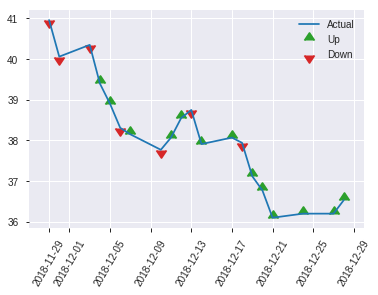


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19246898298570486
RMSE: 0.4387128707773512
LogLoss: 0.5715374284362961
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.8656113866541
Residual deviance: 286.9117890750206
AIC: 388.9117890750206
AUC: 0.7885543699186992
pr_auc: 0.7418710717274966
Gini: 0.5771087398373984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726479005737328: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   51   0.4146   (51.0/123.0)
1      19   109  0.1484   (19.0/128.0)
Total  91   160  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472648     0.756944  159
max f2                       0.291406     0.872253  215
max f0point5                 0.588233     0.744485  103
max accuracy                 0.520013     0.733068  136
max precision                0.671738     0.847458  58
max recall                   0.108924     1         247
max specificity              0.91092      0.99187   0
max absolute_mcc             0.520013     0.466364  136
max min_per_class_accuracy   0.539836     0.715447  126
max mean_per_class_accuracy  0.520013     0.732247  136

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.873002           1.30729    1.30729            0.666667         0.893782  0.666667                    0.893782            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.857667           1.30729    1.30729            0.666667         0.866292  0.666667                    0.880037            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.844181           1.96094    1.4707             1                0.845353  0.75                        0.871366            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.839154           1.96094    1.6044             1                0.840502  0.818182                    0.862948            0.0234375       0.0703125                  96.0938   60.4403
    5        0.0517928                   0.830658           0.980469   1.50841            0.5              0.832519  0.769231                    0.858267            0.0078125       0.078125                   -1.95312  50.8413
    6        0.103586                    0.767996           1.50841    1.50841            0.769231         0.789951  0.769231                    0.824109            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.725411           1.79753    1.59971            0.916667         0.739451  0.815789                    0.797375            0.0859375       0.242188                   79.7526   59.9712
    8        0.203187                    0.692064           1.65925    1.61489            0.846154         0.706473  0.823529                    0.774204            0.0859375       0.328125                   65.9255   61.489
    9        0.302789                    0.639082           1.33344    1.52231            0.68             0.662643  0.776316                    0.737506            0.132812        0.460938                   33.3438   52.2307
    10       0.40239                     0.594304           1.56875    1.5338             0.8              0.617918  0.782178                    0.707905            0.15625         0.617188                   56.875    53.3803
    11       0.501992                    0.543026           0.94125    1.41623            0.48             0.56723   0.722222                    0.679993            0.09375         0.710938                   -5.875    41.6233
    12       0.601594                    0.487956           1.01969    1.35058            0.52             0.514112  0.688742                    0.652529            0.101562        0.8125                     1.96875   35.0579
    13       0.701195                    0.441779           0.705937   1.25901            0.36             0.463572  0.642045                    0.625689            0.0703125       0.882812                   -29.4062  25.9011
    14       0.800797                    0.371834           0.6275     1.18046            0.32             0.409325  0.60199                     0.598778            0.0625          0.945312                   -37.25    18.0465
    15       0.900398                    0.247277           0.470625   1.10194            0.24             0.307063  0.561947                    0.566509            0.046875        0.992188                   -52.9375  10.1943
    16       1                           0.0584346          0.0784375  1                  0.04             0.173148  0.50996                     

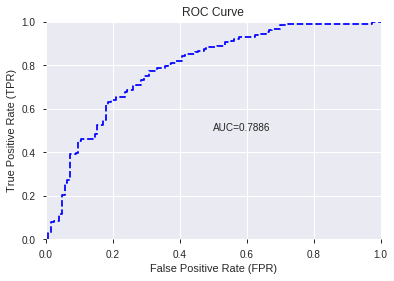

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


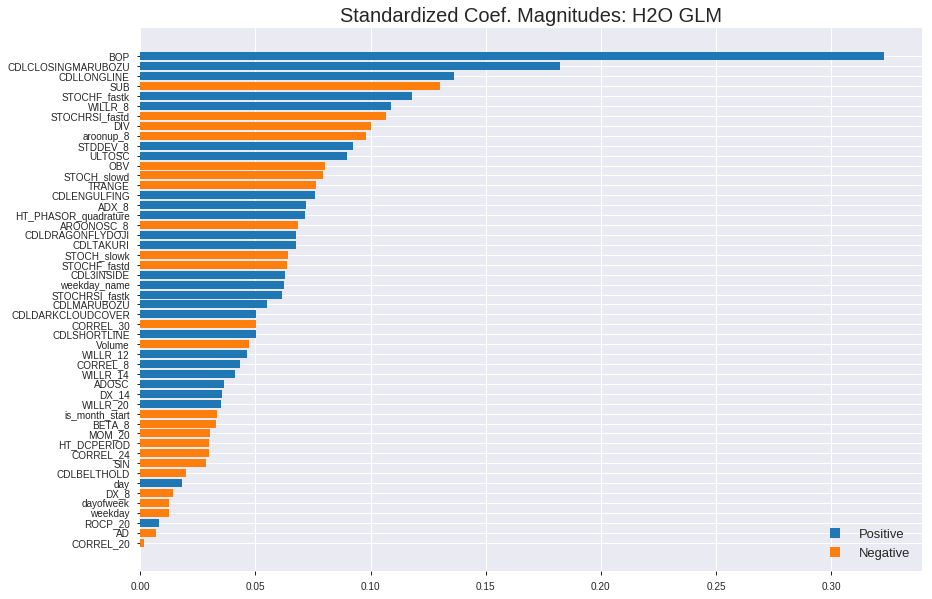

'log_likelihood'
--2019-08-26 17:35:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.225.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.225.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


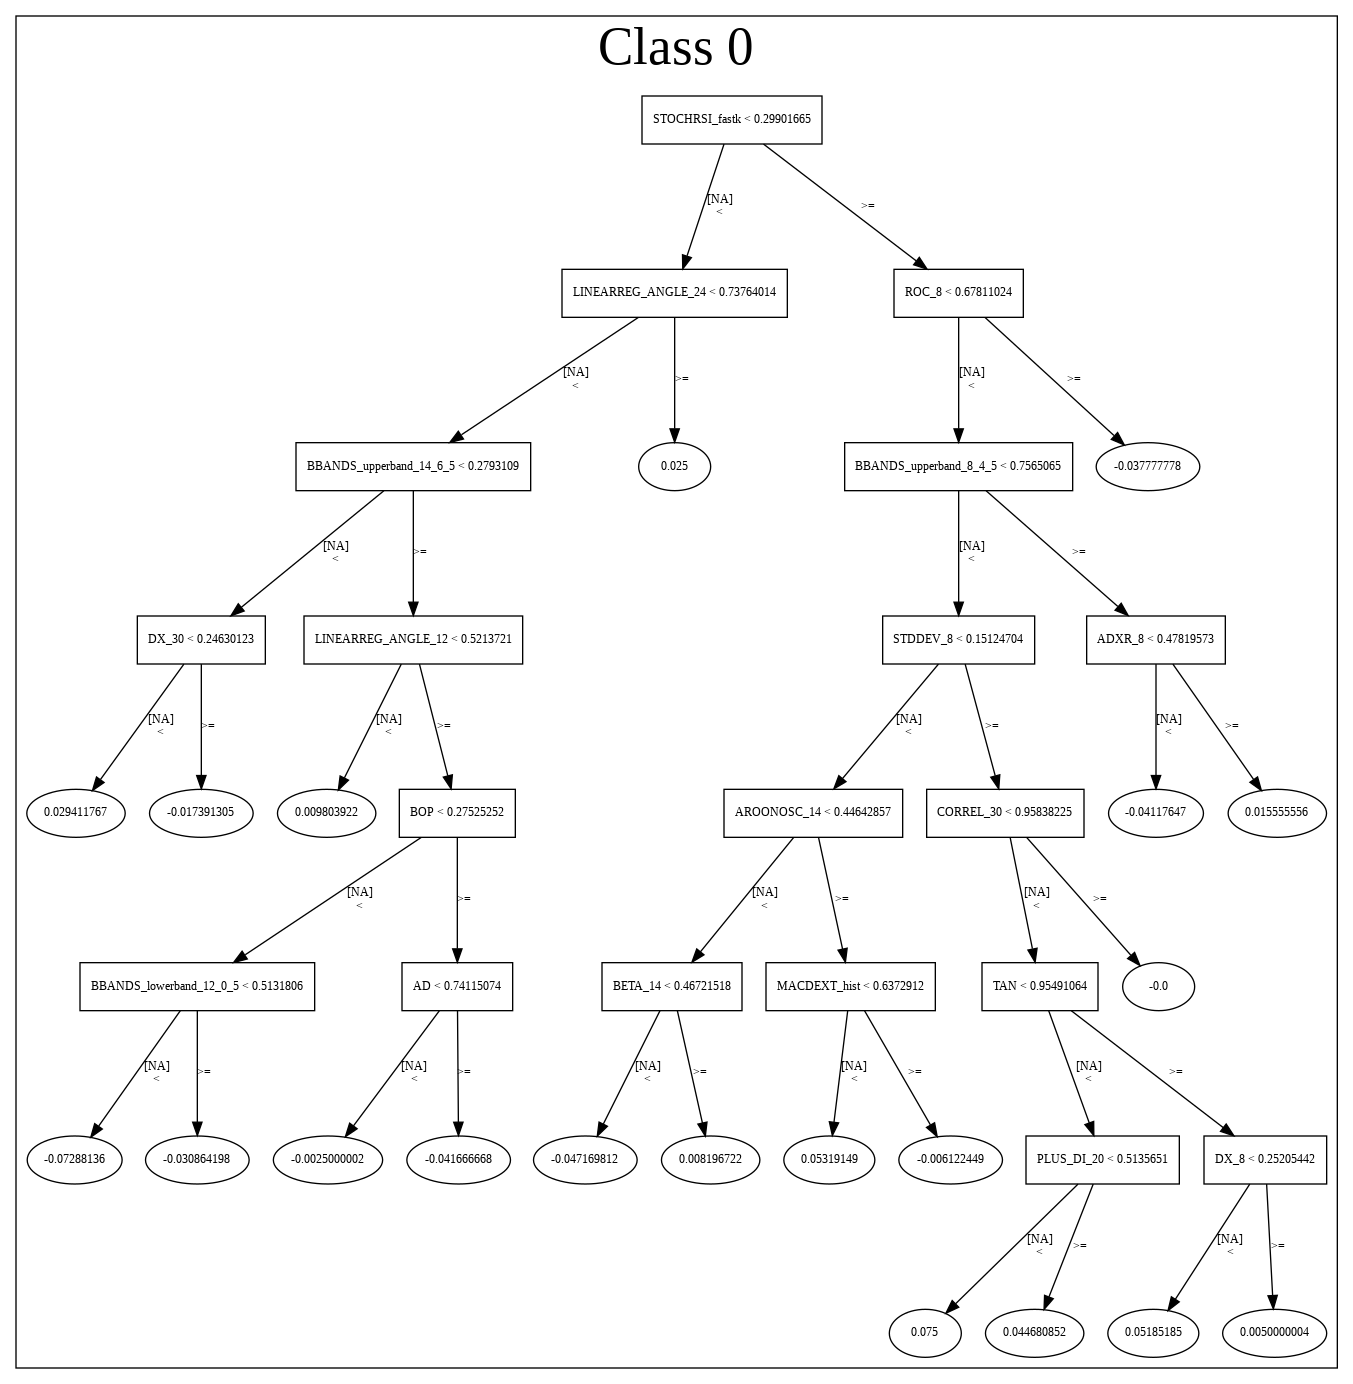

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_173527_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_173527_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCHRSI_fastd',
 'DIV',
 'aroonup_8',
 'STDDEV_8',
 'ULTOSC',
 'OBV',
 'STOCH_slowd',
 'TRANGE',
 'CDLENGULFING',
 'ADX_8',
 'HT_PHASOR_quadrature',
 'AROONOSC_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDL3INSIDE',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CORREL_30',
 'CDLSHORTLINE',
 'Volume',
 'WILLR_12',
 'CORREL_8',
 'WILLR_14',
 'ADOSC',
 'DX_14',
 'WILLR_20',
 'is_month_start',
 'BETA_8',
 'MOM_20',
 'HT_DCPERIOD',
 'CORREL_24',
 'SIN',
 'CDLBELTHOLD',
 'day',
 'DX_8',
 'dayofweek',
 'weekday',
 'ROCP_20',
 'AD',
 'CORREL_20']

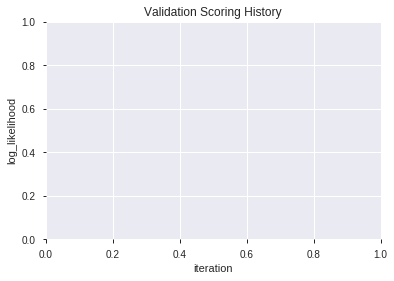

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_173538_model_6  0.792175  0.559356              0.257940  0.432992  0.187482
1  XGBoost_grid_1_AutoML_20190826_173538_model_1  0.787157  0.564369              0.278582  0.436156  0.190232
2  XGBoost_grid_1_AutoML_20190826_173538_model_7  0.781885  0.564330              0.282647  0.436070  0.190157
3  XGBoost_grid_1_AutoML_20190826_173538_model_2  0.780297  0.567828              0.295795  0.437650  0.191538
4               XGBoost_2_AutoML_20190826_173538  0.773310  0.571263              0.274200  0.440125  0.193710
5  XGBoost_grid_1_AutoML_20190826_173538_model_4  0.769245  0.575997              0.282806  0.442376  0.195697
6               XGBoost_1_AutoML_20190826_173538  0.768547  0.572958              0.282171  0.440958  0.194444
7               XGBoost_3_AutoML_20190826_173538  0.767467  0.577598              0.303608  0.442719  0.196000
8  XGBoost_grid_1_AutoML_20190826_173538_model_3  0.757304  0.580994              0.311420  0.444921  0.197955
9  XGBoost_grid_1_AutoML_20190826_173538_model_5  0.747459  0.592299              0.324092  0.449459  0.202013

variable  relative_importance  scaled_importance  percentage
0                    BOP          1999.769897           1.000000    0.197908
1                  DX_14           414.232880           0.207140    0.040995
2           STOCHF_fastk           392.865845           0.196456    0.038880
3                    DIV           376.294556           0.188169    0.037240
4                    SUB           366.686615           0.183364    0.036289
5                 Volume           356.194855           0.178118    0.035251
6                    OBV           312.712524           0.156374    0.030948
7                     AD           267.145782           0.133588    0.026438
8                  ADOSC           265.976379           0.133003    0.026322
9               CORREL_8           263.059723           0.131545    0.026034
10           STOCH_slowk           251.897507           0.125963    0.024929
11  HT_PHASOR_quadrature           250.186615           0.125108    0.024760
12               WILLR_8           249.665710           0.124847    0.024708
13        STOCHRSI_fastd           248.030731           0.124030    0.024546
14              STDDEV_8           238.873795           0.119451    0.023640
15                 ADX_8           238.445099           0.119236    0.023598
16                   SIN           225.675461           0.112851    0.022334
17                  DX_8           219.377167           0.109701    0.021711
18             CORREL_30           210.196579           0.105110    0.020802
19           HT_DCPERIOD           205.909927           0.102967    0.020378
20                TRANGE           202.566010           0.101295    0.020047
21             aroonup_8           199.029221           0.099526    0.019697
22           STOCH_slowd           185.127670           0.092574    0.018321
23                BETA_8           170.703583           0.085362    0.016894
24    CDLCLOSINGMARUBOZU           169.999603           0.085010    0.016824
25                   day           169.928833           0.084974    0.016817
26                ULTOSC           165.134933           0.082577    0.016343
27             CORREL_20           157.032715           0.078525    0.015541
28              WILLR_12           152.346222           0.076182    0.015077
29               ROCP_20           151.182327           0.075600    0.014962
30             CORREL_24           135.797501           0.067907    0.013439
31                MOM_20           122.724640           0.061369    0.012145
32              WILLR_20           101.005791           0.050509    0.009996
33             dayofweek            97.432762           0.048722    0.009642
34        STOCHRSI_fastk            95.273918           0.047642    0.009429
35              WILLR_14            94.116287           0.047064    0.009314
36            AROONOSC_8            88.044044           0.044027    0.008713
37           CDLLONGLINE            77.330711           0.038670    0.007653
38          weekday_name            70.167542           0.035088    0.006944
39          STOCHF_fastd            55.485577           0.027746    0.005491
40           CDLBELTHOLD            46.437943           0.023222    0.004596
41               weekday            16.210056           0.008106    0.001604
42      CDLDRAGONFLYDOJI            13.044633           0.006523    0.001291
43           CDLMARUBOZU             7.650581           0.003826    0.000757
44          CDLSHORTLINE             7.572556           0.003787    0.000749

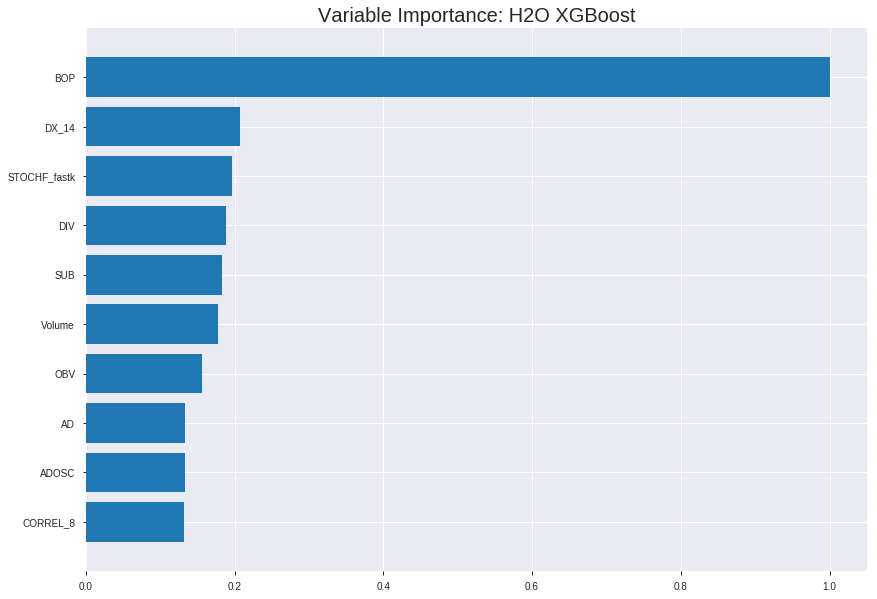

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_173538_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13759520632430886
RMSE: 0.37093827832175646
LogLoss: 0.442433493675455
Mean Per-Class Error: 0.16769819872621428
AUC: 0.9240951301788249
pr_auc: 0.9315298467098645
Gini: 0.8481902603576499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44844146569569904: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      603  252   0.2947   (252.0/855.0)
1      62   836   0.069    (62.0/898.0)
Total  665  1088  0.1791   (314.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448441     0.841893  231
max f2                       0.359941     0.902835  272
max f0point5                 0.625918     0.866235  142
max accuracy                 0.545836     0.831717  183
max precision                0.932064     1         0
max recall                   0.213022     1         340
max specificity              0.932064     1         0
max absolute_mcc             0.57185      0.666871  169
max min_per_class_accuracy   0.530681     0.826281  191
max mean_per_class_accuracy  0.545836     0.832302  183

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.903646           1.95212    1.95212            1                0.916403  1                           0.916403            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.884687           1.95212    1.95212            1                0.893368  1                           0.904886            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.870684           1.95212    1.95212            1                0.878658  1                           0.896473            0.018931        0.05902                    95.2116   95.2116
    4        0.040502                    0.858319           1.95212    1.95212            1                0.864124  1                           0.888272            0.0200445       0.0790646                  95.2116   95.2116
    5        0.0501997                   0.845233           1.95212    1.95212            1                0.851146  1                           0.8811              0.018931        0.0979955                  95.2116   95.2116
    6        0.100399                    0.795161           1.95212    1.95212            1                0.820641  1                           0.85087             0.0979955       0.195991                   95.2116   95.2116
    7        0.150029                    0.756963           1.92968    1.94469            0.988506         0.775571  0.996198                    0.825961            0.0957684       0.291759                   92.9678   94.4693
    8        0.200228                    0.728541           1.95212    1.94655            1                0.742068  0.997151                    0.804928            0.0979955       0.389755                   95.2116   94.6554
    9        0.300057                    0.665572           1.77364    1.88902            0.908571         0.695223  0.967681                    0.76843             0.17706         0.566815                   77.3637   88.9025
    10       0.399886                    0.593476           1.4613     1.78225            0.748571         0.62863   0.912981                    0.733529            0.14588         0.712695                   46.1298   78.2246
    11       0.500285                    0.534283           1.08697    1.64272            0.556818         0.564354  0.841505                    0.699579            0.109131        0.821826                   8.69736   64.2715
    12       0.600114                    0.4636             0.903551   1.51976            0.462857         0.501355  0.778517                    0.666604            0.0902004       0.912027                   -9.64493  51.9756
    13       0.699943                    0.381245           0.524283   1.37778            0.268571         0.422393  0.705786                    0.631774            0.0523385       0.964365                   -47.5717  37.7777
    14       0.799772                    0.283911           0.301184   1.24339            0.154286         0.334159  0.636947                    0.594625            0.0300668       0.994432                   -69.8816  24.3395
    15       0.899601                    0.180039           0.0557747  1.1116             0.0285714        0.233644  0.569436                    0.554567            0.00556793      1                          -94.4225  11.1604
    16       1                           0.0673345          0          1                  0                0.125802  0.512265                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2099589173853301
RMSE: 0.45821274249559024
LogLoss: 0.6046907348734996
Mean Per-Class Error: 0.31714559386973185
AUC: 0.7335967432950191
pr_auc: 0.7503980163704818
Gini: 0.46719348659003823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28919626772403717: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      50   190  0.7917   (190.0/240.0)
1      9    252  0.0345   (9.0/261.0)
Total  59   442  0.3972   (199.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289196     0.716927  345
max f2                       0.22327      0.856574  362
max f0point5                 0.610956     0.705664  158
max accuracy                 0.564756     0.680639  194
max precision                0.920327     1         0
max recall                   0.119664     1         391
max specificity              0.920327     1         0
max absolute_mcc             0.610956     0.37185   158
max min_per_class_accuracy   0.561589     0.679167  196
max mean_per_class_accuracy  0.610956     0.682854  158

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 54.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.881154           1.91954   1.91954            1                0.901758  1                           0.901758            0.0229885       0.0229885                  91.954     91.954
    2        0.0219561                   0.855717           1.91954   1.91954            1                0.867338  1                           0.886113            0.0191571       0.0421456                  91.954     91.954
    3        0.0319361                   0.837495           1.91954   1.91954            1                0.84414   1                           0.872996            0.0191571       0.0613027                  91.954     91.954
    4        0.0419162                   0.823169           1.53563   1.82813            0.8              0.826491  0.952381                    0.861924            0.0153257       0.0766284                  53.5632    82.8134
    5        0.0518962                   0.800889           1.15172   1.69805            0.6              0.809707  0.884615                    0.851882            0.0114943       0.0881226                  15.1724    69.8055
    6        0.101796                    0.764142           1.76598   1.73135            0.92             0.778932  0.901961                    0.816122            0.0881226       0.176245                   76.5977    73.135
    7        0.151697                    0.744212           1.45885   1.64171            0.76             0.753027  0.855263                    0.795367            0.0727969       0.249042                   45.8851    64.1712
    8        0.201597                    0.721544           1.45885   1.59645            0.76             0.733098  0.831683                    0.779954            0.0727969       0.321839                   45.8851    59.6449
    9        0.301397                    0.662562           1.19011   1.4619             0.62             0.690052  0.761589                    0.750185            0.118774        0.440613                   19.0115    46.1901
    10       0.401198                    0.612424           1.30529   1.42294            0.68             0.636849  0.741294                    0.721992            0.130268        0.570881                   30.5287    42.2943
    11       0.500998                    0.570043           0.998161  1.33832            0.52             0.592113  0.697211                    0.69612             0.0996169       0.670498                   -0.183908  33.8325
    12       0.600798                    0.513996           0.882989  1.26269            0.46             0.537589  0.657807                    0.669786            0.0881226       0.758621                   -11.7011   26.2688
    13       0.700599                    0.459447           0.575862  1.16485            0.3              0.48925   0.606838                    0.644068            0.0574713       0.816092                   -42.4138   16.4849
    14       0.800399                    0.375797           0.767816  1.11534            0.4              0.418819  0.581047                    0.615982            0.0766284       0.89272                    -23.2184   11.5344
    15       0.9002                      0.257618           0.806207  1.08107            0.42             0.324396  0.563193                    0.583656            0.0804598       0.97318                    -19.3793   8.10714
    16       1                           0.0680646          0.268736  1                  0.14             0.175106  0.520958                    0.54


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:35:47  6.077 sec   0                  0.5              0.693147            0.5             0                  1                0.487735                         0.5                0.693147              0.5               0                    1                  0.479042
    2019-08-26 17:35:47  6.131 sec   5                  0.47416          0.642456            0.826781        0.831152           1.95212          0.264119                         0.487102           0.667529              0.691475          0.702012             1.91954            0.381238
    2019-08-26 17:35:47  6.171 sec   10                 0.454368         0.604321            0.84746         0.853638           1.95212          0.243582                         0.4778             0.648879              0.704877          0.720393             1.91954            0.371257
    2019-08-26 17:35:47  6.213 sec   15                 0.439053         0.574668            0.855108        0.864072           1.95212          0.244153                         0.470067           0.63331               0.724505          0.743495             1.91954            0.371257
    2019-08-26 17:35:47  6.259 sec   20                 0.426665         0.550454            0.864653        0.875506           1.95212          0.239589                         0.466039           0.624681              0.728512          0.751068             1.91954            0.381238
    2019-08-26 17:35:47  6.312 sec   25                 0.417506         0.532156            0.870841        0.880926           1.95212          0.236167                         0.462943           0.617671              0.728624          0.750345             1.91954            0.393214
    2019-08-26 17:35:47  6.369 sec   30                 0.409382         0.515959            0.87942         0.887819           1.95212          0.222476                         0.460469           0.612103              0.730995          0.747643             1.91954            0.387226
    2019-08-26 17:35:47  6.414 sec   35                 0.401836         0.500823            0.888074        0.897097           1.95212          0.21563                          0.459453           0.609372              0.73299           0.752091             1.91954            0.399202
    2019-08-26 17:35:47  6.469 sec   40                 0.394434         0.486455            0.897846        0.906347           1.95212          0.20194                          0.459223           0.608455              0.731458          0.74985              1.91954            0.397206
    2019-08-26 17:35:48  6.539 sec   45                 0.388186         0.47467             0.905386        0.913611           1.95212          0.196235                         0.459151           0.607839              0.730452          0.749275             1.91954            0.397206
    2019-08-26 17:35:48  6.604 sec   50                 0.382281         0.463305            0.911463        0.919556           1.95212          0.188819                         0.45919            0.607496              0.731122          0.750925             1.91954            0.399202
    2019-08-26 17:35:48  6.676 sec   55                 0.376575         0.452674            0.91826         0.926267           1.95212          0.180833                         0.458758           0.606271              0.732008          0

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ---------------------
BOP               1999.7698974609375     1.0                    0.1979079941587089
DX_14             414.2328796386719      0.20714027157055118    0.040994715656018026
STOCHF_fastk      392.8658447265625      0.19645552482081832    0.03888011885868461
DIV               376.2945556640625      0.1881689269059581     0.037240134886954886
SUB               366.6866149902344      0.18336440380256153    0.03628928135667249
---               ---                    ---                    ---
CDLBELTHOLD       46.43794250488281      0.023221642931941327   0.004595748773730268
weekday           16.21005630493164      0.008105960753541286   0.0016042344334625726
CDLDRAGONFLYDOJI  13.044632911682129     0.006523066942974091   0.0012909670944469837
CDLMARUBOZU       7.650581359863281      0.0038257308351211062  0.0007571427157699405
CDLSHORTLINE      7.5725555419921875     0.003786713437184393   0.0007494208608069934


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7450199203187251)

('F1', 0.7808219178082191)

('auc', 0.7921747967479674)

('logloss', 0.5593561418431721)

('mean_per_class_error', 0.2579395325203252)

('rmse', 0.4329920661909672)

('mse', 0.18748212938432293)

xgboost prediction progress: |████████████████████████████████████████████| 100%


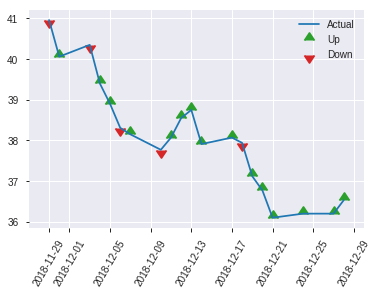


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18748212938432293
RMSE: 0.4329920661909672
LogLoss: 0.5593561418431721
Mean Per-Class Error: 0.2579395325203252
AUC: 0.7921747967479674
pr_auc: 0.7321768577867775
Gini: 0.5843495934959348
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47330212593078613: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   50   0.4065   (50.0/123.0)
1      14   114  0.1094   (14.0/128.0)
Total  87   164  0.255    (64.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473302     0.780822  163
max f2                       0.320309     0.870787  199
max f0point5                 0.580785     0.751689  115
max accuracy                 0.473302     0.74502   163
max precision                0.751856     0.863636  43
max recall                   0.179861     1         234
max specificity              0.902343     0.99187   0
max absolute_mcc             0.473302     0.508546  163
max min_per_class_accuracy   0.567005     0.715447  126
max mean_per_class_accuracy  0.473302     0.74206   163

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 53.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.884174           1.30729    1.30729            0.666667         0.894275  0.666667                    0.894275            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.874584           1.30729    1.30729            0.666667         0.878389  0.666667                    0.886332            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.863259           0.980469   1.22559            0.5              0.868897  0.625                       0.881974            0.0078125       0.0390625                  -1.95312  22.5586
    4        0.0438247                   0.850116           0.653646   1.0696             0.333333         0.854215  0.545455                    0.874403            0.0078125       0.046875                   -34.6354  6.96023
    5        0.0517928                   0.845695           1.96094    1.20673            1                0.847514  0.615385                    0.870266            0.015625        0.0625                     96.0938   20.6731
    6        0.103586                    0.812407           1.8101     1.50841            0.923077         0.827012  0.769231                    0.848639            0.09375         0.15625                    81.0096   50.8413
    7        0.151394                    0.765689           1.96094    1.65132            1                0.791077  0.842105                    0.830462            0.09375         0.25                       96.0938   65.1316
    8        0.203187                    0.730062           1.35757    1.57644            0.692308         0.747964  0.803922                    0.809433            0.0703125       0.320312                   35.7572   57.644
    9        0.302789                    0.658721           1.33344    1.4965             0.68             0.696606  0.763158                    0.772319            0.132812        0.453125                   33.3438   49.6505
    10       0.40239                     0.606943           1.41187    1.47556            0.72             0.628249  0.752475                    0.736658            0.140625        0.59375                    41.1875   47.5557
    11       0.501992                    0.569848           1.17656    1.41623            0.6              0.586168  0.722222                    0.706799            0.117188        0.710938                   17.6562   41.6233
    12       0.601594                    0.504546           1.09813    1.36357            0.56             0.533646  0.695364                    0.678131            0.109375        0.820312                   9.8125    36.3566
    13       0.701195                    0.433863           0.862812   1.29244            0.44             0.468743  0.659091                    0.648388            0.0859375       0.90625                    -13.7188  29.2436
    14       0.800797                    0.320095           0.6275     1.20973            0.32             0.366145  0.616915                    0.613283            0.0625          0.96875                    -37.25    20.9733
    15       0.900398                    0.208725           0.235313   1.10194            0.12             0.272395  0.561947                    0.575575            0.0234375       0.992188                   -76.4688  10.1943
    16       1                           0.0865577          0.0784375  1                  0.04             0.154312  0.50996                     

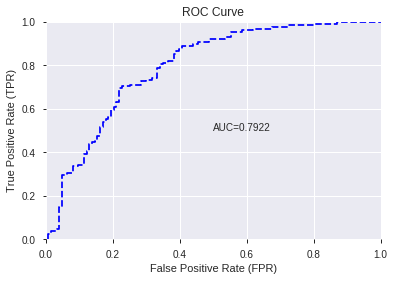

This function is available for GLM models only


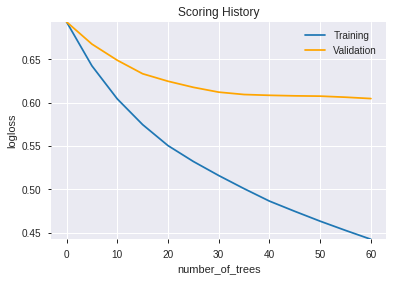

--2019-08-26 17:35:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

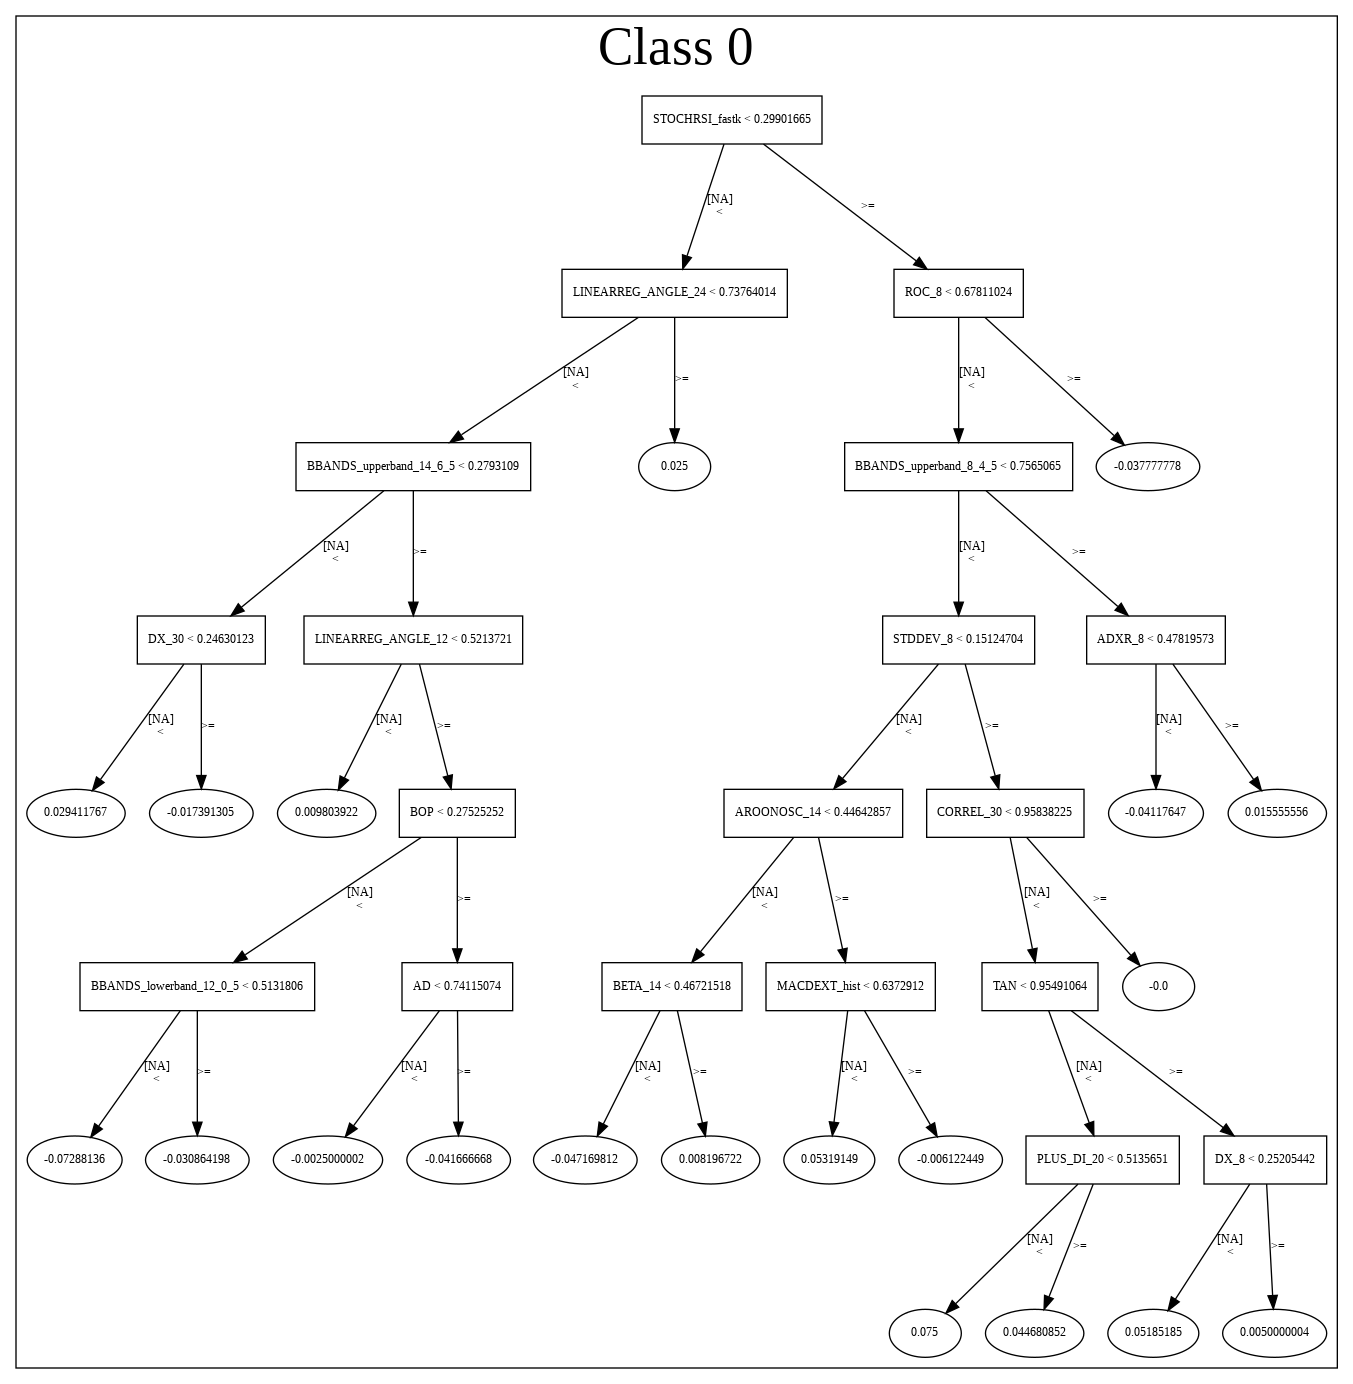

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_173538_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_173538_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DX_14',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'Volume',
 'OBV',
 'AD',
 'ADOSC',
 'CORREL_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'ADX_8',
 'SIN',
 'DX_8',
 'CORREL_30',
 'HT_DCPERIOD',
 'TRANGE',
 'aroonup_8',
 'STOCH_slowd',
 'BETA_8',
 'CDLCLOSINGMARUBOZU',
 'day',
 'ULTOSC',
 'CORREL_20',
 'WILLR_12',
 'ROCP_20',
 'CORREL_24',
 'MOM_20',
 'WILLR_20',
 'dayofweek',
 'STOCHRSI_fastk',
 'WILLR_14',
 'AROONOSC_8',
 'CDLLONGLINE',
 'weekday_name',
 'STOCHF_fastd',
 'CDLBELTHOLD',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLMARUBOZU',
 'CDLSHORTLINE']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


39

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_173600_model_5  0.772993  0.588153              0.311897  0.449149  0.201735
1  DeepLearning_grid_1_AutoML_20190826_173600_model_7  0.772072  0.625447              0.282012  0.456068  0.207998
2  DeepLearning_grid_1_AutoML_20190826_173600_model_8  0.772040  0.577968              0.289825  0.443715  0.196883
3  DeepLearning_grid_1_AutoML_20190826_173600_model_9  0.769563  0.578699              0.273247  0.443971  0.197111
4  DeepLearning_grid_1_AutoML_20190826_173600_model_3  0.766260  0.594915              0.294842  0.444685  0.197745
5  DeepLearning_grid_1_AutoML_20190826_173600_model_2  0.759909  0.616848              0.340352  0.454328  0.206414
6               DeepLearning_1_AutoML_20190826_173600  0.755208  0.602793              0.353182  0.451644  0.203982
7  DeepLearning_grid_1_AutoML_20190826_173600_model_6  0.735963  0.626735              0.305291  0.461914  0.213365
8  DeepLearning_grid_1_AutoML_20190826_173600_model_1  0.728214  0.756624              0.326569  0.488172  0.238312
9  DeepLearning_grid_1_AutoML_20190826_173600_model_4  0.719703  0.667202              0.371761  0.471440  0.222256

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.054510
1   CDLCLOSINGMARUBOZU             0.696887           0.696887    0.037987
2                  SUB             0.651123           0.651123    0.035492
3               TRANGE             0.578997           0.578997    0.031561
4         CDLSHORTLINE             0.544487           0.544487    0.029680
5          CDLLONGLINE             0.539522           0.539522    0.029409
6               ULTOSC             0.534931           0.534931    0.029159
7                  DIV             0.512907           0.512907    0.027958
8       STOCHRSI_fastk             0.503532           0.503532    0.027447
9          CDLMARUBOZU             0.496871           0.496871    0.027084
10             WILLR_8             0.494894           0.494894    0.026976
11               CCI_8             0.486334           0.486334    0.026510
12        STOCHF_fastk             0.460337           0.460337    0.025093
13              CCI_14             0.453508           0.453508    0.024721
14               ADOSC             0.452193           0.452193    0.024649
15        CDLENGULFING             0.452016           0.452016    0.024639
16              CMO_24             0.446506           0.446506    0.024339
17              CCI_12             0.436189           0.436189    0.023777
18              CMO_20             0.434203           0.434203    0.023668
19         CDLBELTHOLD             0.431604           0.431604    0.023527
20            WILLR_12             0.425255           0.425255    0.023180
21            WILLR_30             0.424076           0.424076    0.023116
22              ROCR_8             0.423689           0.423689    0.023095
23            WILLR_24             0.422927           0.422927    0.023054
24               MOM_8             0.418312           0.418312    0.022802
25              RSI_20             0.416771           0.416771    0.022718
26            WILLR_14             0.415929           0.415929    0.022672
27              CCI_20             0.414469           0.414469    0.022593
28               ROC_8             0.408396           0.408396    0.022261
29           ROCR100_8             0.404092           0.404092    0.022027
30            WILLR_20             0.403934           0.403934    0.022018
31              ROCP_8             0.402115           0.402115    0.021919
32              CMO_14             0.401680           0.401680    0.021895
33              RSI_14             0.398944           0.398944    0.021746
34              RSI_24             0.397678           0.397678    0.021677
35               RSI_8             0.397315           0.397315    0.021657
36              CMO_12             0.391399           0.391399    0.021335
37               CMO_8             0.389217           0.389217    0.021216
38              RSI_12             0.382150           0.382150    0.020831

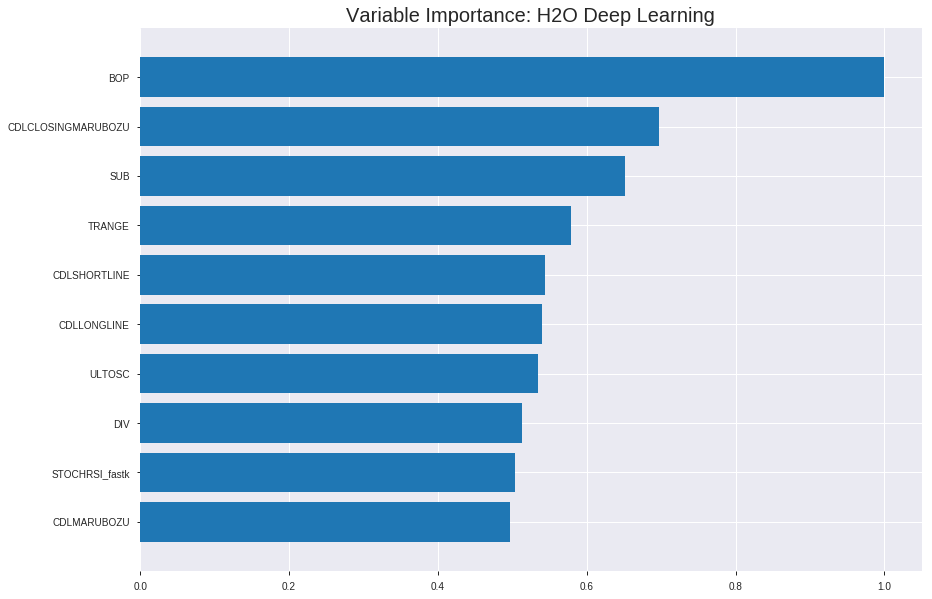

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_173600_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20674506991244182
RMSE: 0.45469228046277826
LogLoss: 0.5952282849564852
Mean Per-Class Error: 0.31570090780031
AUC: 0.7493494314851716
pr_auc: 0.747627005311551
Gini: 0.49869886297034327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35129320236883527: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  475   0.5556   (475.0/855.0)
1      116  782   0.1292   (116.0/898.0)
Total  496  1257  0.3371   (591.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351293     0.725754  264
max f2                       0.191152     0.855724  334
max f0point5                 0.451214     0.688831  205
max accuracy                 0.433948     0.686252  217
max precision                0.980163     1         0
max recall                   0.081304     1         380
max specificity              0.980163     1         0
max absolute_mcc             0.433948     0.373818  217
max min_per_class_accuracy   0.459129     0.672606  200
max mean_per_class_accuracy  0.433948     0.684299  217

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 44.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.953997           1.84366   1.84366            0.944444         0.9691    0.944444                    0.9691              0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.916516           1.84366   1.84366            0.944444         0.935212  0.944444                    0.952156            0.018931        0.0378619                  84.3665   84.3665
    3        0.0302339                   0.883479           1.95212   1.87845            1                0.900431  0.962264                    0.935565            0.018931        0.0567929                  95.2116   87.8451
    4        0.040502                    0.846179           1.95212   1.89713            1                0.865392  0.971831                    0.917774            0.0200445       0.0768374                  95.2116   89.7127
    5        0.0501997                   0.806919           1.72246   1.86338            0.882353         0.828816  0.954545                    0.900589            0.0167038       0.0935412                  72.2455   86.3383
    6        0.100399                    0.667197           1.61937   1.74138            0.829545         0.717929  0.892045                    0.809259            0.0812918       0.174833                   61.9369   74.1376
    7        0.150029                    0.608889           1.52579   1.67006            0.781609         0.639312  0.855513                    0.753041            0.0757238       0.250557                   52.5792   67.0061
    8        0.200228                    0.576846           1.3088    1.57949            0.670455         0.590114  0.809117                    0.712193            0.0657016       0.316258                   30.8805   57.949
    9        0.300057                    0.532295           1.26051   1.47336            0.645714         0.55461   0.754753                    0.659765            0.125835        0.442094                   26.0509   47.3365
    10       0.399886                    0.492779           1.1378    1.38959            0.582857         0.512252  0.71184                     0.622939            0.113586        0.555679                   13.7805   38.9595
    11       0.500285                    0.459285           1.13134   1.33777            0.579545         0.475746  0.685291                    0.5934              0.113586        0.669265                   13.134    33.7767
    12       0.600114                    0.423661           1.07087   1.29337            0.548571         0.442948  0.662548                    0.568372            0.106904        0.776169                   7.0875    29.337
    13       0.699943                    0.363886           0.803156  1.22345            0.411429         0.397084  0.626732                    0.543942            0.0801782       0.856347                   -19.6844  22.3453
    14       0.799772                    0.273826           0.680452  1.15567            0.348571         0.320302  0.592011                    0.516027            0.0679287       0.924276                   -31.9548  15.5675
    15       0.899601                    0.16673            0.568902  1.09056            0.291429         0.224476  0.558656                    0.483674            0.0567929       0.981069                   -43.1098  9.05606
    16       1                           0.0178133          0.188557  1                  0.0965909        0.104912  0.512265                    0.445646           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2186105081465311
RMSE: 0.46755802650209216
LogLoss: 0.625311821721172
Mean Per-Class Error: 0.34547413793103443
AUC: 0.7147190293742017
pr_auc: 0.7171242907620198
Gini: 0.42943805874840346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30095673670443873: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      72   168  0.7      (168.0/240.0)
1      15   246  0.0575   (15.0/261.0)
Total  87   414  0.3653   (183.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300957     0.728889  315
max f2                       0.0916744    0.850717  389
max f0point5                 0.484234     0.672461  166
max accuracy                 0.422981     0.658683  233
max precision                0.983951     1         0
max recall                   0.0916744    1         389
max specificity              0.983951     1         0
max absolute_mcc             0.374971     0.325856  266
max min_per_class_accuracy   0.463841     0.6375    194
max mean_per_class_accuracy  0.484234     0.654526  166

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 44.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.947044           1.59962   1.59962            0.833333         0.963582  0.833333                    0.963582            0.0191571       0.0191571                  59.9617   59.9617
    2        0.0219561                   0.842551           1.91954   1.74504            1                0.913033  0.909091                    0.940606            0.0191571       0.0383142                  91.954    74.5037
    3        0.0319361                   0.80932            1.91954   1.79957            1                0.82374   0.9375                      0.904085            0.0191571       0.0574713                  91.954    79.9569
    4        0.0419162                   0.766531           1.91954   1.82813            1                0.784402  0.952381                    0.875589            0.0191571       0.0766284                  91.954    82.8134
    5        0.0518962                   0.702018           1.91954   1.84571            1                0.743784  0.961538                    0.850242            0.0191571       0.0957854                  91.954    84.5712
    6        0.101796                    0.645483           1.22851   1.54316            0.64             0.673946  0.803922                    0.763822            0.0613027       0.157088                   22.8506   54.316
    7        0.151697                    0.597463           1.53563   1.54068            0.8              0.617044  0.802632                    0.71554             0.0766284       0.233716                   53.5632   54.0684
    8        0.201597                    0.558889           1.22851   1.46341            0.64             0.57838   0.762376                    0.68159             0.0613027       0.295019                   22.8506   46.3412
    9        0.301397                    0.518803           1.22851   1.38563            0.64             0.539053  0.721854                    0.634392            0.122605        0.417625                   22.8506   38.5628
    10       0.401198                    0.489969           1.2669    1.35609            0.66             0.50419   0.706468                    0.602003            0.126437        0.544061                   26.6897   35.6093
    11       0.500998                    0.465385           0.882989  1.26185            0.46             0.476873  0.657371                    0.577077            0.0881226       0.632184                   -11.7011  26.1849
    12       0.600798                    0.429372           1.07494   1.2308             0.56             0.449009  0.641196                    0.555803            0.10728         0.739464                   7.49425   23.0802
    13       0.700599                    0.381113           1.03655   1.20313            0.54             0.40677   0.626781                    0.534573            0.103448        0.842912                   3.65517   20.3131
    14       0.800399                    0.316648           0.767816  1.14885            0.4              0.346006  0.598504                    0.511061            0.0766284       0.91954                    -23.2184  14.8852
    15       0.9002                      0.199424           0.46069   1.07256            0.24             0.267132  0.558758                    0.484018            0.045977        0.965517                   -53.931   7.25591
    16       1                           0.0173385          0.345517  1                  0.18             0.131157  0.520958                    0.448803          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:39:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:39:48  1 min 54.546 sec  1162 obs/sec      1.37992   1             2419       0.473015         0.637635            0.104488       0.733316        0.743583           1.95212          0.357102                         0.481548           0.655561              0.0708154        0.716539          0.724484             1.91954            0.361277
    2019-08-26 17:39:56  2 min  2.957 sec  1979 obs/sec      10.9492   8             19194      0.454692         0.595228            0.172522       0.749349        0.747627           1.84366          0.337136                         0.467558           0.625312              0.124019         0.714719          0.717124             1.59962            0.365269
    2019-08-26 17:40:04  2 min 11.182 sec  2247 obs/sec      21.9333   16            38449      0.4531           0.591666            0.178306       0.762272        0.764679           1.95212          0.322875                         0.467652           0.627811              0.123666         0.735145          0.731035             1.59962            0.341317
    2019-08-26 17:40:12  2 min 19.331 sec  2358 obs/sec      32.9532   24            57767      0.449111         0.583508            0.192712       0.754396        0.75969            1.73521          0.333143                         0.468424           0.629682              0.120769         0.711662          0.709338             1.59962            0.341317
    2019-08-26 17:40:20  2 min 27.414 sec  2431 obs/sec      43.8528   32            76874      0.446366         0.576075            0.202551       0.762858        0.77288            1.95212          0.321164                         0.470348           0.632351              0.113532         0.708916          0.707662             1.91954            0.367265
    2019-08-26 17:40:31  2 min 37.443 sec  2516 obs/sec      58.6965   43            102895     0.439276         0.561017            0.227683       0.788127        0.795548           1.95212          0.32858                          0.469318           0.631157              0.117413         0.714727          0.716764             1.91954            0.357285
    2019-08-26 17:40:31  2 min 38.217 sec  2515 obs/sec      58.6965   43            102895     0.454692         0.595228            0.172522       0.749349        0.747627           1.84366          0.337136                         0.467558           0.625312              0.124019         0.714719          0.717124             1.59962            0.365269

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.054509609460360285
CDLCLOSINGMARUBOZU  0.6968870759010315     0.6968870759010315   0.03798704234533768
SUB                 0.6511232256889343     0.6511232256889343   0.03549247274287384
TRANGE              0.5789967775344849     0.5789967775344849   0.031560888222211876
CDLSHORTLINE        0.544486939907074      0.544486939907074    0.029679770450601262
---                 ---                    ---                  ---
RSI_24              0.39767831563949585    0.39767831563949585  0.02167728967636281
RSI_8               0.39731472730636597    0.39731472730636597  0.021657470618319553
CMO_12              0.391399085521698      0.391399085521698    0.021335011294929915
CMO_8               0.3892174959182739     0.3892174959182739   0.021216093697644486
RSI_12              0.3821500241756439     0.3821500241756439   0.02083084857308159


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7586206896551724)

('auc', 0.7729928861788617)

('logloss', 0.5881531313147359)

('mean_per_class_error', 0.2683879573170731)

('rmse', 0.44914929646617896)

('mse', 0.2017350905160635)

deeplearning prediction progress: |███████████████████████████████████████| 100%


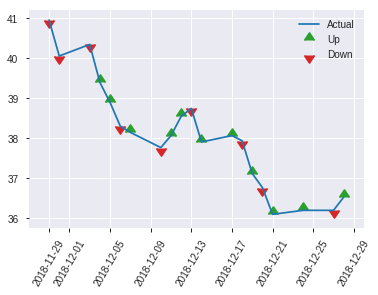


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2017350905160635
RMSE: 0.44914929646617896
LogLoss: 0.5881531313147359
Mean Per-Class Error: 0.2683879573170731
AUC: 0.7729928861788617
pr_auc: 0.7375282270744615
Gini: 0.5459857723577235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32343034438918394: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   70   0.5691   (70.0/123.0)
1      7    121  0.0547   (7.0/128.0)
Total  60   191  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32343      0.758621  190
max f2                       0.32343      0.860597  190
max f0point5                 0.434481     0.727401  144
max accuracy                 0.434481     0.733068  144
max precision                0.966673     1         0
max recall                   0.0949116    1         238
max specificity              0.966673     1         0
max absolute_mcc             0.433686     0.469759  146
max min_per_class_accuracy   0.460382     0.682927  126
max mean_per_class_accuracy  0.434481     0.731612  144

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 45.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.956446           1.30729   1.30729            0.666667         0.964847  0.666667                    0.964847            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.930511           1.96094   1.63411            1                0.939942  0.833333                    0.952394            0.0234375       0.0390625                  96.0938   63.4115
    3        0.0318725                   0.909962           1.96094   1.71582            1                0.921714  0.875                       0.944724            0.015625        0.0546875                  96.0938   71.582
    4        0.0438247                   0.867904           1.96094   1.78267            1                0.886992  0.909091                    0.928979            0.0234375       0.078125                   96.0938   78.267
    5        0.0517928                   0.800869           1.96094   1.8101             1                0.830937  0.923077                    0.913896            0.015625        0.09375                    96.0938   81.0096
    6        0.103586                    0.681185           1.35757   1.58383            0.692308         0.72058   0.807692                    0.817238            0.0703125       0.164062                   35.7572   58.3834
    7        0.151394                    0.626918           1.63411   1.59971            0.833333         0.650886  0.815789                    0.764706            0.078125        0.242188                   63.4115   59.9712
    8        0.203187                    0.572468           1.50841   1.57644            0.769231         0.603278  0.803922                    0.723558            0.078125        0.320312                   50.8413   57.644
    9        0.302789                    0.535271           1.41187   1.52231            0.72             0.555625  0.776316                    0.668317            0.140625        0.460938                   41.1875   52.2307
    10       0.40239                     0.485002           1.17656   1.43673            0.6              0.505906  0.732673                    0.628116            0.117188        0.578125                   17.6562   43.6726
    11       0.501992                    0.460499           1.01969   1.35398            0.52             0.46898   0.690476                    0.596541            0.101562        0.679688                   1.96875   35.3981
    12       0.601594                    0.422861           1.41187   1.36357            0.72             0.443303  0.695364                    0.571171            0.140625        0.820312                   41.1875   36.3566
    13       0.701195                    0.383214           0.549063  1.24787            0.28             0.404049  0.636364                    0.547432            0.0546875       0.875                      -45.0938  24.7869
    14       0.800797                    0.287473           0.784375  1.19022            0.4              0.329397  0.606965                    0.520313            0.078125        0.953125                   -21.5625  19.0221
    15       0.900398                    0.18528            0.235313  1.08459            0.12             0.248005  0.553097                    0.49019             0.0234375       0.976562                   -76.4688  8.45893
    16       1                           0.0321467          0.235313  1                  0.12             0.102592  0.50996                     0.451585            

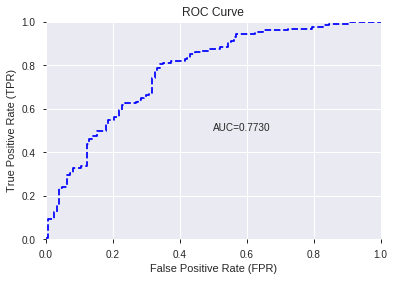

This function is available for GLM models only


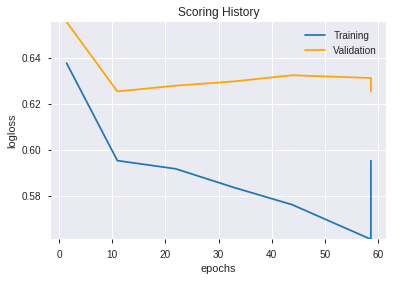

--2019-08-26 17:45:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


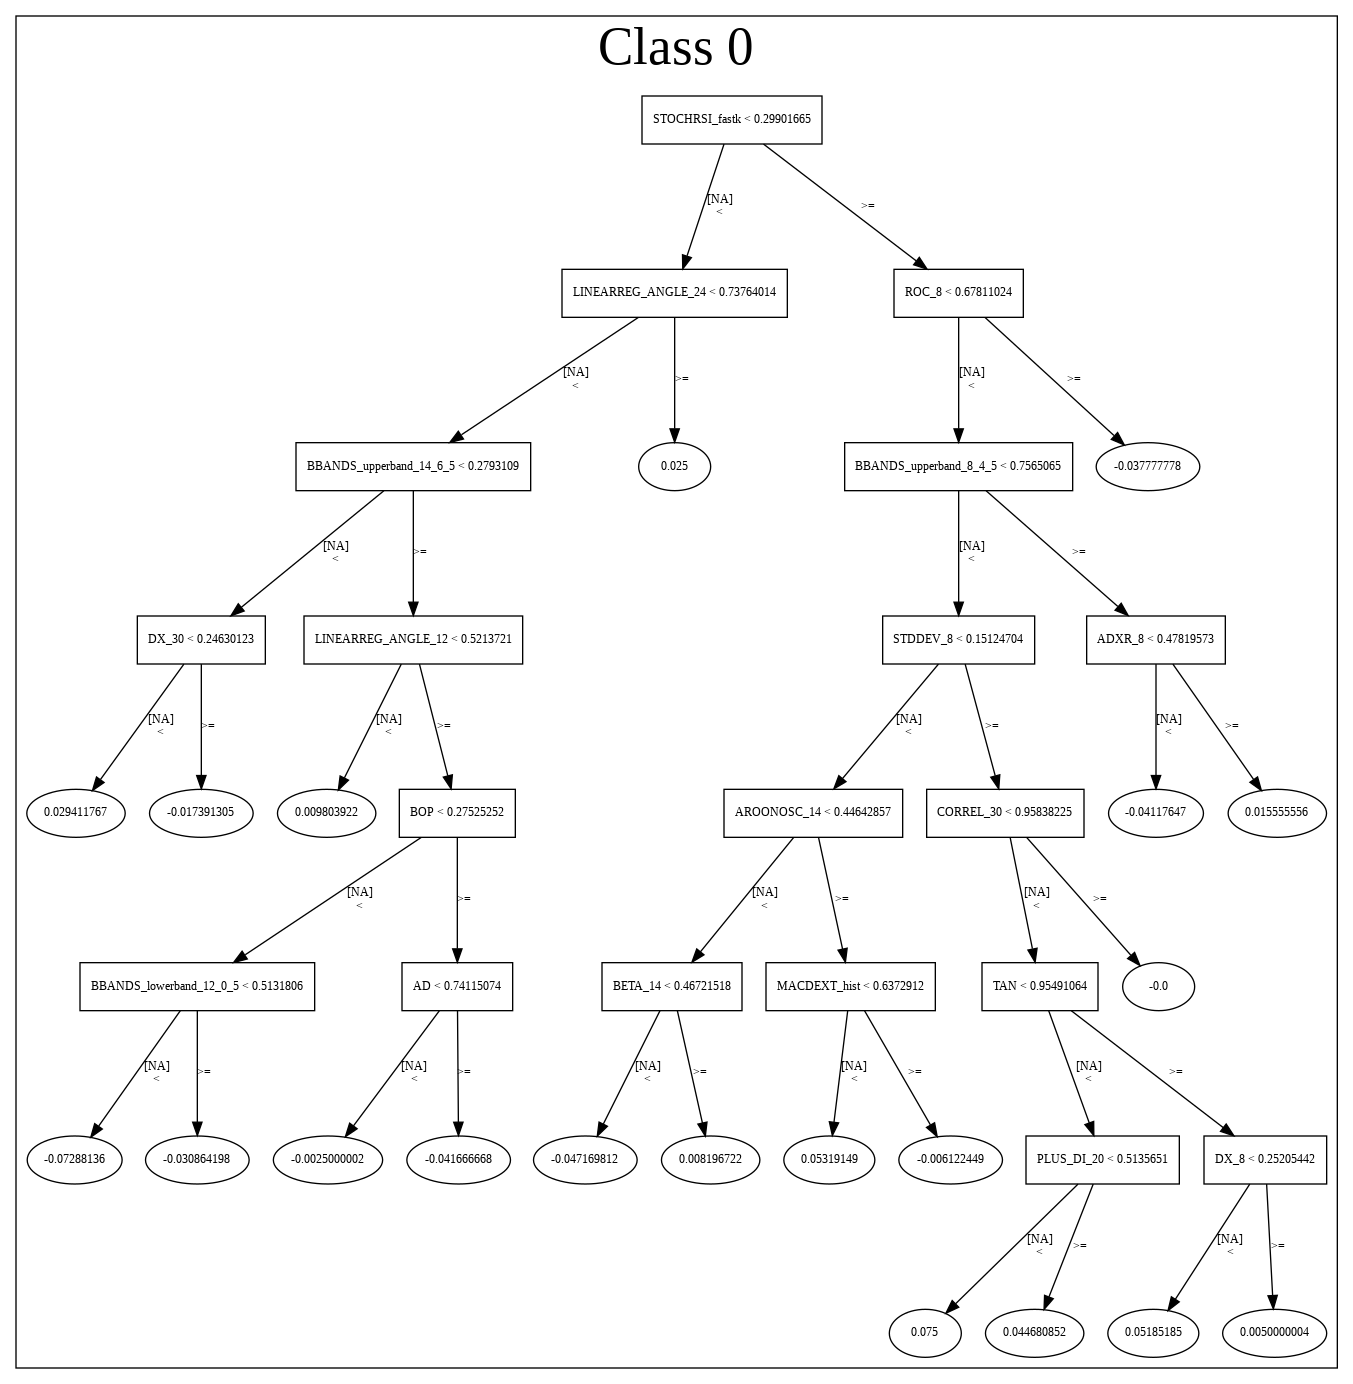

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_173600_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_173600_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'TRANGE',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'ULTOSC',
 'DIV',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'WILLR_8',
 'CCI_8',
 'STOCHF_fastk',
 'CCI_14',
 'ADOSC',
 'CDLENGULFING',
 'CMO_24',
 'CCI_12',
 'CMO_20',
 'CDLBELTHOLD',
 'WILLR_12',
 'WILLR_30',
 'ROCR_8',
 'WILLR_24',
 'MOM_8',
 'RSI_20',
 'WILLR_14',
 'CCI_20',
 'ROC_8',
 'ROCR100_8',
 'WILLR_20',
 'ROCP_8',
 'CMO_14',
 'RSI_14',
 'RSI_24',
 'RSI_8',
 'CMO_12',
 'CMO_8',
 'RSI_12']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_174601_model_1  0.788935  0.562835              0.277312  0.435252  0.189444

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.597405           1.000000    0.190973
1                  SUB             0.217053           0.363326    0.069385
2              WILLR_8             0.191773           0.321010    0.061304
3   CDLCLOSINGMARUBOZU             0.185686           0.310821    0.059358
4               ULTOSC             0.174511           0.292114    0.055786
5          CDLLONGLINE             0.158643           0.265554    0.050714
6                CCI_8             0.139062           0.232777    0.044454
7               CCI_12             0.121785           0.203856    0.038931
8         STOCHF_fastk             0.112244           0.187886    0.035881
9          CDLBELTHOLD             0.097299           0.162869    0.031104
10               MOM_8             0.089158           0.149242    0.028501
11            WILLR_20             0.081898           0.137089    0.026180
12            WILLR_30             0.080648           0.134997    0.025781
13              TRANGE             0.078210           0.130917    0.025002
14              CCI_14             0.072115           0.120713    0.023053
15                 DIV             0.071867           0.120299    0.022974
16        CDLENGULFING             0.070241           0.117577    0.022454
17            WILLR_14             0.066701           0.111652    0.021322
18               CMO_8             0.063404           0.106132    0.020268
19               RSI_8             0.061922           0.103652    0.019795
20         CDLMARUBOZU             0.050720           0.084901    0.016214
21              CCI_20             0.048725           0.081560    0.015576
22            WILLR_12             0.040220           0.067324    0.012857
23              RSI_12             0.040087           0.067102    0.012815
24              CMO_12             0.038603           0.064618    0.012340
25              RSI_14             0.031012           0.051910    0.009913
26              CMO_14             0.030090           0.050368    0.009619
27      STOCHRSI_fastk             0.028620           0.047906    0.009149
28               ADOSC             0.025131           0.042067    0.008034
29            WILLR_24             0.024295           0.040668    0.007767
30        CDLSHORTLINE             0.008539           0.014293    0.002730
31               ROC_8             0.004719           0.007898    0.001508
32              CMO_20             0.004679           0.007832    0.001496
33              ROCP_8             0.004586           0.007677    0.001466
34              ROCR_8             0.004394           0.007355    0.001405
35           ROCR100_8             0.004387           0.007343    0.001402
36              RSI_20             0.004009           0.006711    0.001282
37              RSI_24             0.002179           0.003648    0.000697
38              CMO_24             0.001602           0.002682    0.000512

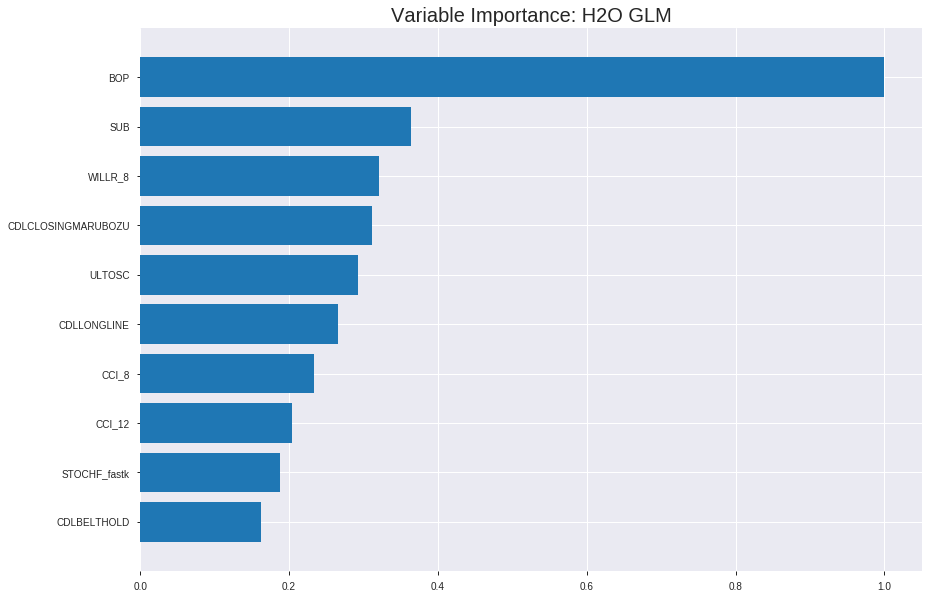

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_174601_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20045105715385234
RMSE: 0.4477176087154182
LogLoss: 0.5840636767503844
Null degrees of freedom: 1752
Residual degrees of freedom: 1713
Null deviance: 2429.1191459812417
Residual deviance: 2047.7272506868476
AIC: 2127.7272506868476
AUC: 0.7549362455879863
pr_auc: 0.7531725895140834
Gini: 0.5098724911759727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40984109776093297: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      416  439   0.5135   (439.0/855.0)
1      123  775   0.137    (123.0/898.0)
Total  539  1214  0.3206   (562.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409841     0.733902  253
max f2                       0.140304     0.851205  369
max f0point5                 0.54882      0.69678   179
max accuracy                 0.443951     0.691957  233
max precision                0.937661     1         0
max recall                   0.111687     1         378
max specificity              0.937661     1         0
max absolute_mcc             0.443951     0.392047  233
max min_per_class_accuracy   0.525664     0.676023  191
max mean_per_class_accuracy  0.466847     0.688974  221

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.904314           1.84366   1.84366            0.944444         0.915643  0.944444                    0.915643            0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.89064            1.84366   1.84366            0.944444         0.896032  0.944444                    0.905838            0.018931        0.0378619                  84.3665   84.3665
    3        0.0302339                   0.870684           1.83729   1.84162            0.941176         0.878792  0.943396                    0.897163            0.0178174       0.0556793                  83.7285   84.1619
    4        0.040502                    0.853514           1.84366   1.84214            0.944444         0.861767  0.943662                    0.888189            0.018931        0.0746102                  84.3665   84.2137
    5        0.0501997                   0.832442           1.72246   1.81902            0.882353         0.844801  0.931818                    0.879807            0.0167038       0.091314                   72.2455   81.9017
    6        0.100399                    0.773872           1.59719   1.7081             0.818182         0.80043   0.875                       0.840119            0.0801782       0.171492                   59.7186   70.8101
    7        0.150029                    0.732373           1.48092   1.63295            0.758621         0.753662  0.836502                    0.811519            0.0734967       0.244989                   48.0915   63.2949
    8        0.200228                    0.699943           1.37535   1.56837            0.704545         0.715841  0.803419                    0.787531            0.0690423       0.314031                   37.5354   56.8367
    9        0.300057                    0.637656           1.28282   1.47336            0.657143         0.666152  0.754753                    0.747149            0.128062        0.442094                   28.2819   47.3365
    10       0.399886                    0.58531            1.27166   1.42301            0.651429         0.612085  0.728959                    0.713431            0.126949        0.569042                   27.1664   42.3012
    11       0.500285                    0.527859           1.04261   1.34667            0.534091         0.557645  0.689852                    0.682167            0.104677        0.673719                   4.26073   34.6671
    12       0.600114                    0.467115           1.09318   1.3045             0.56             0.499977  0.668251                    0.65186             0.109131        0.782851                   9.31849   30.4503
    13       0.699943                    0.402701           0.836621  1.23777            0.428571         0.435464  0.634067                    0.620997            0.0835189       0.86637                    -16.3379  23.7772
    14       0.799772                    0.325799           0.624677  1.16124            0.32             0.367697  0.594864                    0.589379            0.0623608       0.928731                   -37.5323  16.1244
    15       0.899601                    0.210933           0.435043  1.08066            0.222857         0.267052  0.553583                    0.553611            0.0434298       0.97216                    -56.4957  8.06576
    16       1                           0.0286703          0.277289  1                  0.142045         0.141797  0.512265                    0.512265         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20810055359799332
RMSE: 0.45618039589398546
LogLoss: 0.602555860452518
Null degrees of freedom: 500
Residual degrees of freedom: 461
Null deviance: 693.804571947685
Residual deviance: 603.760972173423
AIC: 683.760972173423
AUC: 0.7340517241379311
pr_auc: 0.7389369284040175
Gini: 0.46810344827586214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35555222088812943: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      84   156  0.65     (156.0/240.0)
1      19   242  0.0728   (19.0/261.0)
Total  103  398  0.3493   (175.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355552     0.734446  307
max f2                       0.296188     0.85473   337
max f0point5                 0.602866     0.688299  149
max accuracy                 0.42961      0.674651  264
max precision                0.937535     1         0
max recall                   0.1117       1         387
max specificity              0.937535     1         0
max absolute_mcc             0.42961      0.359964  264
max min_per_class_accuracy   0.525766     0.655172  198
max mean_per_class_accuracy  0.42961      0.667122  264

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.895645           1.91954   1.91954            1                0.918017  1                           0.918017            0.0229885       0.0229885                  91.954     91.954
    2        0.0219561                   0.867938           1.53563   1.74504            0.8              0.874454  0.909091                    0.898215            0.0153257       0.0383142                  53.5632    74.5037
    3        0.0319361                   0.839494           1.91954   1.79957            1                0.850703  0.9375                      0.883368            0.0191571       0.0574713                  91.954     79.9569
    4        0.0419162                   0.825197           1.91954   1.82813            1                0.830518  0.952381                    0.870784            0.0191571       0.0766284                  91.954     82.8134
    5        0.0518962                   0.812068           1.91954   1.84571            1                0.816993  0.961538                    0.86044             0.0191571       0.0957854                  91.954     84.5712
    6        0.101796                    0.757553           1.30529   1.5808             0.68             0.780992  0.823529                    0.821495            0.0651341       0.16092                    30.5287    58.0798
    7        0.151697                    0.724786           1.6892    1.61645            0.88             0.739333  0.842105                    0.794468            0.0842912       0.245211                   68.9195    61.6455
    8        0.201597                    0.689954           1.07494   1.48242            0.56             0.704885  0.772277                    0.772294            0.0536398       0.298851                   7.49425    48.2417
    9        0.301397                    0.635009           1.42046   1.4619             0.74             0.657503  0.761589                    0.734284            0.141762        0.440613                   42.046     46.1901
    10       0.401198                    0.591721           1.03655   1.35609            0.54             0.61244   0.706468                    0.703974            0.103448        0.544061                   3.65517    35.6093
    11       0.500998                    0.529275           1.07494   1.30009            0.56             0.558922  0.677291                    0.675079            0.10728         0.651341                   7.49425    30.0087
    12       0.600798                    0.48362            1.03655   1.25631            0.54             0.506229  0.654485                    0.647031            0.103448        0.754789                   3.65517    25.631
    13       0.700599                    0.412852           0.998161  1.21954            0.52             0.452544  0.635328                    0.619326            0.0996169       0.854406                   -0.183908  21.9537
    14       0.800399                    0.354016           0.729425  1.15843            0.38             0.381477  0.603491                    0.589669            0.0727969       0.927203                   -27.0575   15.8426
    15       0.9002                      0.264917           0.46069   1.08107            0.24             0.310437  0.563193                    0.558712            0.045977        0.97318                    -53.931    8.10714
    16       1                           0.0377997          0.268736  1                  0.14             0.164102  0.520958                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:46:01  0.000 sec   2            20        40            1.36458           1.36973
    2019-08-26 17:46:01  0.009 sec   4            12        40            1.35538           1.36284
    2019-08-26 17:46:01  0.018 sec   6            7.7       40            1.34362           1.35365
    2019-08-26 17:46:01  0.027 sec   8            4.8       40            1.32915           1.34175
    2019-08-26 17:46:01  0.035 sec   10           3         40            1.3119            1.32674
    2019-08-26 17:46:01  0.043 sec   12           1.8       40            1.29212           1.30864
    2019-08-26 17:46:01  0.051 sec   14           1.1       40            1.27076           1.28831
    2019-08-26 17:46:01  0.058 sec   16           0.71      40            1.24936           1.26751
    2019-08-26 17:46:01  0.066 sec   18           0.44      40            1.22958           1.24829
    2019-08-26 17:46:01  0.074 sec   20           0.27      40            1.21254           1.23222
    2019-08-26 17:46:01  0.083 sec   22           0.17      40            1.1986            1.22012
    2019-08-26 17:46:01  0.091 sec   24           0.11      40            1.18761           1.212
    2019-08-26 17:46:01  0.099 sec   26           0.066     40            1.17917           1.20725
    2019-08-26 17:46:01  0.107 sec   28           0.041     40            1.1728            1.20521
    2019-08-26 17:46:01  0.114 sec   30           0.025     40            1.16813           1.20511
    2019-08-26 17:46:01  0.122 sec   32           0.016     40            1.16475           1.20669
    2019-08-26 17:46:01  0.133 sec   34           0.0098    40            1.16237           1.20936
    2019-08-26 17:46:01  0.145 sec   36           0.0061    40            1.16068           1.2123
    2019-08-26 17:46:01  0.153 sec   38           0.0038    40            1.15949           1.21523
    2019-08-26 17:46:01  0.162 sec   40           0.0023    40            1.15867           1.21805

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7250996015936255)

('F1', 0.7578947368421054)

('auc', 0.7889354674796748)

('logloss', 0.5628349597351001)

('mean_per_class_error', 0.27350101626016254)

('rmse', 0.4352519121679316)

('mse', 0.18944422704584082)

glm prediction progress: |████████████████████████████████████████████████| 100%


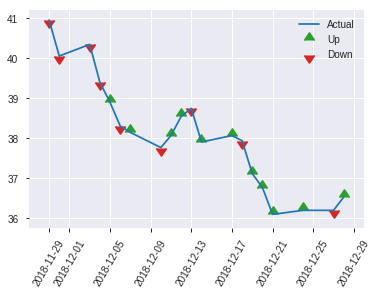


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18944422704584082
RMSE: 0.4352519121679316
LogLoss: 0.5628349597351001
Null degrees of freedom: 250
Residual degrees of freedom: 211
Null deviance: 347.8656113866541
Residual deviance: 282.54314978702024
AIC: 362.54314978702024
AUC: 0.7889354674796748
pr_auc: 0.7523821667163231
Gini: 0.5778709349593496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4704175868581605: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   49   0.3984   (49.0/123.0)
1      20   108  0.1562   (20.0/128.0)
Total  94   157  0.2749   (69.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470418     0.757895  156
max f2                       0.299082     0.865651  209
max f0point5                 0.579061     0.744681  108
max accuracy                 0.579061     0.7251    108
max precision                0.926851     1         0
max recall                   0.0879382    1         247
max specificity              0.926851     1         0
max absolute_mcc             0.470418     0.460014  156
max min_per_class_accuracy   0.541647     0.703125  124
max mean_per_class_accuracy  0.579061     0.726499  108

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.906566           1.30729   1.30729            0.666667         0.920878  0.666667                    0.920878            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.899891           1.30729   1.30729            0.666667         0.901524  0.666667                    0.911201            0.015625        0.03125                    30.7292   30.7292
    3        0.0318725                   0.89517            1.96094   1.4707             1                0.896316  0.75                        0.90748             0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.889181           1.96094   1.6044             1                0.892147  0.818182                    0.903298            0.0234375       0.0703125                  96.0938   60.4403
    5        0.0517928                   0.857407           1.96094   1.65925            1                0.877479  0.846154                    0.899326            0.015625        0.0859375                  96.0938   65.9255
    6        0.103586                    0.791338           1.8101    1.73468            0.923077         0.816637  0.884615                    0.857982            0.09375         0.179688                   81.0096   73.4675
    7        0.151394                    0.749342           1.4707    1.65132            0.75             0.76885   0.842105                    0.829835            0.0703125       0.25                       47.0703   65.1316
    8        0.203187                    0.714124           1.50841   1.61489            0.769231         0.727951  0.823529                    0.803864            0.078125        0.328125                   50.8413   61.489
    9        0.302789                    0.665299           1.49031   1.57391            0.76             0.683795  0.802632                    0.764368            0.148438        0.476562                   49.0313   57.391
    10       0.40239                     0.599242           1.33344   1.51439            0.68             0.627294  0.772277                    0.730439            0.132812        0.609375                   33.3438   51.4387
    11       0.501992                    0.541397           0.94125   1.40067            0.48             0.566492  0.714286                    0.697909            0.09375         0.703125                   -5.875    40.067
    12       0.601594                    0.486594           1.09813   1.35058            0.56             0.512934  0.688742                    0.667284            0.109375        0.8125                     9.8125    35.0579
    13       0.701195                    0.413757           0.784375  1.27015            0.4              0.450667  0.647727                    0.636515            0.078125        0.890625                   -21.5625  27.0153
    14       0.800797                    0.346323           0.6275    1.19022            0.32             0.375346  0.606965                    0.604031            0.0625          0.953125                   -37.25    19.0221
    15       0.900398                    0.200731           0.31375   1.09327            0.16             0.27925   0.557522                    0.568104            0.03125         0.984375                   -68.625   9.3266
    16       1                           0.0399076          0.156875  1                  0.08             0.13605   0.50996                     0.525071            0

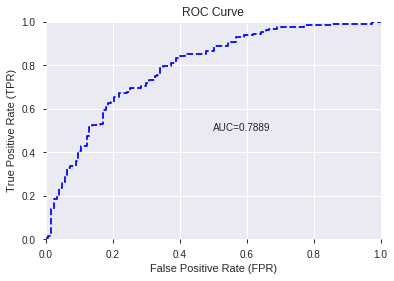

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


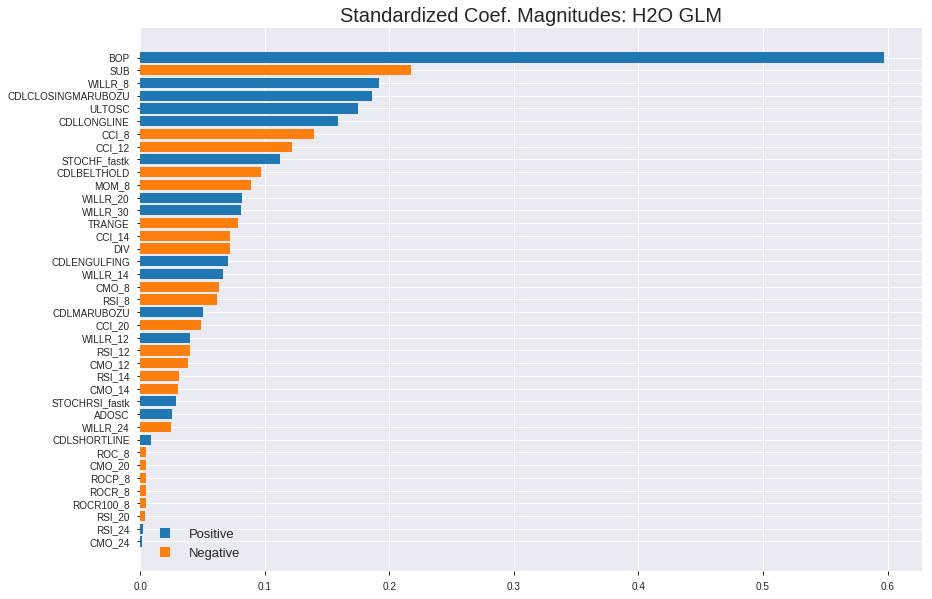

'log_likelihood'
--2019-08-26 17:46:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.65.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.65.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


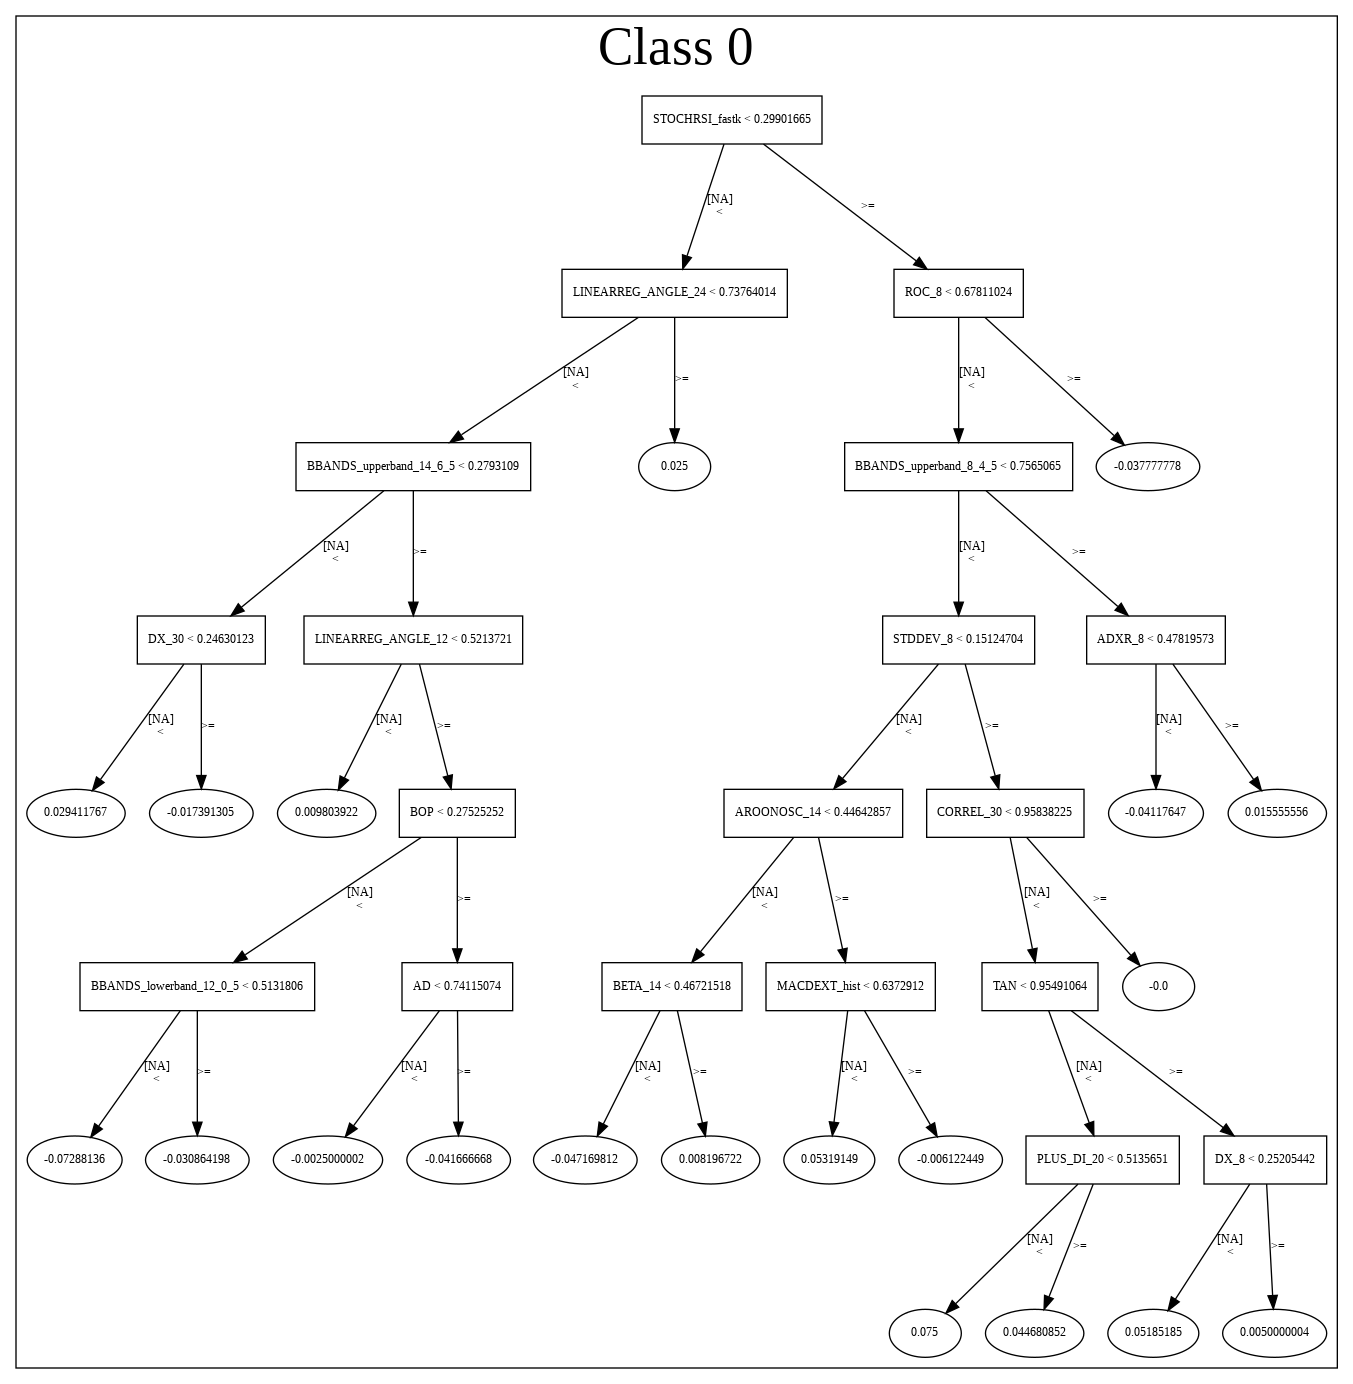

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_174601_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_174601_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CDLLONGLINE',
 'CCI_8',
 'CCI_12',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'MOM_8',
 'WILLR_20',
 'WILLR_30',
 'TRANGE',
 'CCI_14',
 'DIV',
 'CDLENGULFING',
 'WILLR_14',
 'CMO_8',
 'RSI_8',
 'CDLMARUBOZU',
 'CCI_20',
 'WILLR_12',
 'RSI_12',
 'CMO_12',
 'RSI_14',
 'CMO_14',
 'STOCHRSI_fastk',
 'ADOSC',
 'WILLR_24',
 'CDLSHORTLINE',
 'ROC_8',
 'CMO_20',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_20',
 'RSI_24',
 'CMO_24']

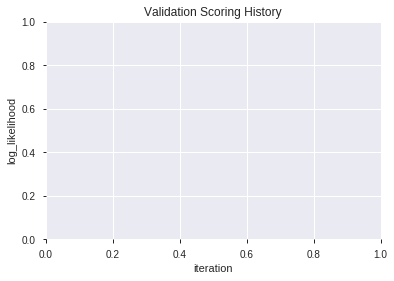

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_174611_model_4  0.780170  0.573034              0.286395  0.440416  0.193966
1  XGBoost_grid_1_AutoML_20190826_174611_model_2  0.775152  0.575806              0.314850  0.442437  0.195751
2               XGBoost_1_AutoML_20190826_174611  0.771977  0.572494              0.298590  0.440592  0.194121
3  XGBoost_grid_1_AutoML_20190826_174611_model_6  0.771405  0.574890              0.307038  0.441954  0.195323
4               XGBoost_3_AutoML_20190826_174611  0.768293  0.582752              0.276518  0.445243  0.198241
5               XGBoost_2_AutoML_20190826_174611  0.766768  0.578792              0.282012  0.443712  0.196880
6  XGBoost_grid_1_AutoML_20190826_174611_model_3  0.764291  0.577867              0.281377  0.443208  0.196433
7  XGBoost_grid_1_AutoML_20190826_174611_model_7  0.763529  0.578161              0.289983  0.443719  0.196886
8  XGBoost_grid_1_AutoML_20190826_174611_model_1  0.747650  0.591682              0.327839  0.450376  0.202839
9  XGBoost_grid_1_AutoML_20190826_174611_model_5  0.739202  0.609008              0.322345  0.455785  0.207740

variable  relative_importance  scaled_importance  percentage
0                  BOP          2130.255371           1.000000    0.456564
1                  SUB           398.020233           0.186842    0.085305
2                  DIV           216.396042           0.101582    0.046379
3              WILLR_8           206.273666           0.096830    0.044209
4                CCI_8           205.518234           0.096476    0.044047
5                MOM_8           153.868454           0.072230    0.032978
6               TRANGE           120.931183           0.056768    0.025918
7                ADOSC           113.698235           0.053373    0.024368
8               ULTOSC           111.522758           0.052352    0.023902
9               CCI_14           103.427055           0.048551    0.022167
10        STOCHF_fastk            94.680748           0.044446    0.020292
11               ROC_8            88.696899           0.041637    0.019010
12      STOCHRSI_fastk            85.307388           0.040046    0.018283
13               CMO_8            84.855789           0.039834    0.018187
14              CMO_20            81.904968           0.038448    0.017554
15  CDLCLOSINGMARUBOZU            62.977268           0.029563    0.013498
16              CCI_20            60.896805           0.028587    0.013052
17            WILLR_24            53.841629           0.025275    0.011540
18              CCI_12            51.994152           0.024407    0.011144
19            WILLR_30            50.732018           0.023815    0.010873
20              CMO_24            40.300056           0.018918    0.008637
21            WILLR_20            27.442654           0.012882    0.005882
22              CMO_12            27.389473           0.012857    0.005870
23              CMO_14            27.298296           0.012815    0.005851
24            WILLR_14            25.652227           0.012042    0.005498
25            WILLR_12            25.571875           0.012004    0.005481
26         CDLLONGLINE            16.384813           0.007691    0.003512

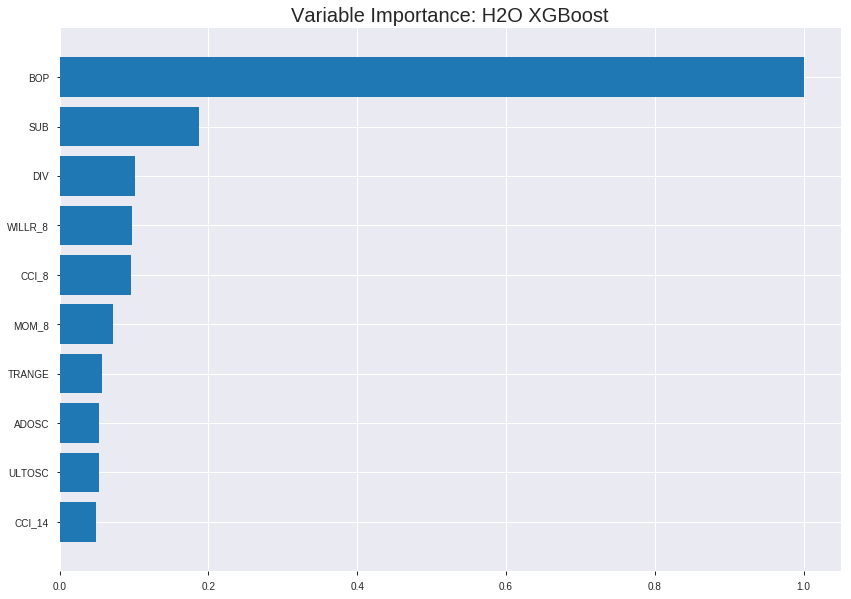

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_174611_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18191070646619387
RMSE: 0.4265099136786786
LogLoss: 0.5437430328191046
Mean Per-Class Error: 0.26641659828859454
AUC: 0.8094869690931114
pr_auc: 0.8078932536111963
Gini: 0.6189739381862227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3958014488220215: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  415   0.4854   (415.0/855.0)
1      88   810   0.098    (88.0/898.0)
Total  528  1225  0.2869   (503.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395801     0.763071  265
max f2                       0.244534     0.859482  339
max f0point5                 0.591904     0.746087  154
max accuracy                 0.476887     0.735311  220
max precision                0.867963     1         0
max recall                   0.161933     1         375
max specificity              0.867963     1         0
max absolute_mcc             0.473166     0.47313   222
max min_per_class_accuracy   0.527361     0.728285  193
max mean_per_class_accuracy  0.476887     0.733583  220

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.845172           1.84366   1.84366            0.944444         0.853182  0.944444                    0.853182            0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.832755           1.84366   1.84366            0.944444         0.837977  0.944444                    0.845579            0.018931        0.0378619                  84.3665   84.3665
    3        0.0302339                   0.826918           1.83729   1.84162            0.941176         0.829794  0.943396                    0.840516            0.0178174       0.0556793                  83.7285   84.1619
    4        0.040502                    0.818612           1.95212   1.86963            1                0.822303  0.957746                    0.835899            0.0200445       0.0757238                  95.2116   86.9632
    5        0.0501997                   0.809441           1.83729   1.86338            0.941176         0.813248  0.954545                    0.831523            0.0178174       0.0935412                  83.7285   86.3383
    6        0.100399                    0.779144           1.81902   1.8412             0.931818         0.79529   0.943182                    0.813407            0.091314        0.184855                   81.9017   84.12
    7        0.150029                    0.751263           1.54823   1.74429            0.793103         0.76466   0.893536                    0.797281            0.0768374       0.261693                   54.823    74.4286
    8        0.200228                    0.717919           1.55282   1.69628            0.795455         0.732795  0.868946                    0.781114            0.077951        0.339644                   55.2819   69.6283
    9        0.300057                    0.657897           1.41668   1.60326            0.725714         0.689241  0.821293                    0.750548            0.141425        0.481069                   41.6678   60.3259
    10       0.399886                    0.591442           1.33859   1.53719            0.685714         0.627149  0.787447                    0.719742            0.13363         0.614699                   33.8594   53.7187
    11       0.500285                    0.530445           1.07588   1.44461            0.551136         0.559367  0.740023                    0.687557            0.108018        0.722717                   7.5882    44.461
    12       0.600114                    0.459248           1.00395   1.37131            0.514286         0.493891  0.702471                    0.655341            0.100223        0.82294                    0.394528  37.1306
    13       0.699943                    0.393502           0.803156  1.29027            0.411429         0.427251  0.660962                    0.62281             0.0801782       0.903118                   -19.6844  29.0274
    14       0.799772                    0.311041           0.479663  1.18909            0.245714         0.349673  0.60913                     0.588716            0.0478842       0.951002                   -52.0337  18.9092
    15       0.899601                    0.222921           0.356958  1.09675            0.182857         0.268687  0.561826                    0.553203            0.0356347       0.986637                   -64.3042  9.67499
    16       1                           0.106865           0.133099  1                  0.0681818        0.15698   0.512265                    0.513422            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20937710930933764
RMSE: 0.45757743531487394
LogLoss: 0.6059714409988434
Mean Per-Class Error: 0.3198515325670498
AUC: 0.7323754789272031
pr_auc: 0.7395744401661499
Gini: 0.46475095785440623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30920568108558655: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      61   179  0.7458   (179.0/240.0)
1      14   247  0.0536   (14.0/261.0)
Total  75   426  0.3852   (193.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309206     0.719068  332
max f2                       0.24693      0.853903  360
max f0point5                 0.617319     0.699301  142
max accuracy                 0.505533     0.682635  220
max precision                0.867367     1         0
max recall                   0.133106     1         396
max specificity              0.867367     1         0
max absolute_mcc             0.501665     0.363312  222
max min_per_class_accuracy   0.542237     0.670498  192
max mean_per_class_accuracy  0.505533     0.680148  220

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.834326           1.91954   1.91954            1                0.853757  1                           0.853757            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.826537           1.91954   1.91954            1                0.829725  1                           0.842833            0.0191571       0.0421456                  91.954    91.954
    3        0.0319361                   0.812574           1.91954   1.91954            1                0.8187    1                           0.835291            0.0191571       0.0613027                  91.954    91.954
    4        0.0419162                   0.799023           1.15172   1.73673            0.6              0.805259  0.904762                    0.828141            0.0114943       0.0727969                  15.1724   73.6727
    5        0.0518962                   0.790883           0.767816  1.5504             0.4              0.795233  0.807692                    0.821813            0.00766284      0.0804598                  -23.2184  55.0398
    6        0.101796                    0.752076           1.53563   1.54316            0.8              0.768191  0.803922                    0.795527            0.0766284       0.157088                   53.5632   54.316
    7        0.151697                    0.726806           1.6892    1.5912             0.88             0.740428  0.828947                    0.777402            0.0842912       0.241379                   68.9195   59.1198
    8        0.201597                    0.701429           1.45885   1.55844            0.76             0.711178  0.811881                    0.76101             0.0727969       0.314176                   45.8851   55.8439
    9        0.301397                    0.657809           1.34368   1.48733            0.7              0.67631   0.774834                    0.732964            0.1341          0.448276                   34.3678   48.7326
    10       0.401198                    0.60268            1.11333   1.39429            0.58             0.628412  0.726368                    0.706956            0.111111        0.559387                   11.3333   39.4293
    11       0.500998                    0.54115            1.11333   1.33832            0.58             0.571409  0.697211                    0.679955            0.111111        0.670498                   11.3333   33.8325
    12       0.600798                    0.484418           0.882989  1.26269            0.46             0.51183   0.657807                    0.652027            0.0881226       0.758621                   -11.7011  26.2688
    13       0.700599                    0.410738           0.691034  1.18126            0.36             0.446596  0.615385                    0.622763            0.0689655       0.827586                   -30.8966  18.1256
    14       0.800399                    0.35077            0.767816  1.1297             0.4              0.380847  0.588529                    0.592599            0.0766284       0.904215                   -23.2184  12.9704
    15       0.9002                      0.253281           0.691034  1.08107            0.36             0.303886  0.563193                    0.560591            0.0689655       0.97318                    -30.8966  8.10714
    16       1                           0.118405           0.268736  1                  0.14             0.186912  0.520958                    0.523298            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:46:17  2.332 sec   0                  0.5              0.693147            0.5             0                  1                0.487735                         0.5                0.693147              0.5               0                    1                  0.479042
    2019-08-26 17:46:17  2.414 sec   5                  0.480139         0.653961            0.762983        0.71595            1.86905          0.320023                         0.485241           0.663899              0.723707          0.711297             1.91954            0.355289
    2019-08-26 17:46:17  2.463 sec   10                 0.466271         0.626652            0.771965        0.731976           1.85451          0.324016                         0.475358           0.644208              0.724792          0.718828             1.91954            0.371257
    2019-08-26 17:46:17  2.510 sec   15                 0.457389         0.608857            0.776703        0.77259            1.82197          0.305762                         0.469189           0.631695              0.729973          0.743884             1.91954            0.367265
    2019-08-26 17:46:17  2.549 sec   20                 0.450278         0.594258            0.782208        0.781441           1.84937          0.318882                         0.46572            0.624296              0.728951          0.73494              1.91954            0.373253
    2019-08-26 17:46:17  2.592 sec   25                 0.445206         0.583647            0.785603        0.785414           1.95212          0.320593                         0.463295           0.618988              0.728384          0.739054             1.91954            0.381238
    2019-08-26 17:46:17  2.636 sec   30                 0.441283         0.575309            0.789172        0.785423           1.84366          0.295493                         0.461773           0.615413              0.727435          0.738828             1.91954            0.37525
    2019-08-26 17:46:17  2.686 sec   35                 0.43801          0.568284            0.792131        0.788951           1.73521          0.30405                          0.460646           0.612704              0.727147          0.737697             1.91954            0.383234
    2019-08-26 17:46:17  2.738 sec   40                 0.435452         0.562703            0.795035        0.793149           1.73521          0.296634                         0.460058           0.611169              0.726852          0.735301             1.91954            0.381238
    2019-08-26 17:46:17  2.787 sec   45                 0.432928         0.557536            0.800021        0.797673           1.73521          0.292071                         0.459316           0.609589              0.728632          0.738892             1.91954            0.381238
    2019-08-26 17:46:17  2.841 sec   50                 0.430798         0.552848            0.803106        0.802941           1.84366          0.282944                         0.458238           0.607362              0.731697          0.741023             1.91954            0.37525
    2019-08-26 17:46:17  2.894 sec   55                 0.428694         0.548369            0.806355        0.80609            1.84366          0.285796                         0.458058           0.607032              0.731418          0.7

Variable Importances: 


variable     relative_importance    scaled_importance     percentage
-----------  ---------------------  --------------------  ---------------------
BOP          2130.25537109375       1.0                   0.4565643381010501
SUB          398.0202331542969      0.1868415583198079    0.08530519240405185
DIV          216.3960418701172      0.1015822069064948    0.046378813059107724
WILLR_8      206.27366638183594     0.09683048764051588   0.04420934749759405
CCI_8        205.5182342529297      0.09647586718554274   0.044047440444292145
---          ---                    ---                   ---
CMO_12       27.38947296142578      0.012857365991459998  0.005870214793613887
CMO_14       27.298295974731445     0.012814565025936545  0.005850673399119585
WILLR_14     25.6522274017334       0.012041855521088355  0.005497881795494181
WILLR_12     25.571874618530273     0.012004135732046412  0.005480660284976935
CDLLONGLINE  16.38481330871582      0.007691478463590619  0.0035116547737477333


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7625418060200669)

('auc', 0.7801702235772358)

('logloss', 0.5730336795807994)

('mean_per_class_error', 0.26759400406504064)

('rmse', 0.4404161237166503)

('mse', 0.1939663620295998)

xgboost prediction progress: |████████████████████████████████████████████| 100%


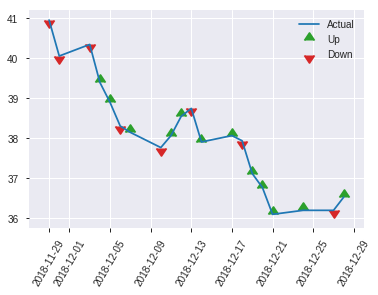


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1939663620295998
RMSE: 0.4404161237166503
LogLoss: 0.5730336795807994
Mean Per-Class Error: 0.26759400406504064
AUC: 0.7801702235772358
pr_auc: 0.7568753892086532
Gini: 0.5603404471544715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4490092396736145: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   57   0.4634   (57.0/123.0)
1      14   114  0.1094   (14.0/128.0)
Total  80   171  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449009     0.762542  170
max f2                       0.173221     0.84893   235
max f0point5                 0.527699     0.733533  134
max accuracy                 0.527699     0.733068  134
max precision                0.785793     0.92      24
max recall                   0.146693     1         243
max specificity              0.856204     0.99187   0
max absolute_mcc             0.507071     0.468022  142
max min_per_class_accuracy   0.545527     0.715447  126
max mean_per_class_accuracy  0.527699     0.732406  134

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.844629           1.30729   1.30729            0.666667         0.849474  0.666667                    0.849474            0.015625        0.015625                   30.7292   30.7292
    2        0.0239044                   0.83678            1.96094   1.63411            1                0.841133  0.833333                    0.845303            0.0234375       0.0390625                  96.0938   63.4115
    3        0.0318725                   0.828367           1.96094   1.71582            1                0.830657  0.875                       0.841642            0.015625        0.0546875                  96.0938   71.582
    4        0.0438247                   0.826181           1.30729   1.6044             0.666667         0.827541  0.818182                    0.837796            0.015625        0.0703125                  30.7292   60.4403
    5        0.0517928                   0.8187             1.96094   1.65925            1                0.820236  0.846154                    0.835095            0.015625        0.0859375                  96.0938   65.9255
    6        0.103586                    0.779383           1.8101    1.73468            0.923077         0.803817  0.884615                    0.819456            0.09375         0.179688                   81.0096   73.4675
    7        0.151394                    0.738152           1.4707    1.65132            0.75             0.763621  0.842105                    0.801824            0.0703125       0.25                       47.0703   65.1316
    8        0.203187                    0.705135           1.65925   1.65334            0.846154         0.722807  0.843137                    0.781682            0.0859375       0.335938                   65.9255   65.3339
    9        0.302789                    0.653161           1.255     1.52231            0.64             0.680106  0.776316                    0.748269            0.125           0.460938                   25.5      52.2307
    10       0.40239                     0.593657           1.17656   1.43673            0.6              0.621123  0.732673                    0.716797            0.117188        0.578125                   17.6562   43.6726
    11       0.501992                    0.545904           1.33344   1.41623            0.68             0.564797  0.722222                    0.686638            0.132812        0.710938                   33.3438   41.6233
    12       0.601594                    0.489912           1.01969   1.35058            0.52             0.516836  0.688742                    0.658525            0.101562        0.8125                     1.96875   35.0579
    13       0.701195                    0.414598           0.784375  1.27015            0.4              0.464638  0.647727                    0.630985            0.078125        0.890625                   -21.5625  27.0153
    14       0.800797                    0.324012           0.470625  1.17071            0.24             0.370164  0.597015                    0.598544            0.046875        0.9375                     -52.9375  17.0709
    15       0.900398                    0.227166           0.31375   1.07591            0.16             0.28853   0.548673                    0.564251            0.03125         0.96875                    -68.625   7.59126
    16       1                           0.107759           0.31375   1                  0.16             0.164632  0.50996                     0.524448          

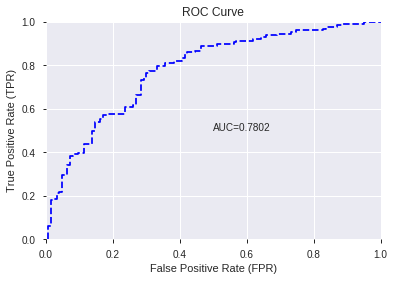

This function is available for GLM models only


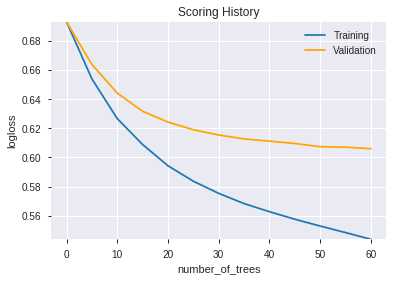

--2019-08-26 17:46:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

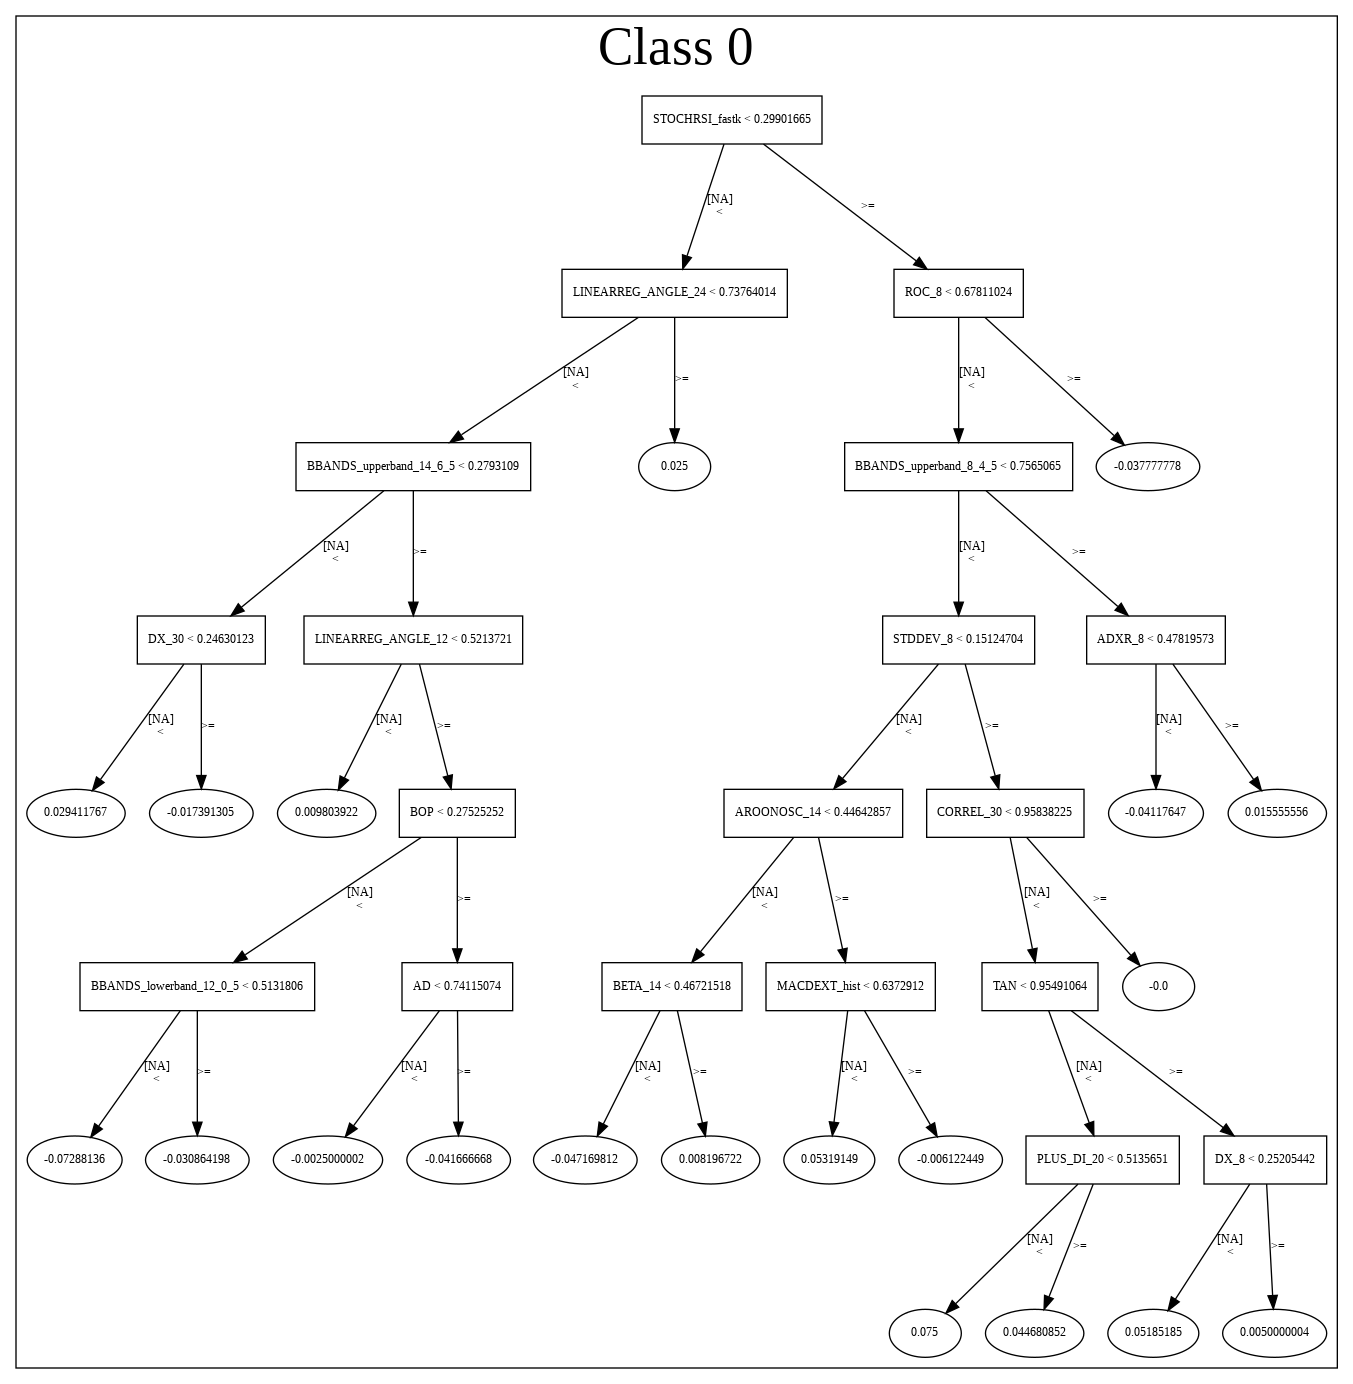

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_174611_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_174611_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'WILLR_8',
 'CCI_8',
 'MOM_8',
 'TRANGE',
 'ADOSC',
 'ULTOSC',
 'CCI_14',
 'STOCHF_fastk',
 'ROC_8',
 'STOCHRSI_fastk',
 'CMO_8',
 'CMO_20',
 'CDLCLOSINGMARUBOZU',
 'CCI_20',
 'WILLR_24',
 'CCI_12',
 'WILLR_30',
 'CMO_24',
 'WILLR_20',
 'CMO_12',
 'CMO_14',
 'WILLR_14',
 'WILLR_12',
 'CDLLONGLINE']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

345

['BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'MA_14_3',
 'MAVP_14_3',
 'BBANDS_middleband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'MAVP_14_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_middleband_14_5_4'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_174737_model_8  0.780805  0.583189              0.277788  0.444322  0.197422
1  DeepLearning_grid_1_AutoML_20190826_174737_model_2  0.771341  0.764528              0.293096  0.515034  0.265260
2  DeepLearning_grid_1_AutoML_20190826_174737_model_7  0.769690  0.653533              0.316438  0.462317  0.213737
3  DeepLearning_grid_1_AutoML_20190826_174737_model_6  0.767149  0.596328              0.315803  0.449807  0.202326
4  DeepLearning_grid_1_AutoML_20190826_174737_model_3  0.756733  0.658161              0.294842  0.452470  0.204729
5  DeepLearning_grid_1_AutoML_20190826_174737_model_9  0.752160  0.618634              0.328792  0.460389  0.211958
6  DeepLearning_grid_1_AutoML_20190826_174737_model_1  0.737551  1.085701              0.290619  0.489721  0.239827
7  DeepLearning_grid_1_AutoML_20190826_174737_model_5  0.734502  0.654194              0.332222  0.479789  0.230197
8  DeepLearning_grid_1_AutoML_20190826_174737_model_4  0.733295  1.096684              0.305926  0.546895  0.299095
9               DeepLearning_1_AutoML_20190826_174737  0.705030  0.687429              0.351912  0.487466  0.237623

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.013048
1                      TRANGE             0.924704           0.924704    0.012066
2          CDLCLOSINGMARUBOZU             0.777274           0.777274    0.010142
3                 CDLLONGLINE             0.592526           0.592526    0.007732
4                   CDLTAKURI             0.491043           0.491043    0.006407
..                        ...                  ...                ...         ...
339  BBANDS_middleband_20_2_2             0.161697           0.161697    0.002110
340  BBANDS_middleband_20_5_3             0.161539           0.161539    0.002108
341  BBANDS_middleband_24_5_2             0.160198           0.160198    0.002090
342          CDLCOUNTERATTACK             0.151302           0.151302    0.001974
343            CDL3LINESTRIKE             0.148578           0.148578    0.001939

[344 rows x 4 columns]

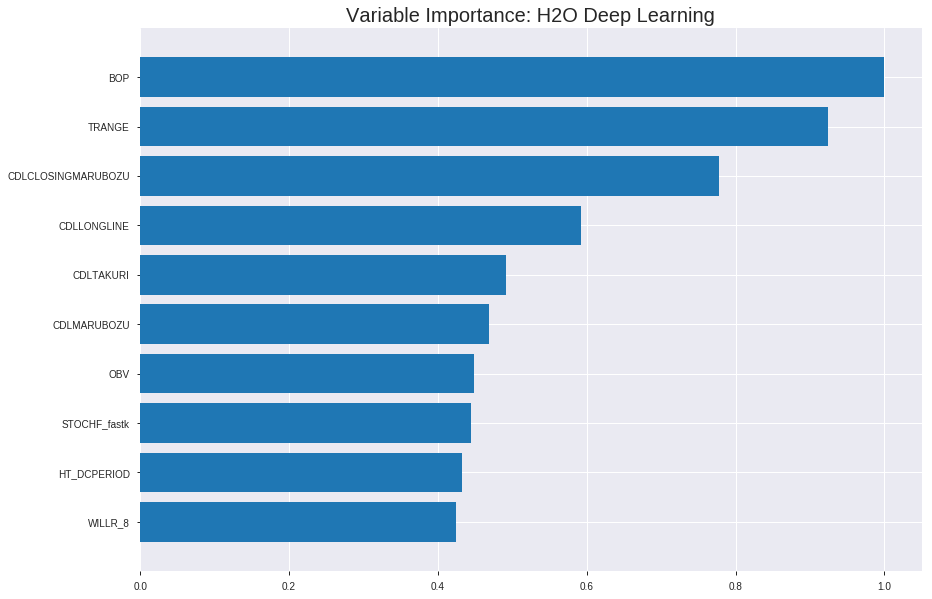

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_174737_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19203454523563543
RMSE: 0.4382174634078786
LogLoss: 0.5641103171493879
Mean Per-Class Error: 0.28295236978861404
AUC: 0.7873858737415179
pr_auc: 0.7875590325117906
Gini: 0.5747717474830358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39818285251175434: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      435  420   0.4912   (420.0/855.0)
1      102  796   0.1136   (102.0/898.0)
Total  537  1216  0.2978   (522.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398183     0.753075  253
max f2                       0.172575     0.85717   346
max f0point5                 0.490629     0.719078  203
max accuracy                 0.490629     0.718197  203
max precision                0.955307     1         0
max recall                   0.0421594    1         392
max specificity              0.955307     1         0
max absolute_mcc             0.490629     0.436349  203
max min_per_class_accuracy   0.503373     0.707127  194
max mean_per_class_accuracy  0.490629     0.717048  203

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.910605           1.95212   1.95212            1                0.930064  1                           0.930064            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.874448           1.95212   1.95212            1                0.889567  1                           0.909816            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.838157           1.72246   1.87845            0.882353         0.856047  0.962264                    0.892569            0.0167038       0.0567929                  72.2455   87.8451
    4        0.040502                    0.814685           1.95212   1.89713            1                0.824453  0.971831                    0.8753              0.0200445       0.0768374                  95.2116   89.7127
    5        0.0501997                   0.790076           1.72246   1.86338            0.882353         0.805231  0.954545                    0.861764            0.0167038       0.0935412                  72.2455   86.3383
    6        0.100399                    0.716779           1.7081    1.78574            0.875            0.750821  0.914773                    0.806293            0.0857461       0.179287                   70.8101   78.5742
    7        0.150029                    0.664772           1.59311   1.72202            0.816092         0.693127  0.882129                    0.768858            0.0790646       0.258352                   59.3106   72.2019
    8        0.200228                    0.623126           1.39754   1.64067            0.715909         0.642131  0.840456                    0.737086            0.0701559       0.328508                   39.7537   64.0667
    9        0.300057                    0.567314           1.4613    1.58099            0.748571         0.593468  0.809886                    0.689304            0.14588         0.474388                   46.1298   58.0991
    10       0.399886                    0.527828           1.08203   1.45643            0.554286         0.545878  0.746077                    0.653499            0.108018        0.582405                   8.20299   45.6429
    11       0.500285                    0.503137           1.19789   1.40454            0.613636         0.515032  0.719498                    0.625711            0.120267        0.702673                   19.7889   40.4544
    12       0.600114                    0.463513           1.0151    1.33976            0.52             0.487292  0.686312                    0.602685            0.101336        0.804009                   1.51002   33.976
    13       0.699943                    0.389477           0.858931  1.27118            0.44             0.429545  0.651182                    0.577991            0.0857461       0.889755                   -14.1069  27.1182
    14       0.799772                    0.295298           0.501973  1.17517            0.257143         0.344842  0.601997                    0.548889            0.0501114       0.939866                   -49.8027  17.5168
    15       0.899601                    0.178771           0.457353  1.09551            0.234286         0.23745   0.561192                    0.514328            0.045657        0.985523                   -54.2647  9.5512
    16       1                           0.0153047          0.14419   1                  0.0738636        0.10182   0.512265                    0.472913           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21734946411047018
RMSE: 0.46620753330514747
LogLoss: 0.6251047792599371
Mean Per-Class Error: 0.33330938697318
AUC: 0.7164511494252873
pr_auc: 0.7155250995191396
Gini: 0.43290229885057463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30347861412802063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   170  0.7083   (170.0/240.0)
1      18   243  0.069    (18.0/261.0)
Total  88   413  0.3752   (188.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303479     0.721068  321
max f2                       0.112103     0.853821  363
max f0point5                 0.545702     0.688299  158
max accuracy                 0.510963     0.664671  194
max precision                0.942559     1         0
max recall                   0.0416936    1         388
max specificity              0.942559     1         0
max absolute_mcc             0.545702     0.34242   158
max min_per_class_accuracy   0.50734      0.658333  202
max mean_per_class_accuracy  0.528488     0.666691  171

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 48.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.893018           1.59962   1.59962            0.833333         0.914545   0.833333                    0.914545            0.0191571       0.0191571                  59.9617    59.9617
    2        0.0219561                   0.853901           1.53563   1.57053            0.8              0.872337   0.818182                    0.895359            0.0153257       0.0344828                  53.5632    57.0533
    3        0.0319361                   0.840286           1.53563   1.55963            0.8              0.84515    0.8125                      0.879669            0.0153257       0.0498084                  53.5632    55.9626
    4        0.0419162                   0.809099           1.53563   1.55391            0.8              0.815932   0.809524                    0.864494            0.0153257       0.0651341                  53.5632    55.3914
    5        0.0518962                   0.79832            1.15172   1.47657            0.6              0.80374    0.769231                    0.85281             0.0114943       0.0766284                  15.1724    47.6569
    6        0.101796                    0.706282           1.6892    1.5808             0.88             0.739935   0.823529                    0.797479            0.0842912       0.16092                    68.9195    58.0798
    7        0.151697                    0.653745           1.30529   1.49017            0.68             0.669882   0.776316                    0.755507            0.0651341       0.226054                   30.5287    49.0169
    8        0.201597                    0.619647           1.53563   1.50142            0.8              0.63409    0.782178                    0.725453            0.0766284       0.302682                   53.5632    50.1423
    9        0.301397                    0.577069           1.2669    1.42376            0.66             0.594257   0.741722                    0.68201             0.126437        0.429119                   26.6897    42.3765
    10       0.401198                    0.532847           1.22851   1.37519            0.64             0.556325   0.716418                    0.650745            0.122605        0.551724                   22.8506    37.5193
    11       0.500998                    0.507972           0.998161  1.30009            0.52             0.518696   0.677291                    0.624441            0.0996169       0.651341                   -0.183908  30.0087
    12       0.600798                    0.490414           0.95977   1.24356            0.5              0.500023   0.647841                    0.603773            0.0957854       0.747126                   -4.02299   24.3556
    13       0.700599                    0.429875           0.767816  1.17579            0.4              0.462096   0.612536                    0.583591            0.0766284       0.823755                   -23.2184   17.5787
    14       0.800399                    0.330146           0.729425  1.12013            0.38             0.385455   0.583541                    0.558886            0.0727969       0.896552                   -27.0575   12.0131
    15       0.9002                      0.173363           0.729425  1.07682            0.38             0.258518   0.560976                    0.525586            0.0727969       0.969349                   -27.0575   7.68153
    16       1                           0.00451523         0.307126  1                  0.16             0.0745786  0.520958  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:58:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:58:56  2 min 44.838 sec  397 obs/sec       0.466058  1             817        0.629438         1.49219             -0.585722      0.615233        0.611585           1.73521          0.453508                         0.705533           2.05047               -0.994612        0.668263          0.672218             1.91954            0.357285
    2019-08-26 17:59:19  3 min  8.392 sec  563 obs/sec       7.36167   16            12905      0.460419         0.610929            0.151548       0.750681        0.753049           1.84366          0.341129                         0.468488           0.627493              0.120531         0.717417          0.722884             1.59962            0.369261
    2019-08-26 17:59:47  3 min 35.679 sec  623 obs/sec       17.1095   37            29993      0.438074         0.563464            0.231902       0.784726        0.785862           1.95212          0.292641                         0.465054           0.628876              0.133377         0.7286            0.725976             1.59962            0.355289
    2019-08-26 18:00:08  3 min 57.224 sec  648 obs/sec       24.9835   54            43796      0.438217         0.56411             0.231399       0.787386        0.787559           1.95212          0.297775                         0.466208           0.625105              0.129072         0.716451          0.715525             1.59962            0.37525
    2019-08-26 18:00:30  4 min 18.968 sec  667 obs/sec       33.2333   72            58258      0.430741         0.544298            0.257402       0.796391        0.802548           1.95212          0.328009                         0.468289           0.640043              0.121279         0.721392          0.710127             1.59962            0.317365
    2019-08-26 18:00:51  4 min 39.728 sec  680 obs/sec       41.1266   89            72095      0.429363         0.54273             0.262147       0.799134        0.799565           1.95212          0.284084                         0.478212           0.653724              0.0836441        0.683892          0.687172             1.27969            0.401198
    2019-08-26 18:01:13  5 min  1.966 sec  694 obs/sec       49.9167   108           87504      0.417794         0.517183            0.301373       0.821742        0.835232           1.95212          0.286937                         0.476773           0.651392              0.0891508        0.686167          0.675051             1.27969            0.40519
    2019-08-26 18:01:15  5 min  4.063 sec  693 obs/sec       49.9167   108           87504      0.438217         0.56411             0.231399       0.787386        0.787559           1.95212          0.297775                         0.466208           0.625105              0.129072         0.716451          0.715525             1.59962            0.37525

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.01304842508943599
TRANGE                    0.9247041940689087     0.9247041940689087   0.012065933406195436
CDLCLOSINGMARUBOZU        0.777273952960968      0.777273952960968    0.010142200949180984
CDLLONGLINE               0.5925263166427612     0.5925263166427612   0.0077315352562325
CDLTAKURI                 0.4910426139831543     0.4910426139831543   0.006407332764280023
---                       ---                    ---                  ---
BBANDS_middleband_20_2_2  0.16169732809066772    0.16169732809066772  0.0021098954727530317
BBANDS_middleband_20_5_3  0.16153889894485474    0.16153889894485474  0.0021078282219119076
BBANDS_middleband_24_5_2  0.1601976901292801     0.1601976901292801   0.0020903275591525904
CDLCOUNTERATTACK          0.15130160748958588    0.15130160748958588  0.0019742476912391086
CDL3LINESTRIKE            0.1485782265663147     0.1485782265663147   0.0019387118592718057


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7330677290836654)

('F1', 0.7628865979381443)

('auc', 0.7808053861788617)

('logloss', 0.5831889638586126)

('mean_per_class_error', 0.2690231199186992)

('rmse', 0.4443217380460555)

('mse', 0.1974218069002676)

deeplearning prediction progress: |███████████████████████████████████████| 100%


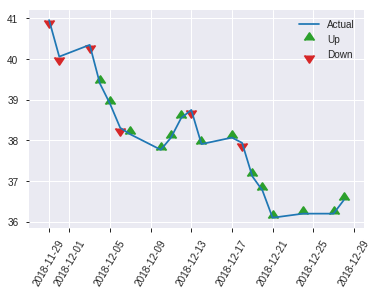


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1974218069002676
RMSE: 0.4443217380460555
LogLoss: 0.5831889638586126
Mean Per-Class Error: 0.2690231199186992
AUC: 0.7808053861788617
pr_auc: 0.7330679091578987
Gini: 0.5616107723577235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4966404371062287: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   52   0.4228   (52.0/123.0)
1      17   111  0.1328   (17.0/128.0)
Total  88   163  0.2749   (69.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49664      0.762887  162
max f2                       0.291511     0.867769  213
max f0point5                 0.579545     0.737705  89
max accuracy                 0.50337      0.733068  152
max precision                0.641749     0.830189  52
max recall                   0.0318418    1         247
max specificity              0.920693     0.99187   0
max absolute_mcc             0.50337      0.473366  152
max min_per_class_accuracy   0.541707     0.682927  126
max mean_per_class_accuracy  0.50337      0.730977  152

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.870408           0.653646  0.653646           0.333333         0.896398  0.333333                    0.896398            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.849767           1.96094   1.30729            1                0.862466  0.666667                    0.879432            0.0234375       0.03125                    96.0938   30.7292
    3        0.0318725                   0.828806           1.96094   1.4707             1                0.840379  0.75                        0.869669            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.814109           1.96094   1.6044             1                0.816729  0.818182                    0.855231            0.0234375       0.0703125                  96.0938   60.4403
    5        0.0517928                   0.773868           0.980469  1.50841            0.5              0.794949  0.769231                    0.845957            0.0078125       0.078125                   -1.95312  50.8413
    6        0.103586                    0.705242           1.50841   1.50841            0.769231         0.739963  0.769231                    0.79296             0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.668233           1.63411   1.54811            0.833333         0.683913  0.789474                    0.758524            0.078125        0.234375                   63.4115   54.8109
    8        0.203187                    0.64693            1.8101    1.61489            0.923077         0.655905  0.823529                    0.732366            0.09375         0.328125                   81.0096   61.489
    9        0.302789                    0.60461            1.41187   1.54811            0.72             0.622503  0.789474                    0.696227            0.140625        0.46875                    41.1875   54.8109
    10       0.40239                     0.566534           1.33344   1.49497            0.68             0.582687  0.762376                    0.668123            0.132812        0.601562                   33.3438   49.4972
    11       0.501992                    0.541906           0.784375  1.35398            0.4              0.556991  0.690476                    0.646073            0.078125        0.679688                   -21.5625  35.3981
    12       0.601594                    0.504281           1.41187   1.36357            0.72             0.522845  0.695364                    0.625671            0.140625        0.820312                   41.1875   36.3566
    13       0.701195                    0.476678           0.6275    1.25901            0.32             0.493121  0.642045                    0.606843            0.0625          0.882812                   -37.25    25.9011
    14       0.800797                    0.410827           0.705937  1.19022            0.36             0.446722  0.606965                    0.586927            0.0703125       0.953125                   -29.4062  19.0221
    15       0.900398                    0.194872           0.31375   1.09327            0.16             0.287016  0.557522                    0.553751            0.03125         0.984375                   -68.625   9.3266
    16       1                           0.017468           0.156875  1                  0.08             0.104671  0.50996                     0.509022          

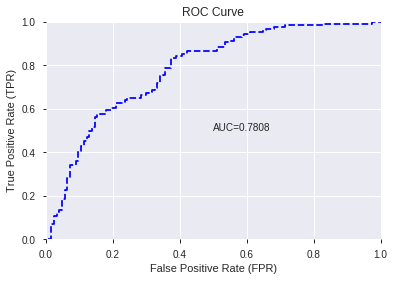

This function is available for GLM models only


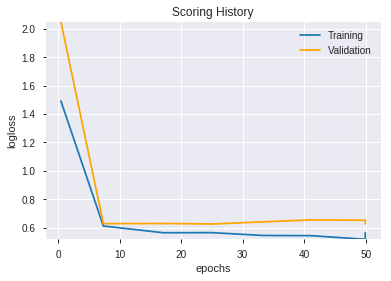

--2019-08-26 18:05:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


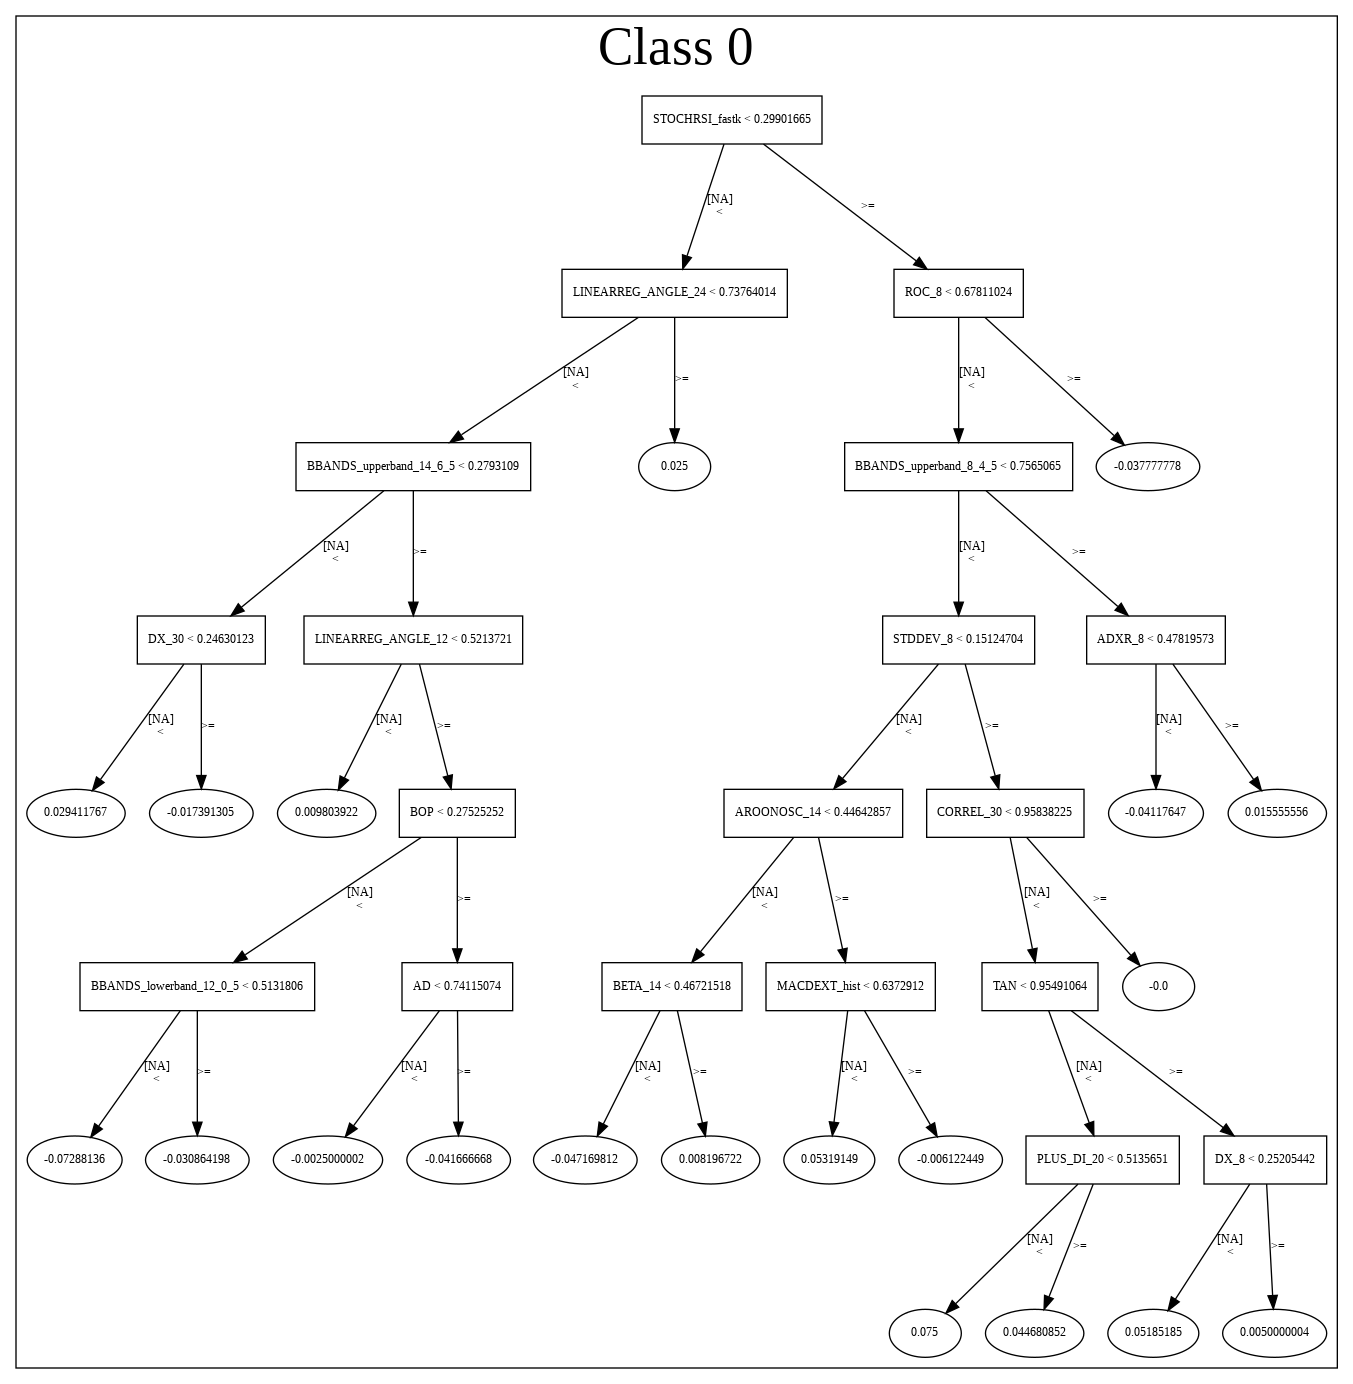

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_174737_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_174737_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'OBV',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'WILLR_8',
 'CDLENGULFING',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'ADOSC',
 'WILLR_14',
 'BETA_8',
 'STOCHRSI_fastk',
 'STOCHF_fastd',
 'aroonup_14',
 'CORREL_8',
 'DX_24',
 'STDDEV_8',
 'DX_12',
 'aroondown_24',
 'DX_14',
 'CDLSPINNINGTOP',
 'CDL3INSIDE',
 'WILLR_12',
 'CDLHIGHWAVE',
 'STOCH_slowk',
 'CDLGRAVESTONEDOJI',
 'MFI_12',
 'AROONOSC_8',
 'ADX_24',
 'ADX_14',
 'HT_PHASOR_inphase',
 'STOCH_slowd',
 'CDLHARAMI',
 'MFI_14',
 'aroonup_20',
 'CDLHANGINGMAN',
 'WILLR_20',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'aroondown_14',
 'AROONOSC_12',
 'ROCR100_20',
 'aroondown_30',
 'BETA_12',
 'CDLRICKSHAWMAN',
 'STDDEV_12',
 'CDLEVENINGDOJISTAR',
 'AROONOSC_14',
 'ROCP_30',
 'ADXR_14',
 'CORREL_12',
 'MOM_20',
 'ROCP_20',
 'aroondown_20',
 'ADX_20',
 'aroonup_24',
 'PLUS_DM_8',
 'aroondown_8',
 'CCI_12',
 'MFI_8',
 'PLUS_DI_20'

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_180507_model_1  0.778265  0.584249              0.272929  0.443833  0.196988

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.279540           1.000000    0.053855
1                      TRANGE             0.190029           0.679793    0.036610
2          CDLCLOSINGMARUBOZU             0.161436           0.577505    0.031102
3                 CDLLONGLINE             0.122691           0.438902    0.023637
4                   CDLTAKURI             0.104045           0.372201    0.020045
..                        ...                  ...                ...         ...
339  BBANDS_middleband_14_3_5             0.000058           0.000206    0.000011
340   BBANDS_upperband_20_2_4             0.000055           0.000195    0.000011
341   BBANDS_upperband_30_6_2             0.000037           0.000134    0.000007
342   BBANDS_lowerband_14_7_2             0.000034           0.000121    0.000007
343   BBANDS_lowerband_30_0_3             0.000024           0.000086    0.000005

[344 rows x 4 columns]

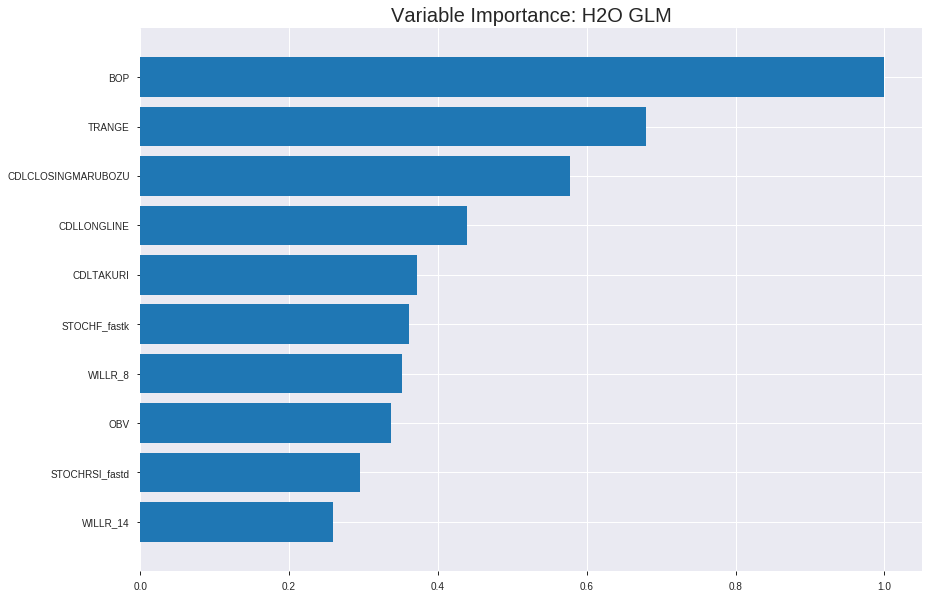

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_180507_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19553286839114029
RMSE: 0.44219098632959525
LogLoss: 0.5744673177767391
Null degrees of freedom: 1752
Residual degrees of freedom: 1408
Null deviance: 2429.1191459812417
Residual deviance: 2014.0824161252472
AIC: 2704.082416125247
AUC: 0.7750589353859779
pr_auc: 0.7744739072364409
Gini: 0.5501178707719558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4051513531525589: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      400  455   0.5322   (455.0/855.0)
1      104  794   0.1158   (104.0/898.0)
Total  504  1249  0.3189   (559.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405151     0.739637  260
max f2                       0.254299     0.849806  332
max f0point5                 0.521785     0.716247  196
max accuracy                 0.491796     0.712493  213
max precision                0.925233     1         0
max recall                   0.133619     1         379
max specificity              0.925233     1         0
max absolute_mcc             0.491796     0.424874  213
max min_per_class_accuracy   0.518346     0.703786  198
max mean_per_class_accuracy  0.491796     0.71134   213

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.874936           1.84366   1.84366            0.944444         0.892461  0.944444                    0.892461            0.018931        0.018931                   84.3665   84.3665
    2        0.0205362                   0.859617           1.95212   1.89789            1                0.86634   0.972222                    0.879401            0.0200445       0.0389755                  95.2116   89.789
    3        0.0302339                   0.8442             1.83729   1.87845            0.941176         0.850975  0.962264                    0.870283            0.0178174       0.0567929                  83.7285   87.8451
    4        0.040502                    0.82492            1.84366   1.86963            0.944444         0.83371   0.957746                    0.861011            0.018931        0.0757238                  84.3665   86.9632
    5        0.0501997                   0.814263           1.72246   1.8412             0.882353         0.81888   0.943182                    0.852872            0.0167038       0.0924276                  72.2455   84.12
    6        0.100399                    0.75281            1.68592   1.76356            0.863636         0.781743  0.903409                    0.817308            0.0846325       0.17706                    68.5918   76.3559
    7        0.150029                    0.716236           1.45848   1.66264            0.747126         0.733665  0.851711                    0.789639            0.0723831       0.249443                   45.8477   66.2639
    8        0.200228                    0.682587           1.46409   1.61286            0.75             0.699398  0.826211                    0.767014            0.0734967       0.32294                    46.4087   61.2859
    9        0.300057                    0.631458           1.39437   1.54017            0.714286         0.656628  0.788973                    0.730289            0.139198        0.462138                   39.4368   54.0167
    10       0.399886                    0.57939            1.24935   1.46757            0.64             0.604349  0.751783                    0.698849            0.124722        0.58686                    24.9354   46.7568
    11       0.500285                    0.518949           1.15352   1.40454            0.590909         0.548877  0.719498                    0.668752            0.115813        0.702673                   15.3523   40.4544
    12       0.600114                    0.469129           0.981635  1.33419            0.502857         0.493075  0.68346                     0.639528            0.0979955       0.800668                   -1.83646  33.4193
    13       0.699943                    0.412739           0.736227  1.24891            0.377143         0.442223  0.639772                    0.611388            0.0734967       0.874165                   -26.3773  24.8909
    14       0.799772                    0.335263           0.635832  1.17238            0.325714         0.373645  0.600571                    0.581712            0.0634744       0.937639                   -36.4168  17.2383
    15       0.899601                    0.247883           0.390423  1.08561            0.2              0.295243  0.556119                    0.549923            0.0389755       0.976615                   -60.9577  8.56091
    16       1                           0.0424529          0.232923  1                  0.119318         0.17484   0.512265                    0.512265            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21134672067482319
RMSE: 0.45972461395363984
LogLoss: 0.6097009204395701
Null degrees of freedom: 500
Residual degrees of freedom: 156
Null deviance: 693.804571947685
Residual deviance: 610.9203222804492
AIC: 1300.9203222804492
AUC: 0.7256226053639846
pr_auc: 0.7261830608960457
Gini: 0.4512452107279692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2991810053292617: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   189  0.7875   (189.0/240.0)
1      7    254  0.0268   (7.0/261.0)
Total  58   443  0.3912   (196.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299181     0.721591  342
max f2                       0.282456     0.857334  347
max f0point5                 0.514938     0.693069  202
max accuracy                 0.514938     0.680639  202
max precision                0.895451     1         0
max recall                   0.150008     1         385
max specificity              0.895451     1         0
max absolute_mcc             0.514938     0.35995   202
max min_per_class_accuracy   0.520225     0.670498  196
max mean_per_class_accuracy  0.514938     0.679909  202

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.86272            1.91954   1.91954            1                0.879196  1                           0.879196            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.849757           1.53563   1.74504            0.8              0.856362  0.909091                    0.868817            0.0153257       0.0383142                  53.5632   74.5037
    3        0.0319361                   0.842388           1.53563   1.6796             0.8              0.845437  0.875                       0.861511            0.0153257       0.0536398                  53.5632   67.9598
    4        0.0419162                   0.812147           1.15172   1.55391            0.6              0.822176  0.809524                    0.852145            0.0114943       0.0651341                  15.1724   55.3914
    5        0.0518962                   0.800973           1.15172   1.47657            0.6              0.806289  0.769231                    0.843327            0.0114943       0.0766284                  15.1724   47.6569
    6        0.101796                    0.732319           1.76598   1.61844            0.92             0.760029  0.843137                    0.802494            0.0881226       0.164751                   76.5977   61.8436
    7        0.151697                    0.703249           1.45885   1.56594            0.76             0.717984  0.815789                    0.774695            0.0727969       0.237548                   45.8851   56.5941
    8        0.201597                    0.674383           1.38207   1.52043            0.72             0.689448  0.792079                    0.753594            0.0689655       0.306513                   38.2069   52.0428
    9        0.301397                    0.617731           1.30529   1.44919            0.68             0.647703  0.754967                    0.718531            0.130268        0.436782                   30.5287   44.9189
    10       0.401198                    0.571102           1.11333   1.36564            0.58             0.59329   0.711443                    0.687376            0.111111        0.547893                   11.3333   36.5643
    11       0.500998                    0.522245           1.19011   1.33068            0.62             0.546247  0.693227                    0.659263            0.118774        0.666667                   19.0115   33.0677
    12       0.600798                    0.478676           0.729425  1.2308             0.38             0.500559  0.641196                    0.6329              0.0727969       0.739464                   -27.0575  23.0802
    13       0.700599                    0.411727           1.03655   1.20313            0.54             0.444265  0.626781                    0.606029            0.103448        0.842912                   3.65517   20.3131
    14       0.800399                    0.354247           0.49908   1.11534            0.26             0.385367  0.581047                    0.578515            0.0498084       0.89272                    -50.092   11.5344
    15       0.9002                      0.275388           0.882989  1.08958            0.46             0.317307  0.567627                    0.549556            0.0881226       0.980843                   -11.7011  8.95838
    16       1                           0.0570428          0.191954  1                  0.1              0.181508  0.520958                    0.512825          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 18:05:08  0.000 sec   2            .2E2      344           1.362694472443611   1.3707121558426796
     2019-08-26 18:05:08  0.250 sec   4            .15E2     344           1.3564209786568548  1.3661041651083459
     2019-08-26 18:05:09  0.526 sec   6            .11E2     345           1.348706635518037   1.3601488623729494
     2019-08-26 18:05:09  0.778 sec   8            .77E1     345           1.3393220311159044  1.3526513868102206
     2019-08-26 18:05:09  1.029 sec   10           .56E1     345           1.3281203891621696  1.3434854911370648
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 18:05:12  4.405 sec   36           .9E-1     345           1.139043664212672   1.2196599428992276
     2019-08-26 18:05:13  4.669 sec   38           .66E-1    345           1.130270811105932   1.2222891751344411
     2019-08-26 18:05:13  4.919 sec   40           .48E-1    345           1.1225336867931697  1.2271704825697995
     2019-08-26 18:05:13  5.182 sec   42           .35E-1    345           1.1157229493010477  1.2341835934818814
     2019-08-26 18:05:13  5.436 sec   44           .25E-1    345           1.1097223307968564  1.2430782780932854


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7290836653386454)

('F1', 0.7571428571428572)

('auc', 0.7782647357723578)

('logloss', 0.5842491273188376)

('mean_per_class_error', 0.2729293699186992)

('rmse', 0.44383341114651065)

('mse', 0.19698809684994759)

glm prediction progress: |████████████████████████████████████████████████| 100%


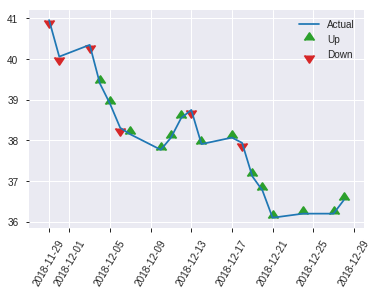


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19698809684994759
RMSE: 0.44383341114651065
LogLoss: 0.5842491273188376
Null degrees of freedom: 250
Residual degrees of freedom: -94
Null deviance: 347.8656113866541
Residual deviance: 293.2930619140565
AIC: 983.2930619140566
AUC: 0.7782647357723578
pr_auc: 0.7310544370216774
Gini: 0.5565294715447155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4969731105601588: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   46   0.374    (46.0/123.0)
1      22   106  0.1719   (22.0/128.0)
Total  99   152  0.2709   (68.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496973     0.757143  151
max f2                       0.301122     0.869863  217
max f0point5                 0.642598     0.723684  81
max accuracy                 0.496973     0.729084  151
max precision                0.692273     0.843137  50
max recall                   0.13432      1         247
max specificity              0.952985     0.99187   0
max absolute_mcc             0.496973     0.464525  151
max min_per_class_accuracy   0.561154     0.6875    125
max mean_per_class_accuracy  0.496973     0.727071  151

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892355           0.653646   0.653646           0.333333         0.921216  0.333333                    0.921216            0.0078125       0.0078125                  -34.6354  -34.6354
    2        0.0239044                   0.880246           1.96094    1.30729            1                0.88196   0.666667                    0.901588            0.0234375       0.03125                    96.0938   30.7292
    3        0.0318725                   0.856867           1.96094    1.4707             1                0.874162  0.75                        0.894732            0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.842367           1.30729    1.42614            0.666667         0.843238  0.727273                    0.880688            0.015625        0.0625                     30.7292   42.6136
    5        0.0517928                   0.828707           1.96094    1.50841            1                0.831591  0.769231                    0.873135            0.015625        0.078125                   96.0938   50.8413
    6        0.103586                    0.752799           1.50841    1.50841            0.769231         0.789219  0.769231                    0.831177            0.078125        0.15625                    50.8413   50.8413
    7        0.151394                    0.721372           1.79753    1.59971            0.916667         0.738432  0.815789                    0.801889            0.0859375       0.242188                   79.7526   59.9712
    8        0.203187                    0.692273           1.8101     1.65334            0.923077         0.708119  0.843137                    0.777987            0.09375         0.335938                   81.0096   65.3339
    9        0.302789                    0.652746           1.41187    1.57391            0.72             0.675177  0.802632                    0.744168            0.140625        0.476562                   41.1875   57.391
    10       0.40239                     0.601278           1.17656    1.47556            0.6              0.628207  0.752475                    0.715465            0.117188        0.59375                    17.6562   47.5557
    11       0.501992                    0.561154           0.94125    1.36954            0.48             0.582811  0.698413                    0.689145            0.09375         0.6875                     -5.875    36.9544
    12       0.601594                    0.497067           1.33344    1.36357            0.68             0.525961  0.695364                    0.662127            0.132812        0.820312                   33.3438   36.3566
    13       0.701195                    0.433184           0.549063   1.24787            0.28             0.470087  0.636364                    0.634849            0.0546875       0.875                      -45.0938  24.7869
    14       0.800797                    0.360044           0.862812   1.19998            0.44             0.404261  0.61194                     0.606169            0.0859375       0.960938                   -13.7188  19.9977
    15       0.900398                    0.263186           0.31375    1.10194            0.16             0.314034  0.561947                    0.573853            0.03125         0.992188                   -68.625   10.1943
    16       1                           0.0831416          0.0784375  1                  0.04             0.192415  0.50996                    

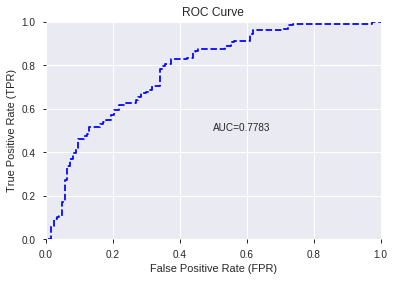

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


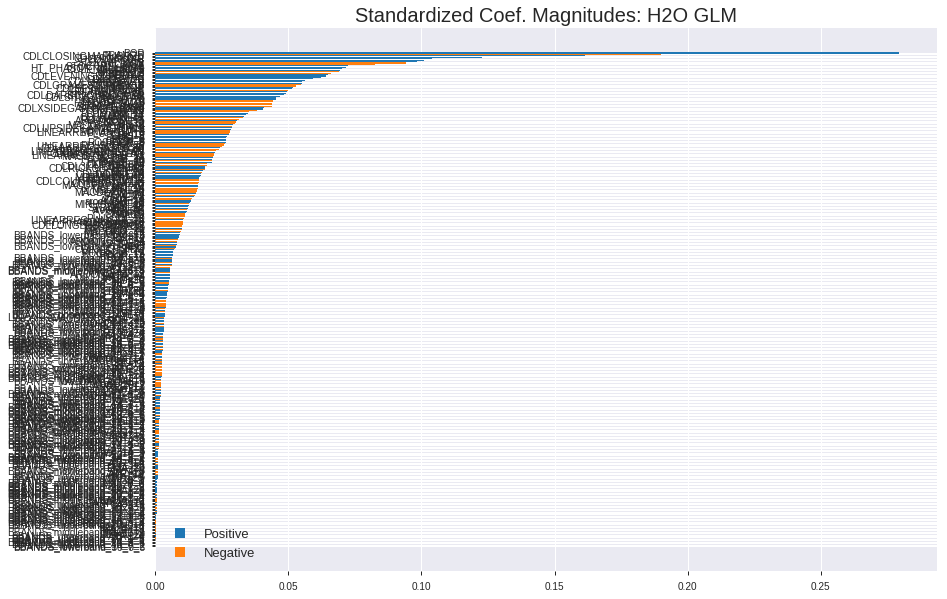

'log_likelihood'
--2019-08-26 18:05:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


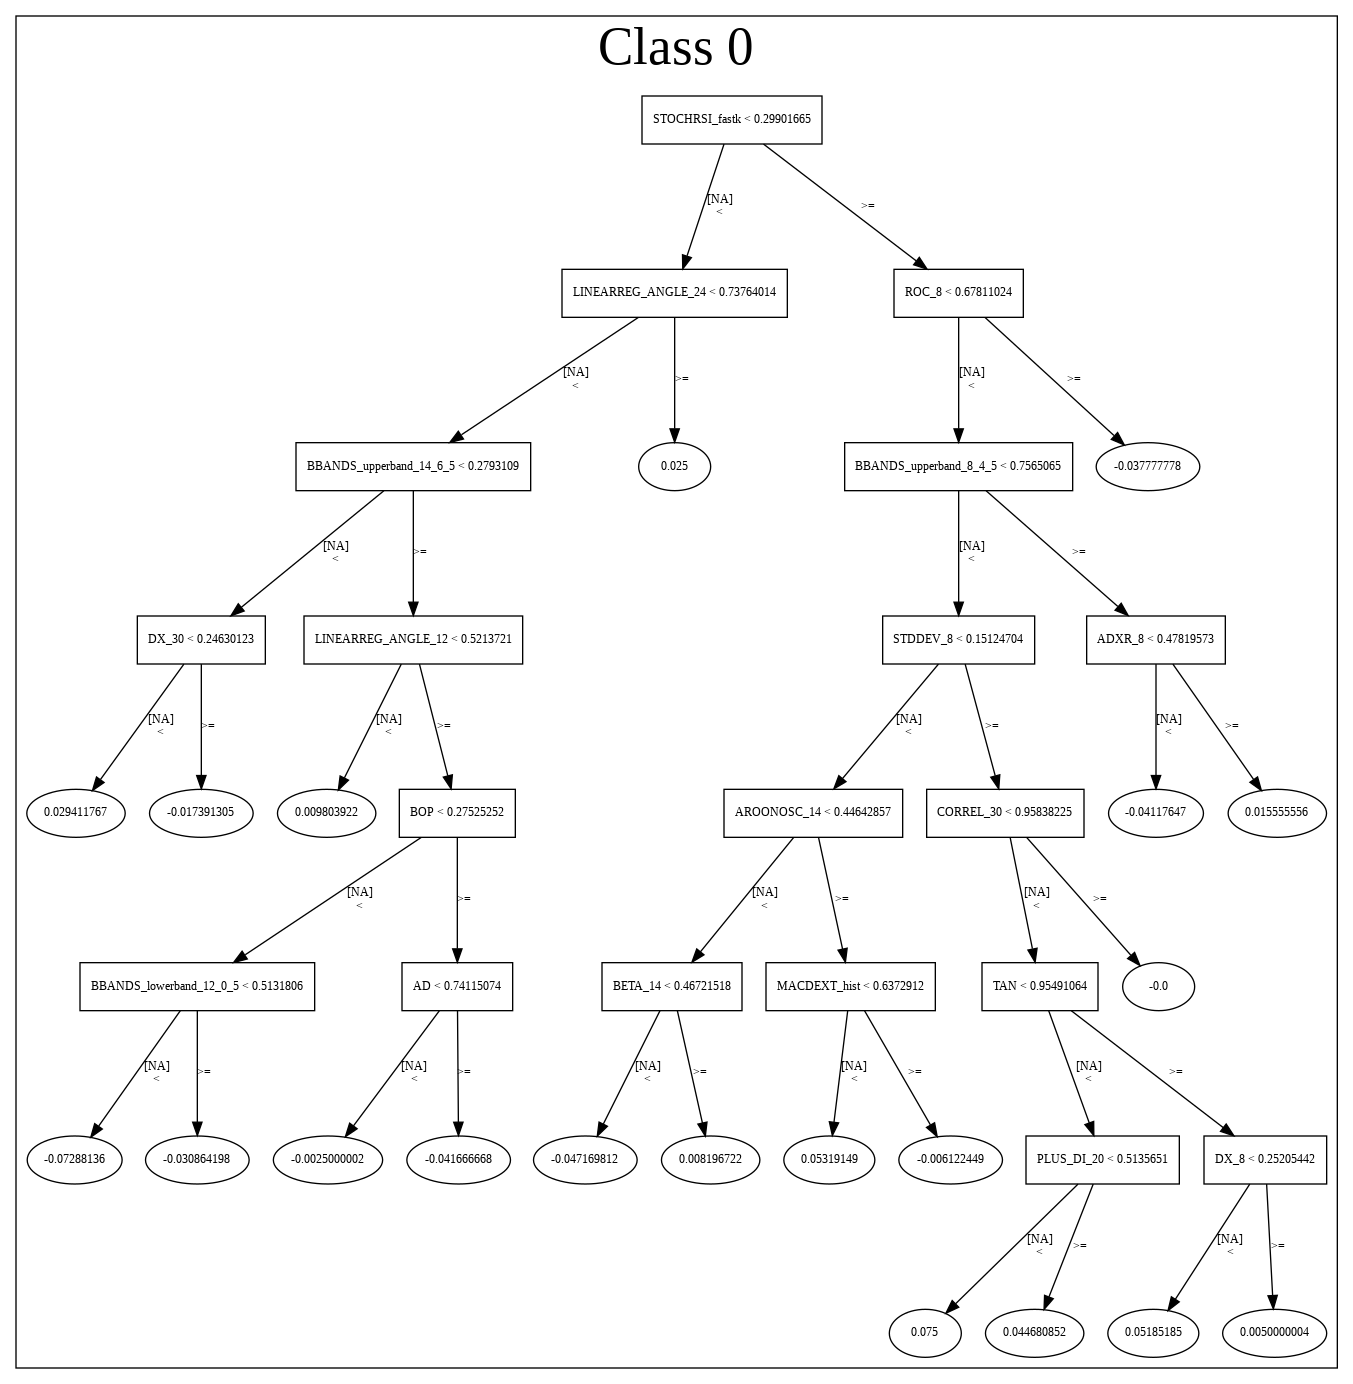

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_180507_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_180507_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLTAKURI',
 'STOCHF_fastk',
 'WILLR_8',
 'OBV',
 'STOCHRSI_fastd',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'CDLENGULFING',
 'WILLR_12',
 'aroonup_8',
 'BETA_8',
 'ADOSC',
 'CDLEVENINGDOJISTAR',
 'WILLR_20',
 'CDL3INSIDE',
 'CDLMARUBOZU',
 'STDDEV_8',
 'CORREL_8',
 'CDLGRAVESTONEDOJI',
 'MFI_12',
 'CDLSPINNINGTOP',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'WILLR_30',
 'STOCHRSI_fastk',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'ROCP_20',
 'ROCR100_20',
 'PLUS_DM_8',
 'HT_DCPERIOD',
 'STOCH_slowk',
 'STOCHF_fastd',
 'STOCH_slowd',
 'CDLXSIDEGAP3METHODS',
 'CDLHARAMI',
 'MFI_14',
 'PLUS_DM_12',
 'WILLR_24',
 'ADX_14',
 'CDLHAMMER',
 'PLUS_DM_14',
 'AROONOSC_8',
 'MOM_20',
 'PLUS_DI_12',
 'MACDFIX_hist_8',
 'VAR_8',
 'MACD_hist',
 'CDLUPSIDEGAP2CROWS',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_14',
 'CCI_12',
 'CMO_8',
 'RSI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR100_8',
 'ROCR_8',
 'PLUS_DM_20',
 'LINEARREG_SLOPE_8',
 'CCI_30',
 'CDLLADDE

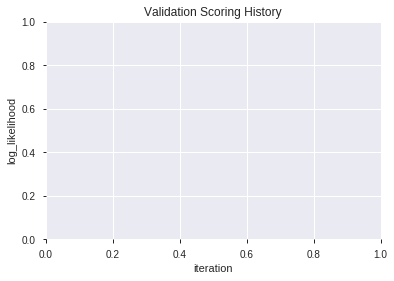

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_180528_model_2  0.769436  0.577038              0.281853  0.442409  0.195726
1               XGBoost_3_AutoML_20190826_180528  0.767975  0.579657              0.261369  0.442830  0.196099
2               XGBoost_2_AutoML_20190826_180528  0.767340  0.580217              0.311738  0.443297  0.196512
3  XGBoost_grid_1_AutoML_20190826_180528_model_4  0.761623  0.583489              0.290460  0.445544  0.198510
4  XGBoost_grid_1_AutoML_20190826_180528_model_6  0.760607  0.580912              0.286077  0.444524  0.197602
5  XGBoost_grid_1_AutoML_20190826_180528_model_3  0.757622  0.583549              0.306561  0.446073  0.198981
6  XGBoost_grid_1_AutoML_20190826_180528_model_1  0.751778  0.591838              0.294842  0.449581  0.202123
7               XGBoost_1_AutoML_20190826_180528  0.749682  0.590708              0.294842  0.448703  0.201334
8  XGBoost_grid_1_AutoML_20190826_180528_model_7  0.745109  0.595236              0.331904  0.452036  0.204337
9  XGBoost_grid_1_AutoML_20190826_180528_model_5  0.739774  0.602752              0.340034  0.455323  0.207319

variable  relative_importance  scaled_importance  percentage
0                        BOP          2458.396240           1.000000    0.270805
1                     TRANGE           490.436310           0.199494    0.054024
2                    WILLR_8           287.499786           0.116946    0.031670
3                  aroonup_8           176.898178           0.071957    0.019486
4                     MFI_24           149.943298           0.060992    0.016517
..                       ...                  ...                ...         ...
227  BBANDS_lowerband_14_5_3             0.296392           0.000121    0.000033
228  BBANDS_lowerband_14_6_3             0.250505           0.000102    0.000028
229  BBANDS_upperband_14_3_5             0.195596           0.000080    0.000022
230  BBANDS_lowerband_20_1_4             0.193057           0.000079    0.000021
231  BBANDS_upperband_14_6_5             0.052149           0.000021    0.000006

[232 rows x 4 columns]

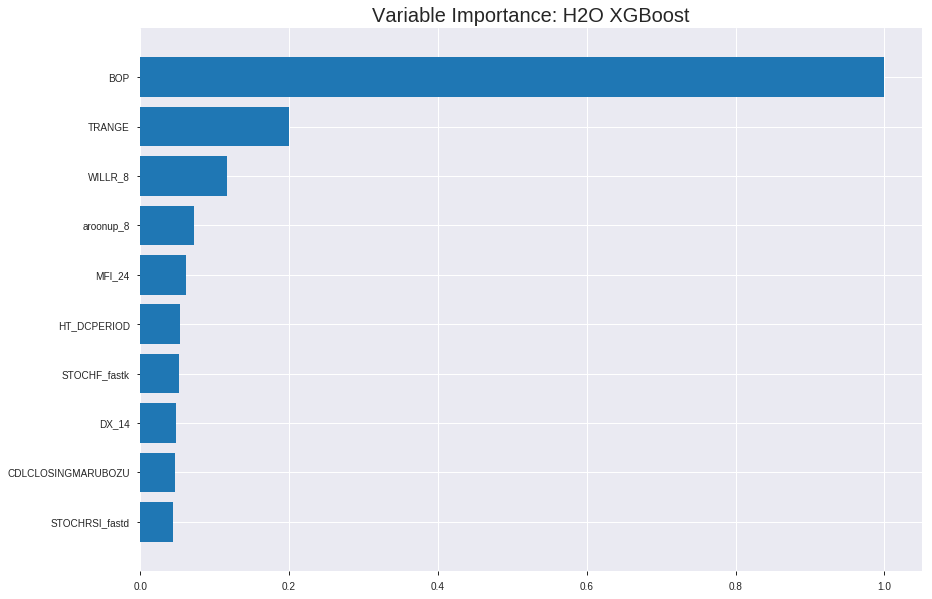

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_180528_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14633272741369768
RMSE: 0.38253460943252926
LogLoss: 0.46475964962134897
Mean Per-Class Error: 0.18070370804516855
AUC: 0.9087289493220803
pr_auc: 0.9179181538014649
Gini: 0.8174578986441605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4963775740729438: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      641  214  0.2503   (214.0/855.0)
1      113  785  0.1258   (113.0/898.0)
Total  754  999  0.1865   (327.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496378     0.827623  215
max f2                       0.371222     0.89212   273
max f0point5                 0.589301     0.855091  160
max accuracy                 0.536218     0.819167  191
max precision                0.901522     1         0
max recall                   0.1832       1         360
max specificity              0.901522     1         0
max absolute_mcc             0.589301     0.646705  160
max min_per_class_accuracy   0.534162     0.816258  192
max mean_per_class_accuracy  0.536218     0.819296  191

Gains/Lift Table: Avg response rate: 51.23 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.874068           1.95212    1.95212            1                0.885344  1                           0.885344            0.0200445       0.0200445                  95.2116   95.2116
    2        0.0205362                   0.863179           1.95212    1.95212            1                0.868358  1                           0.876851            0.0200445       0.0400891                  95.2116   95.2116
    3        0.0302339                   0.846268           1.95212    1.95212            1                0.856467  1                           0.870313            0.018931        0.05902                    95.2116   95.2116
    4        0.040502                    0.836844           1.95212    1.95212            1                0.840568  1                           0.862772            0.0200445       0.0790646                  95.2116   95.2116
    5        0.0501997                   0.827106           1.95212    1.95212            1                0.832068  1                           0.85684             0.018931        0.0979955                  95.2116   95.2116
    6        0.100399                    0.781635           1.95212    1.95212            1                0.80248   1                           0.82966             0.0979955       0.195991                   95.2116   95.2116
    7        0.150029                    0.742238           1.92968    1.94469            0.988506         0.759451  0.996198                    0.806435            0.0957684       0.291759                   92.9678   94.4693
    8        0.200228                    0.715678           1.8412     1.91875            0.943182         0.729159  0.982906                    0.787061            0.0924276       0.384187                   84.12     91.8746
    9        0.300057                    0.658759           1.75133    1.86305            0.897143         0.687821  0.954373                    0.754044            0.174833        0.55902                    75.1327   86.3046
    10       0.399886                    0.601123           1.45014    1.75997            0.742857         0.631843  0.901569                    0.723537            0.144766        0.703786                   45.0143   75.9967
    11       0.500285                    0.536621           1.0537     1.61823            0.539773         0.567732  0.828962                    0.69227             0.105791        0.809577                   5.36989   61.8231
    12       0.600114                    0.472153           0.847776   1.49007            0.434286         0.506105  0.763308                    0.661301            0.0846325       0.894209                   -15.2224  49.0066
    13       0.699943                    0.384169           0.602367   1.36346            0.308571         0.427627  0.698452                    0.627973            0.0601336       0.954343                   -39.7633  36.3458
    14       0.799772                    0.290302           0.345803   1.23643            0.177143         0.340352  0.633381                    0.592072            0.0345212       0.988864                   -65.4197  23.6433
    15       0.899601                    0.197819           0.100395   1.11037            0.0514286        0.240205  0.568802                    0.553025            0.0100223       0.998886                   -89.9605  11.0366
    16       1                           0.0951712          0.0110916  1                  0.00568182       0.155104  0.512265                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2084768160751431
RMSE: 0.45659261500285253
LogLoss: 0.6042380333467691
Mean Per-Class Error: 0.301676245210728
AUC: 0.737316411238825
pr_auc: 0.7521493581913152
Gini: 0.47463282247764993
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32676348090171814: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   169  0.7042   (169.0/240.0)
1      19   242  0.0728   (19.0/261.0)
Total  90   411  0.3752   (188.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326763     0.720238  321
max f2                       0.194823     0.850295  379
max f0point5                 0.55417      0.713135  189
max accuracy                 0.534616     0.698603  200
max precision                0.874754     1         0
max recall                   0.15334      1         391
max specificity              0.874754     1         0
max absolute_mcc             0.534616     0.396477  200
max min_per_class_accuracy   0.54163      0.691667  198
max mean_per_class_accuracy  0.534616     0.698324  200

Gains/Lift Table: Avg response rate: 52.10 %, avg score: 52.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.832789           1.91954   1.91954            1                0.850516  1                           0.850516            0.0229885       0.0229885                  91.954    91.954
    2        0.0219561                   0.810814           1.91954   1.91954            1                0.817896  1                           0.835689            0.0191571       0.0421456                  91.954    91.954
    3        0.0319361                   0.79774            1.91954   1.91954            1                0.80116   1                           0.824899            0.0191571       0.0613027                  91.954    91.954
    4        0.0419162                   0.787943           1.53563   1.82813            0.8              0.790445  0.952381                    0.816696            0.0153257       0.0766284                  53.5632   82.8134
    5        0.0518962                   0.774745           1.91954   1.84571            1                0.778579  0.961538                    0.809365            0.0191571       0.0957854                  91.954    84.5712
    6        0.101796                    0.736865           1.61241   1.73135            0.84             0.752781  0.901961                    0.781628            0.0804598       0.176245                   61.2414   73.135
    7        0.151697                    0.715813           1.15172   1.54068            0.6              0.726611  0.802632                    0.76353             0.0574713       0.233716                   15.1724   54.0684
    8        0.201597                    0.698387           1.45885   1.52043            0.76             0.706872  0.792079                    0.749506            0.0727969       0.306513                   45.8851   52.0428
    9        0.301397                    0.653541           1.45885   1.50004            0.76             0.67244   0.781457                    0.723987            0.145594        0.452107                   45.8851   50.0038
    10       0.401198                    0.602778           1.11333   1.40384            0.58             0.627048  0.731343                    0.699873            0.111111        0.563218                   11.3333   40.3843
    11       0.500998                    0.548811           1.22851   1.36892            0.64             0.576859  0.713147                    0.675368            0.122605        0.685824                   22.8506   36.8915
    12       0.600798                    0.489981           0.729425  1.26269            0.38             0.517822  0.657807                    0.649198            0.0727969       0.758621                   -27.0575  26.2688
    13       0.700599                    0.421122           0.614253  1.17032            0.32             0.45147   0.609687                    0.621031            0.0613027       0.819923                   -38.5747  17.0318
    14       0.800399                    0.344037           0.882989  1.13449            0.46             0.382985  0.591022                    0.59135             0.0881226       0.908046                   -11.7011  13.4491
    15       0.9002                      0.241242           0.575862  1.07256            0.3              0.294275  0.558758                    0.558415            0.0574713       0.965517                   -42.4138  7.25591
    16       1                           0.110503           0.345517  1                  0.18             0.191972  0.520958                    0.521844            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:05:37  1.386 sec   0                  0.5              0.693147            0.5             0                  1                0.487735                         0.5                0.693147              0.5               0                    1                  0.479042
    2019-08-26 18:05:37  1.611 sec   5                  0.479251         0.652366            0.815467        0.747694           1.79961          0.261837                         0.488666           0.670669              0.699777          0.670515             1.3711             0.365269
    2019-08-26 18:05:37  1.714 sec   10                 0.462857         0.620795            0.835648        0.823178           1.95212          0.272105                         0.480054           0.6537                0.722557          0.727122             1.91954            0.363273
    2019-08-26 18:05:37  1.822 sec   15                 0.44893          0.594056            0.840531        0.826585           1.95212          0.257273                         0.472825           0.639309              0.724162          0.728149             1.91954            0.361277
    2019-08-26 18:05:37  1.926 sec   20                 0.437631         0.572199            0.848207        0.840048           1.95212          0.257844                         0.468696           0.630859              0.721232          0.723917             1.91954            0.341317
    2019-08-26 18:05:38  2.029 sec   25                 0.428788         0.554997            0.857248        0.860654           1.95212          0.243012                         0.465773           0.624715              0.725567          0.732452             1.91954            0.341317
    2019-08-26 18:05:38  2.129 sec   30                 0.42161          0.540802            0.863877        0.870625           1.95212          0.241871                         0.46376            0.620433              0.727658          0.73696              1.91954            0.345309
    2019-08-26 18:05:38  2.232 sec   35                 0.415104         0.527724            0.869419        0.876735           1.95212          0.228751                         0.46197            0.616478              0.729502          0.740893             1.91954            0.37525
    2019-08-26 18:05:38  2.332 sec   40                 0.408992         0.515608            0.875922        0.882838           1.95212          0.220194                         0.460882           0.614106              0.73208           0.741476             1.91954            0.37525
    2019-08-26 18:05:38  2.453 sec   45                 0.403247         0.504296            0.883356        0.891724           1.95212          0.211067                         0.460018           0.611974              0.73224           0.743089             1.91954            0.37525
    2019-08-26 18:05:38  2.611 sec   50                 0.397654         0.49355             0.89032         0.899449           1.95212          0.205362                         0.458626           0.608936              0.734211          0.746277             1.91954            0.373253
    2019-08-26 18:05:38  2.748 sec   55                 0.392411         0.483465            0.896113        0.905025           1.95212          0.198517                         0.45759            0.606705              0.735169          0.74

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2458.396240234375      1.0                     0.2708049228232752
TRANGE                   490.4363098144531      0.1994944109447941      0.054024068559579703
WILLR_8                  287.4997863769531      0.11694607308280942     0.031669572295675304
aroonup_8                176.89817810058594     0.0719567396034258      0.01948623931492023
MFI_24                   149.94329833984375     0.06099232332276455     0.0165170214102335
---                      ---                    ---                     ---
BBANDS_lowerband_14_5_3  0.29639166593551636    0.00012056301628058925  3.264905831920624e-05
BBANDS_lowerband_14_6_3  0.2505050599575043     0.0001018977558856102   2.7594413918467607e-05
BBANDS_upperband_14_3_5  0.19559580087661743    7.956235763603755e-05   2.154587811926497e-05
BBANDS_lowerband_20_1_4  0.19305671751499176    7.85295365960153e-05    2.1266185097231487e-05
BBANDS_upperband_14_6_5  0.05214853212237358    2.1212419409412178e-05  5.744427601060809e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7602739726027399)

('auc', 0.7694359756097561)

('logloss', 0.5770380024220239)

('mean_per_class_error', 0.28121824186991873)

('rmse', 0.4424091600210663)

('mse', 0.1957258648705454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


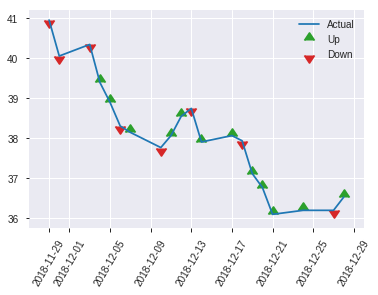


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1957258648705454
RMSE: 0.4424091600210663
LogLoss: 0.5770380024220239
Mean Per-Class Error: 0.28121824186991873
AUC: 0.7694359756097561
pr_auc: 0.7381379498270821
Gini: 0.5388719512195121
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4421524703502655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   53   0.4309   (53.0/123.0)
1      17   111  0.1328   (17.0/128.0)
Total  87   164  0.2789   (70.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442152     0.760274  163
max f2                       0.318241     0.859155  197
max f0point5                 0.484706     0.711436  155
max accuracy                 0.484706     0.721116  155
max precision                0.855957     1         0
max recall                   0.190231     1         240
max specificity              0.855957     1         0
max absolute_mcc             0.442152     0.458305  163
max min_per_class_accuracy   0.544719     0.674797  126
max mean_per_class_accuracy  0.484706     0.718782  155

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.843409           1.96094   1.96094            1                0.851783  1                           0.851783            0.0234375       0.0234375                  96.0938   96.0938
    2        0.0239044                   0.832626           0.653646  1.30729            0.333333         0.837972  0.666667                    0.844878            0.0078125       0.03125                    -34.6354  30.7292
    3        0.0318725                   0.828478           1.96094   1.4707             1                0.831726  0.75                        0.84159             0.015625        0.046875                   96.0938   47.0703
    4        0.0438247                   0.821854           0.653646  1.24787            0.333333         0.823697  0.636364                    0.83671             0.0078125       0.0546875                  -34.6354  24.7869
    5        0.0517928                   0.811384           1.96094   1.35757            1                0.812762  0.692308                    0.833026            0.015625        0.0703125                  96.0938   35.7572
    6        0.103586                    0.762863           1.96094   1.65925            1                0.783456  0.846154                    0.808241            0.101562        0.171875                   96.0938   65.9255
    7        0.151394                    0.737008           1.63411   1.65132            0.833333         0.747221  0.842105                    0.788972            0.078125        0.25                       63.4115   65.1316
    8        0.203187                    0.70702            1.8101    1.69179            0.923077         0.719122  0.862745                    0.771167            0.09375         0.34375                    81.0096   69.1789
    9        0.302789                    0.654785           1.17656   1.52231            0.6              0.67835   0.776316                    0.740635            0.117188        0.460938                   17.6562   52.2307
    10       0.40239                     0.600309           0.94125   1.37848            0.48             0.628775  0.70297                     0.712947            0.09375         0.554688                   -5.875    37.8481
    11       0.501992                    0.545624           1.17656   1.33842            0.6              0.571342  0.68254                     0.684851            0.117188        0.671875                   17.6562   33.8418
    12       0.601594                    0.496075           1.255     1.32461            0.64             0.521135  0.675497                    0.657745            0.125           0.796875                   25.5      32.4607
    13       0.701195                    0.404054           0.94125   1.27015            0.48             0.44828   0.647727                    0.627992            0.09375         0.890625                   -5.875    27.0153
    14       0.800797                    0.307975           0.6275    1.19022            0.32             0.353709  0.606965                    0.593877            0.0625          0.953125                   -37.25    19.0221
    15       0.900398                    0.231642           0.235313  1.08459            0.12             0.270129  0.553097                    0.558064            0.0234375       0.976562                   -76.4688  8.45893
    16       1                           0.131911           0.235313  1                  0.12             0.192218  0.50996                     0.521625         

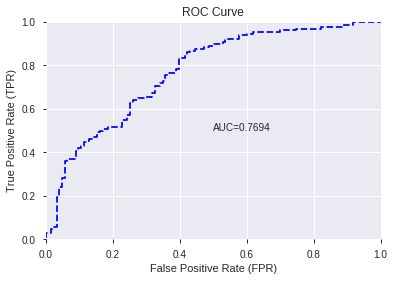

This function is available for GLM models only


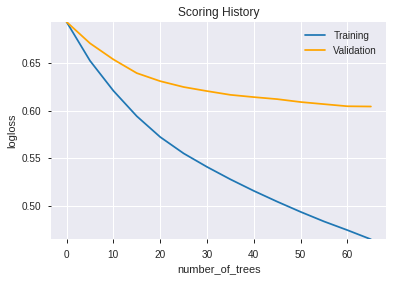

--2019-08-26 18:05:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

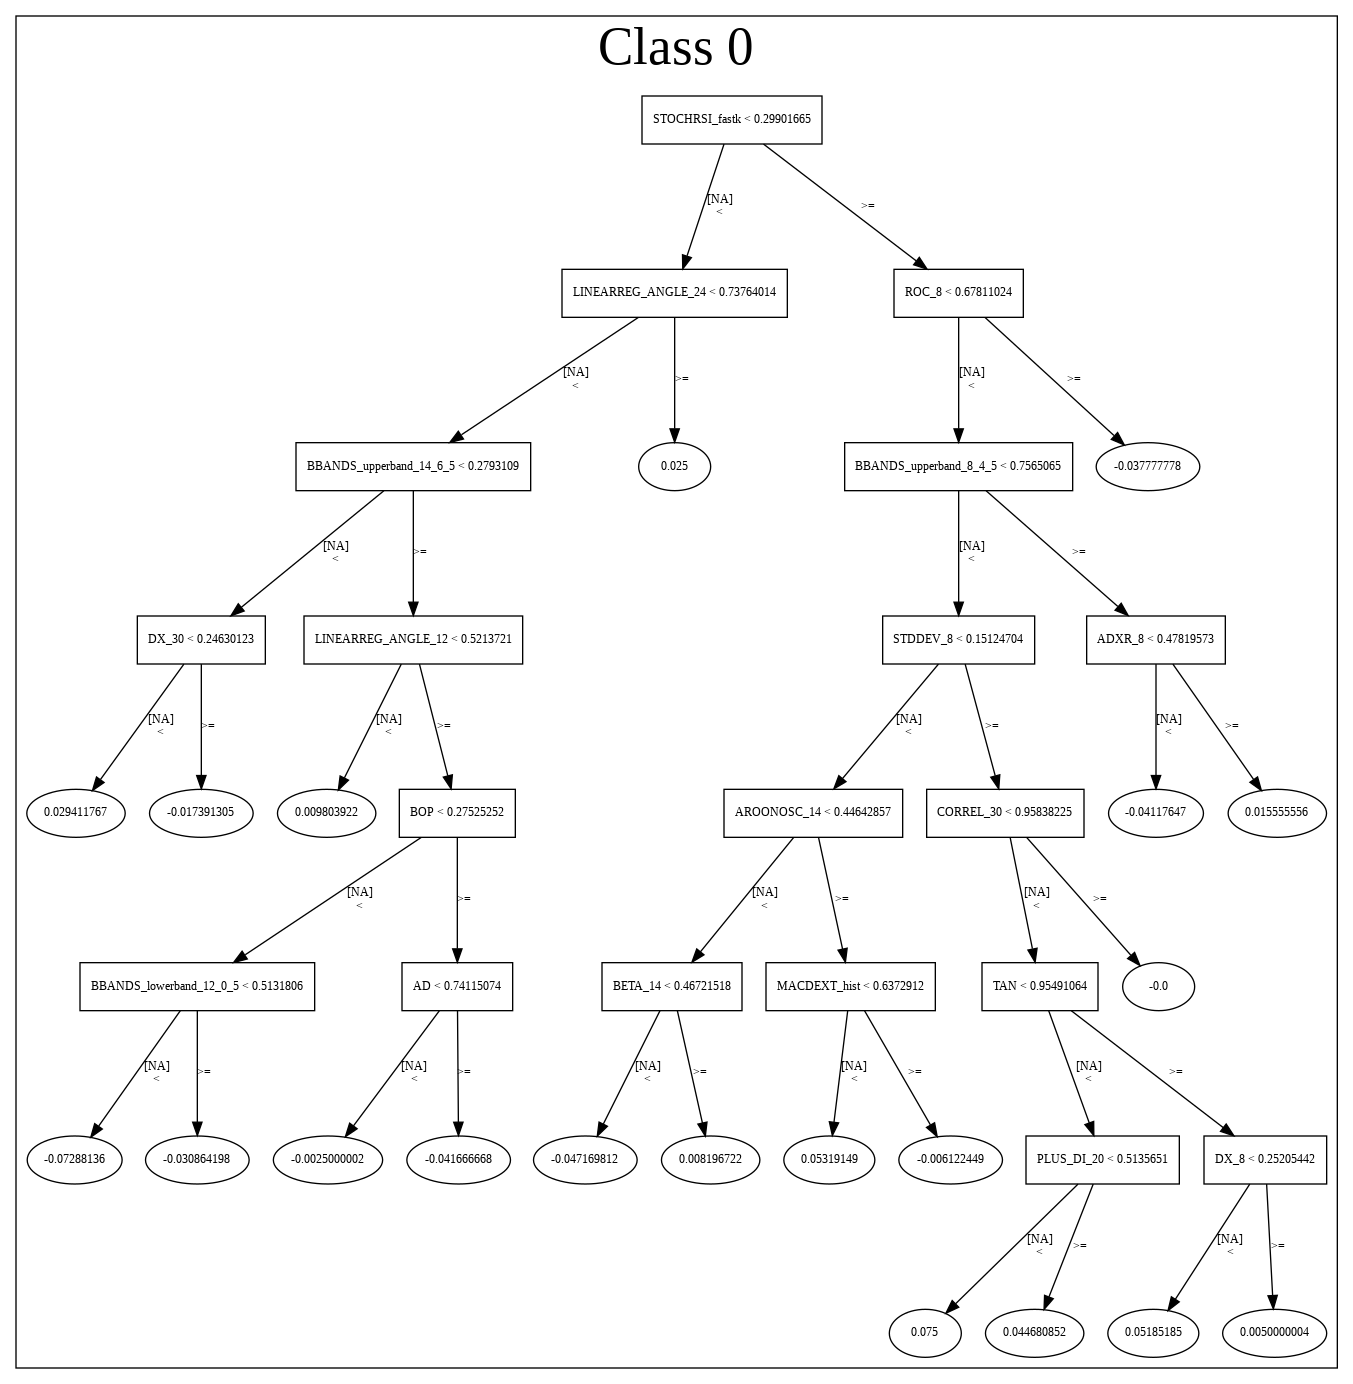

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_180528_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_180528_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b02f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'WILLR_8',
 'aroonup_8',
 'MFI_24',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'DX_14',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'BETA_8',
 'WILLR_14',
 'MFI_12',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'STDDEV_8',
 'STOCHRSI_fastk',
 'STDDEV_12',
 'MINUS_DI_14',
 'CORREL_12',
 'BETA_12',
 'OBV',
 'ATR_24',
 'CORREL_8',
 'CCI_14',
 'ROCP_20',
 'MFI_8',
 'PLUS_DI_24',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'WILLR_20',
 'MOM_12',
 'DX_12',
 'MINUS_DM_30',
 'ROC_12',
 'MACDEXT_hist',
 'CORREL_14',
 'MFI_14',
 'ATR_20',
 'WILLR_12',
 'PPO',
 'LINEARREG_ANGLE_8',
 'ROC_8',
 'ADX_14',
 'BETA_14',
 'PLUS_DM_8',
 'MACD_hist',
 'PLUS_DI_20',
 'PLUS_DM_30',
 'ROCP_14',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'ATR_30',
 'STOCH_slowk',
 'PLUS_DM_12',
 'WILLR_24',
 'HT_PHASOR_inphase',
 'CMO_20',
 'MINUS_DI_24',
 'PLUS_DI_14',
 'MACDEXT_signal',
 'MFI_20',
 'MINUS_DM_12',
 'ADX_24',
 'WILLR_30',
 'PLUS_DM_14',
 'ADOSC',
 'DX_24',
 'MINUS_DM_20',
 'MINUS_DM_8',
 'ADXR_14',
 'MAC

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.733
GLM             0.737
XGBoost         0.745
dtype: float64

DeepLearning    GLM  XGBoost
All          0.709  0.737    0.737
DLF          0.733  0.733    0.745
Fwe          0.733  0.725    0.733
RFE          0.733  0.729    0.721
XGBF         0.733  0.733    0.745





F1


DeepLearning    0.771
GLM             0.758
XGBoost         0.781
dtype: float64

DeepLearning    GLM  XGBoost
All          0.756  0.757    0.766
DLF          0.766  0.757    0.781
Fwe          0.759  0.758    0.763
RFE          0.763  0.757    0.760
XGBF         0.771  0.757    0.781





auc


DeepLearning    0.793
GLM             0.789
XGBoost         0.792
dtype: float64

DeepLearning    GLM  XGBoost
All          0.784  0.788    0.783
DLF          0.790  0.789    0.792
Fwe          0.773  0.789    0.780
RFE          0.781  0.778    0.769
XGBF         0.793  0.789    0.792





logloss


DeepLearning    0.621
GLM             0.584
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.621  0.582    0.571
DLF          0.570  0.572    0.559
Fwe          0.588  0.563    0.573
RFE          0.583  0.584    0.577
XGBF         0.557  0.572    0.559





mean_per_class_error


DeepLearning    0.289
GLM             0.274
XGBoost         0.281
dtype: float64

DeepLearning    GLM  XGBoost
All          0.289  0.263    0.265
DLF          0.267  0.268    0.258
Fwe          0.268  0.274    0.268
RFE          0.269  0.273    0.281
XGBF         0.267  0.268    0.258





rmse


DeepLearning    0.462
GLM             0.444
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.462  0.443    0.439
DLF          0.439  0.439    0.433
Fwe          0.449  0.435    0.440
RFE          0.444  0.444    0.442
XGBF         0.429  0.439    0.433





mse


DeepLearning    0.213
GLM             0.197
XGBoost         0.196
dtype: float64

DeepLearning    GLM  XGBoost
All          0.213  0.196    0.193
DLF          0.192  0.192    0.187
Fwe          0.202  0.189    0.194
RFE          0.197  0.197    0.196
XGBF         0.184  0.192    0.187

{'F1':       DeepLearning    GLM  XGBoost
 All          0.756    NaN      NaN
 DLF          0.766    NaN      NaN
 DLF            NaN  0.757      NaN
 DLF            NaN    NaN    0.781
 All            NaN  0.757      NaN
 All            NaN    NaN    0.766
 XGBF         0.771    NaN      NaN
 XGBF           NaN  0.757      NaN
 XGBF           NaN    NaN    0.781
 Fwe          0.759    NaN      NaN
 Fwe            NaN  0.758      NaN
 Fwe            NaN    NaN    0.763
 RFE          0.763    NaN      NaN
 RFE            NaN  0.757      NaN
 RFE            NaN    NaN    0.760,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.709    NaN      NaN
 DLF          0.733    NaN      NaN
 DLF            NaN  0.733      NaN
 DLF            NaN    NaN    0.745
 All            NaN  0.737      NaN
 All            NaN    NaN    0.737
 XGBF         0.733    NaN      NaN
 XGBF           NaN  0.733      NaN
 XGBF           NaN    NaN    0.745
 Fwe          0.733    NaN      NaN
 Fwe     